# Russian casualties across regions in the Russia-Ukraine war

The aim of this project is to model the casualties rate (per 100 000 men) in Russia-Ukraine war across regions of Russia based on various socio-economic and demographic indicators. 

The data on the absolute number of Russian casualties (deaths) in Russia-Ukraine war across regions comes from [Mediazona](https://zona.media/article/2023/07/10/stats). The methodology for counting casualties can be found [here](https://zona.media/article/2023/07/10/stats). It is important to note that not all casualties are accounted for in this record; it is reasonable to assume that the actual number of casualties is 1.5 to 2 times higher. Nonetheless, this is currently the most reliable data available. 

The serious issue concerning the usage of this data in machine learning projects is whether it is representative of the real toll of casualties, specifically whether there is significant selection bias. Unfortunately, we can only speculate on this issue at present. For instance, it is likely that the deaths of Russian soldiers from low populated towns and villages are underrepresented in the Mediazona records. However, to the best of my knowledge, this remains an assumption that has not been rigorously demonstrated so far. Overall, perhaps the best way to frame the following analysis is not in terms of the real death toll of the war on Russian regions but the death toll that has been adequately registered by the best efforts of journalists working on this issue. 

It is important to note that this project is primarily focused on machine learning and does not intend to make any claims beyond the technical aspects of applying machine learning techniques to data on Russian casualties. This project does not pursue any political agenda. With this in mind, it may be interesting to explore how effectively machine learning techniques can model this type of data. 

Additionally, the sample size is small—only 85 regions. Following machine learning practices, this sample is further divided into training and test sets, which exacerbates the sample size issue. For such small samples, simple techniques that generally avoid overfitting are often the most suitable. However, in this project, some relatively sophisticated methods have been employed. It is essential to acknowledge that this is a portfolio project, one of the aims of which is to demonstrate a specific set of skills in machine learning and the ability to work with various models. As a result, some methods were tried and experimented with (especially in the full version of this project) which perhaps would not be employed in "real" ML projects demanding more robust approaches. Nevertheless, relatively sophisticated and arguably less robust methods on small datasets generally succeeded in this particular project, as can be seen in the corresponding sections below. 

***
The data in socio-economic indicators of Russian regions was obtained from the Federal State Statistics Service site (Rosstat): [rosstat.gov.ru](rosstat.gov.ru). Information regarding payments for signing a contract to serve in the Russian army was sourced from publicly accessible websites, mainly associated with regional authorities. 

## Data Dictionary

In [1]:
import pandas as pd
from pandas import DataFrame

In [2]:
pd.set_option('display.max_colwidth', None)
data_dictionary = pd.read_csv(r"variables.csv")
data_dictionary.set_index("Feature", inplace=True)
data_dictionary

Description
Feature                                                                                                                                                              
poverty_level_2022                                                                                                                                   poverty level, %
entrepreneurship_income_2023                                                                              income from entrepreneurship in general income structure, %
social_transfers_income_2023                                                                              income from social transfers in general income structure, %
mean_salary_2022                                                                                                                                mean salary in rubles
median_income_2022                                                                                                                            median income in rubles
Gini_coeff_2022                                                                                                                                      Gini coefficient
decile_coeff_2022                                                                                                                                  decile coefficient
GRP_pc_2022                                                                                                                         gross regional product per capita
unemployment_2022                                                                                                                                   unemployment rate
men_working_age_total_2022                                                                                                     the total number of men of working age
relative_cost_of_living_2022      the coefficient of the cost of living in comparison to the that of Russia on the whole (i.e., for Russian on the whole it equals 1)
men_higher_educ_2020                                                                                            share of men of 20-60 years old with higher education
population_2022                                                                                                                                            population
men_share_never_married_2022                                                                                        share of men of 20-60 years old who never married
men_share_divorced_2022                                                                                           share of men of 20-60 years old divorced or widowed
share_of_ethnic_russians_2024                                                                                                                share of ethnic Russians
men_longevity_2022                                                                                                                                men life expectancy
men_working_age_rural_2022                                                                                              share of men of working age living in country
crimes_per_10_000_residents_2022                                                                                                number of crimes per 10 000 residents
border_with_Ukraine                                                                           does the region have a common border with Ukraine (including maritime)?
casualties_mid_july_2025                                                                                                 the number of casualties as of mid-July 2025
contract_payment_2023                                             the size of the immediate payment for signing a contract for the service in Russian army as of 2023
square_km^2                                                                                                                                            square in km^2
Cauc

## I. Preparation for the analysis: loading data and packages

In [3]:
from pandas import Series
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV, LeaveOneOut, KFold
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PowerTransformer, StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import skew, spearmanr, uniform, randint, pearsonr
from sklearn.mixture import GaussianMixture
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, make_scorer, mean_squared_error, median_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.semi_supervised import LabelSpreading
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from sklearn.linear_model import Lasso, Ridge, ElasticNet, HuberRegressor, RANSACRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from itertools import combinations
import random
import shap

In [4]:
casualties_data = pd.read_csv(r"casualties_data_final.csv", encoding="1251")
casualties_data.head()

region_in_Russian   region_in_English  \
0                         Алтайский край          Altai Krai   
1                       Амурская область         Amur Oblast   
2  Архангельская область без авт. округа  Arkhangelsk Oblast   
3                   Астраханская область    Astrakhan Oblast   
4                   Белгородская область     Belgorod Oblast   

   poverty_level_2022  entrepreneurship_income_2023  \
0                13.8                           7.9   
1                11.9                           7.3   
2                 9.2                           6.4   
3                12.5                           6.5   
4                 6.0                           9.2   

   social_transfers_income_2023  mean_salary_2022  median_income_2022  \
0                          26.7           39270.4             33688.5   
1                          19.2           65863.9             76489.2   
2                          25.2           64416.6             30493.9   
3                          23.6           47779.9             26790.4   
4                          20.2           47637.8             29825.3   

   Gini_coeff_2022  decile_coeff_2022  GRP_pc_2022  ...  \
0            0.371                5.7     433803.0  ...   
1            0.401                6.7     794282.4  ...   
2            0.366                5.6     722352.8  ...   
3            0.352                5.2     800575.6  ...   
4            0.370                5.7     840505.6  ...   

   men_share_divorced_2022  share_of_ethnic_russians_2024  men_longevity_2022  \
0                 0.112263                           95.4               64.13   
1                 0.124626                           95.2               62.58   
2                 0.114602                           96.3               64.33   
3                 0.123141                           67.1               66.83   
4                 0.128636                           95.3               67.66   

   men_working_age_rural_2022  crimes_per_10_000_residents_2022  \
0                      248139                             130.8   
1                       74485                             161.8   
2                       62511                             119.0   
3                      103052                             101.9   
4                      160719                              71.8   

   border_with_Ukraine  contract_payment_2023  square_km^2  Caucasus  \
0                    0               100000.0       167996         0   
1                    0               200000.0       361908         0   
2                    0               100000.0       413103         0   
3                    0               150000.0        49024         0   
4                    1               100000.0        27134         0   

   casualties_mid_july_2025  
0                      2259  
1                       534  
2                      1330  
3                      1108  
4                      1213  

[5 rows x 26 columns]

In [5]:
casualties_data.shape

# the original dataset contains 85 observations and 26 features

(85, 26)

In [6]:
casualties_data.info()

# only two features hvae missing values: meadian_income_2022 (8 missing values) and contract_payment_2023 (1 missing value)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   region_in_Russian                 85 non-null     object 
 1   region_in_English                 85 non-null     object 
 2   poverty_level_2022                85 non-null     float64
 3   entrepreneurship_income_2023      85 non-null     float64
 4   social_transfers_income_2023      85 non-null     float64
 5   mean_salary_2022                  85 non-null     float64
 6   median_income_2022                77 non-null     float64
 7   Gini_coeff_2022                   85 non-null     float64
 8   decile_coeff_2022                 85 non-null     float64
 9   GRP_pc_2022                       85 non-null     float64
 10  unemployment_2022                 85 non-null     float64
 11  men_working_age_total_2022        85 non-null     int64  
 12  relative_c

Let's introduce a new feature that labels the federal district to which each region belongs.. This new feature will be useful for splitting data into train and test samples, as it is comfortable to stratify these samples based on the federal district; this would ensure that train and test samples will be broadly similar to each other.

In addition to the "official" federal districts, I will add a new category called "Cities." This category is important because it includes "cities of federal significance" (Moscow, Saint-Petersburg, and Sevastopol), which are very different from other regions (which include a broad range of settlements, including small towns and villages) in terms of socio-economic and demographic characteristics.

It's important to note that Sevastopol and Crimea are included in the dataset without any political implications. The data on these regions is gathered by Mediazona and can be used for modeling purposes.

In [7]:
# Labeling federal districts + adding a new category - "cities of the federal significance" 

federal_districts = {
    "Southern": ["Adygea", "Crimea Republic", "Kalmykia", "Krasnodar Krai", "Astrakhan Oblast", "Volgograd Oblast", "Rostov Oblast"], 
                     
    "Volga": ["Bashkortostan", "Mari El", "Mordovia", "Tatarstan", "Udmurtia", "Chuvashia", "Kirov Oblast", "Nizhny Novgorod Oblast", "Orenburg Oblast", 
              "Penza Oblast", "Perm Krai", "Samara Oblast", "Saratov Oblast", "Ulyanovsk Oblast"], 
                     
    "Far_Eastern": ["Buryatia", "Sakha", "Primorsky Krai", "Khabarovsk Krai", "Amur Oblast", "Kamchatka Krai", "Magadan Oblast", "Sakhalin Oblast", 
                    "Zabaykalsky Krai", "Jewish Autonomous Oblast", "Chukotka Autonomous Okrug"], 
                     
    "Siberian": ["Altai Republic", "Tuva", "Khakassia", "Krasnoyarsk Krai", "Altai Krai", "Irkutsk Oblast", "Kemerovo Oblast", "Novosibirsk Oblast", 
                 "Omsk Oblast", "Tomsk Oblast"], 
                     
    "North_Caucasian": ["Dagestan", "Ingushetia", "Kabardino-Balkaria", "Karachay-Cherkessia", "North Ossetia–Alania", "Chechnya", "Stavropol Krai"], 
                     
    "Northwestern": ["Karelia", "Komi Republic", "Arkhangelsk Oblast", "Vologda Oblast", "Kaliningrad Oblast", "Leningrad Oblast", "Murmansk Oblast", 
                     "Novgorod Oblast", "Pskov Oblast", "Nenets Autonomous Okrug"], 
                     
    "Central": ["Belgorod Oblast", "Bryansk Oblast", "Vladimir Oblast", "Voronezh Oblast", "Ivanovo Oblast", "Kaluga Oblast", "Kostroma Oblast", 
                "Kursk Oblast", "Lipetsk Oblast", "Moscow Oblast", "Oryol Oblast", "Ryazan Oblast", "Smolensk Oblast", "Tambov Oblast", "Tver Oblast", 
                "Tula Oblast", "Yaroslavl Oblast"],

    "Ural": ["Kurgan Oblast", "Sverdlovsk Oblast", "Tyumen Oblast", "Chelyabinsk Oblast", "Khanty-Mansi Autonomous Okrug", 
             "Yamalo-Nenets Autonomous Okrug"],

    "Cities": ["Moscow", "Saint Petersburg", "Sevastopol"]
    }

# Creating an inversed dictionary for applying a .map() method:
inversed_dict = {j: i for i, group in federal_districts.items() for j in group}

casualties_data["fed_district"] = casualties_data["region_in_English"].map(inversed_dict)

In [8]:
# Splitting the sample with stratification on the federal districts:
train_data, test_data = train_test_split(casualties_data, test_size = 0.3, stratify = casualties_data["fed_district"], random_state=42)

In [9]:
# Checking that the distribution of federal districts across original data and two subsets is similar:

print(
    "Original sample: ", casualties_data["fed_district"].value_counts() / len(casualties_data),
    "\n\nTrain sample: ", train_data["fed_district"].value_counts() / len(train_data),
    "\n\nTest sample: ", test_data["fed_district"].value_counts() / len(test_data)
    )

Original sample:  fed_district
Central            0.200000
Volga              0.164706
Far_Eastern        0.129412
Siberian           0.117647
Northwestern       0.117647
Southern           0.082353
North_Caucasian    0.082353
Ural               0.070588
Cities             0.035294
Name: count, dtype: float64 

Train sample:  fed_district
Central            0.203390
Volga              0.169492
Northwestern       0.118644
Far_Eastern        0.118644
Siberian           0.118644
North_Caucasian    0.084746
Southern           0.084746
Ural               0.067797
Cities             0.033898
Name: count, dtype: float64 

Test sample:  fed_district
Central            0.192308
Far_Eastern        0.153846
Volga              0.153846
Siberian           0.115385
Northwestern       0.115385
Southern           0.076923
North_Caucasian    0.076923
Ural               0.076923
Cities             0.038462
Name: count, dtype: float64


In [10]:
# Checking the sizes of the train and test sets
print(len(train_data), len(test_data))

59 26


From the statistical point of view, the size of the train and test sets are certainly very small, and this will be a vulnerability of the analysis that follows. However, it still can be broadly meaningful if we use simple enough models that do not tend to overfit data on small samples.

In [11]:
# The regions from the train set:
list(train_data["region_in_English"].unique())

['Sevastopol',
 'Tambov Oblast',
 'Ulyanovsk Oblast',
 'Saratov Oblast',
 'Magadan Oblast',
 'Kaluga Oblast',
 'Sverdlovsk Oblast',
 'Rostov Oblast',
 'Krasnoyarsk Krai',
 'Nenets Autonomous Okrug',
 'Adygea',
 'Karachay-Cherkessia',
 'Bryansk Oblast',
 'Perm Krai',
 'Samara Oblast',
 'Kalmykia',
 'Vologda Oblast',
 'Bashkortostan',
 'Kemerovo Oblast',
 'Mari El',
 'Voronezh Oblast',
 'Pskov Oblast',
 'Irkutsk Oblast',
 'Lipetsk Oblast',
 'Karelia',
 'Sakhalin Oblast',
 'Amur Oblast',
 'Moscow Oblast',
 'Novgorod Oblast',
 'Tyumen Oblast',
 'Kostroma Oblast',
 'Tuva',
 'Krasnodar Krai',
 'Ryazan Oblast',
 'Yaroslavl Oblast',
 'Chelyabinsk Oblast',
 'Belgorod Oblast',
 'Chuvashia',
 'Murmansk Oblast',
 'Chechnya',
 'Udmurtia',
 'Dagestan',
 'Mordovia',
 'Zabaykalsky Krai',
 'Kamchatka Krai',
 'Tomsk Oblast',
 'Stavropol Krai',
 'Tatarstan',
 'Tula Oblast',
 'Khabarovsk Krai',
 'Kurgan Oblast',
 'Arkhangelsk Oblast',
 'Saint Petersburg',
 'Omsk Oblast',
 'Vladimir Oblast',
 'Khakassia',


Now we are ready to proceed to the exploratory analysis (of the train set).

## II. Exploratory analysis and feature engineering

In [12]:
# Creating a working copy of the train set
workcopy_train = train_data.copy()
workcopy_train.set_index("region_in_English", inplace=True)

# Creating a target variable - number of casualties per 100 000 of men in the region:
workcopy_train["casualties_rate"] = workcopy_train["casualties_mid_july_2025"] / (workcopy_train["men_working_age_total_2022"] / 100_000)

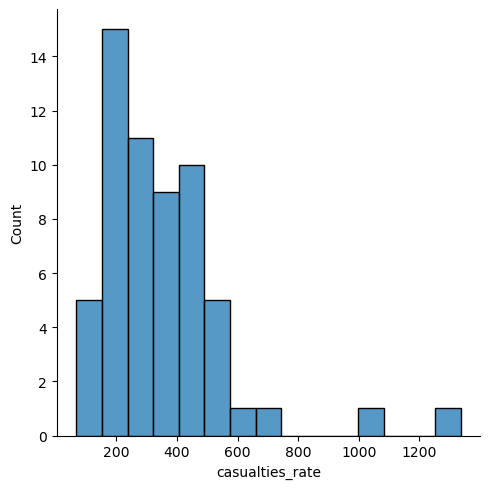

In [13]:
# How casualties rates are distributed across regions

sns.displot(data = workcopy_train, x = "casualties_rate", bins = 15)
plt.show()

# the distribution is visibly right-skewed

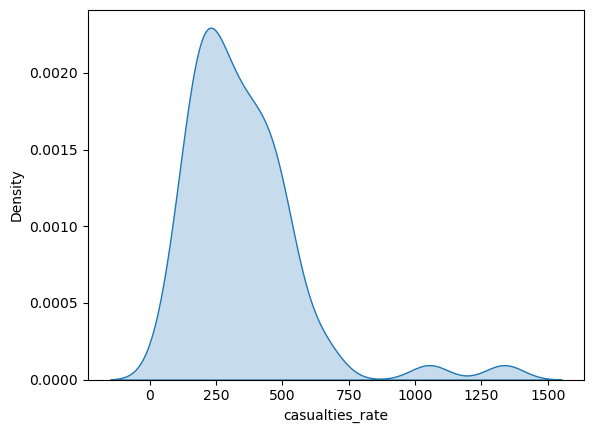

In [14]:
sns.kdeplot(data = workcopy_train, x = "casualties_rate", fill = True, bw_adjust = 0.75)
plt.show()

# The skewness is rather pronounced. There are also some regions with much higher casualty rates (> 1000) than others

Let's create a new version of the target variable to make it more suitable for the analysis that follows; log-transform seems to be a reasonable option here. 

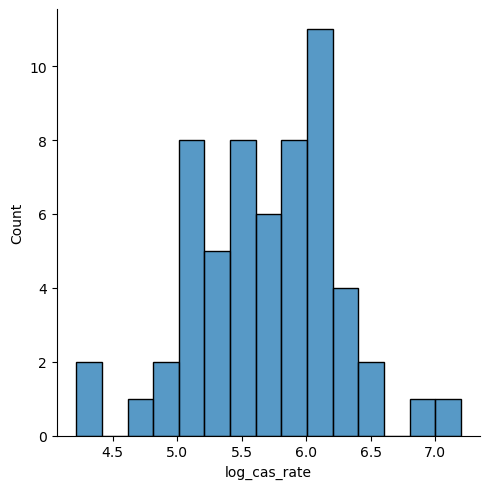

In [15]:
workcopy_train["log_cas_rate"] = np.log(workcopy_train["casualties_rate"])

sns.displot(data = workcopy_train, x = "log_cas_rate", bins = 15)
plt.show()

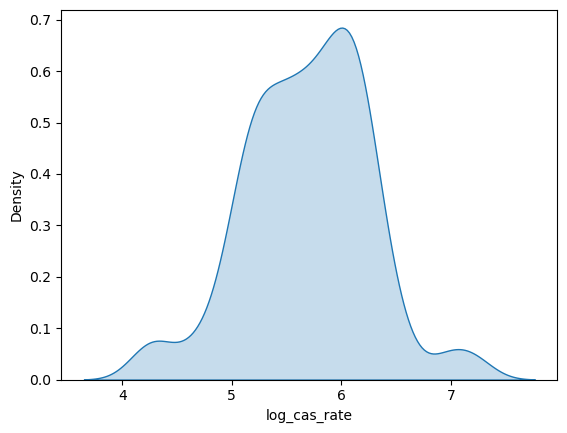

In [16]:
sns.kdeplot(data = workcopy_train, x = "log_cas_rate", fill = True, bw_adjust = 0.75)
plt.show()

The distribution after log-transform is less skewed, but there is still a problem of heavy tails. Perhaps another transformation could help.

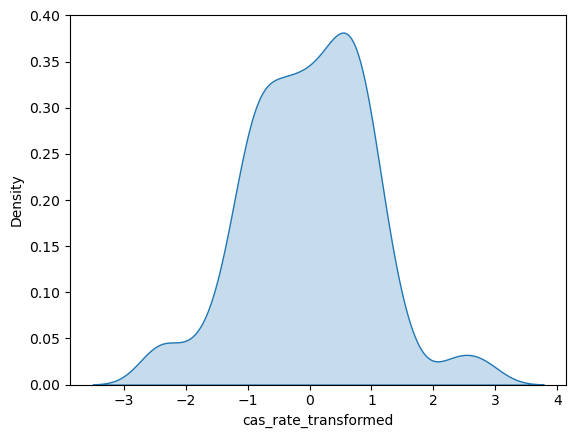

In [17]:
# Applying Yeo-Johnson transformation to the original target variable

cas_rate_transformed = PowerTransformer(method = "yeo-johnson").fit_transform(workcopy_train[["log_cas_rate"]])
cas_rate_transformed  = DataFrame(cas_rate_transformed, columns = ["cas_rate_transformed"])
sns.kdeplot(data = cas_rate_transformed, x = "cas_rate_transformed", fill=True, bw_adjust = 0.75)
plt.show()

Unfortunately, this does not help and heavy tails persist. Together with a small sample size, this deviation from normality is an argument to use robust models in the main part of the analysis.

Now, let's take a closer look at the descriptive statistics of the target variable, both in its original form and after log transformation.

In [18]:
workcopy_train["casualties_rate"].describe()

count      59.000000
mean      346.427757
std       216.125160
min        67.897874
25%       200.339783
50%       301.605167
75%       458.448867
max      1336.278660
Name: casualties_rate, dtype: float64

In [19]:
workcopy_train["log_cas_rate"].describe()

count    59.000000
mean      5.689034
std       0.570998
min       4.218005
25%       5.300013
50%       5.709119
75%       6.127848
max       7.197644
Name: log_cas_rate, dtype: float64

In [20]:
# Regions sorted by casualty rate
workcopy_train["casualties_rate"].sort_values()

region_in_English
Saint Petersburg             67.897874
Chechnya                     76.088439
Kabardino-Balkaria          104.274150
Moscow Oblast               125.504942
Tula Oblast                 142.683495
Karachay-Cherkessia         152.878860
Dagestan                    157.476879
Sevastopol                  161.475819
Ryazan Oblast               173.455913
Khabarovsk Krai             175.919763
Yaroslavl Oblast            177.830468
Adygea                      180.545846
Crimea Republic             181.356547
Rostov Oblast               191.298236
Stavropol Krai              199.947346
Voronezh Oblast             200.732220
Krasnodar Krai              200.973580
Kaluga Oblast               213.108416
Vladimir Oblast             226.240309
Amur Oblast                 228.842758
Lipetsk Oblast              243.777804
Samara Oblast               244.172306
Murmansk Oblast             251.904530
Mordovia                    253.396007
Belgorod Oblast             265.769812
Tambov 

Some interesting patterns can be identified: 

Among the 10 regions with the lowest casualty rates:

1) Three regions—Saint Petersburg, Moscow Oblast, and Sevastopol—are either composed entirely of a single large city, or, in the case of Moscow Oblast, are closely connected to a big city;
2) Four regions (Chechnya, Dagestan, Karachay-Cherkessia, Kabardino-Balkaria) are Caucasus republics (therefore the dummy for Caucasus was included in the dataset); Adygea is on 12th place.

Among the 10 regions with the highest casualty rates:

3) Six regions are situated in Siberia or the Far East;
4) Six regions are national republics.

Observation # 3 suggests that some kind of an indicator of "periphery regions" can be useful for predicting casualty rates. A new feature that reflects this property could be the logarithm of population density (since low population density can be thought of as a proxy for being a "periphery region").

Observation #4 highlights the importance of considering the national composition of Russian regions. However, this observation conflicts with Observation #2, as the Caucasian republics are also categorized as national regions. This indicates that the characteristic of being "national" does not have a straightforward relationship with casualty rates.

5) Buryatia and Tuva "lead" by a wide margin; statistically, they are likely to be outliers. However, we cannot dismiss them as such in a substantive sense, as these high casualty rates may indicate specific combinations of factors—essentially a "perfect storm" leading to intense participation of the local male population in the war.

In [21]:
# Creating a (log-transform) feature of population density as a proxy for the property of being a "periphery region" 
# We add 2 to make all values non-negative for the more comfortable interpretation
workcopy_train["log_density"] =  np.log(workcopy_train['population_2022'] / workcopy_train['square_km^2']) + 2

In [22]:
# The distribution of the share of ethically Russian population across regions
workcopy_train["share_of_ethnic_russians_2024"].sort_values()

region_in_English
Chechnya                    1.2
Dagestan                    3.3
Tuva                       10.1
Kabardino-Balkaria         19.8
Kalmykia                   25.7
Karachay-Cherkessia        27.5
Chuvashia                  30.7
Bashkortostan              37.5
Tatarstan                  40.3
Mari El                    52.5
Mordovia                   54.1
Buryatia                   64.0
Adygea                     64.4
Udmurtia                   67.7
Nenets Autonomous Okrug    69.6
Crimea Republic            73.0
Tyumen Oblast              76.4
Ulyanovsk Oblast           77.5
Khakassia                  82.1
Stavropol Krai             82.9
Chelyabinsk Oblast         86.3
Karelia                    86.4
Magadan Oblast             87.7
Kamchatka Krai             88.3
Omsk Oblast                88.7
Zabaykalsky Krai           89.2
Perm Krai                  89.4
Samara Oblast              89.6
Saratov Oblast             89.7
Murmansk Oblast            89.9
Sevastopol            

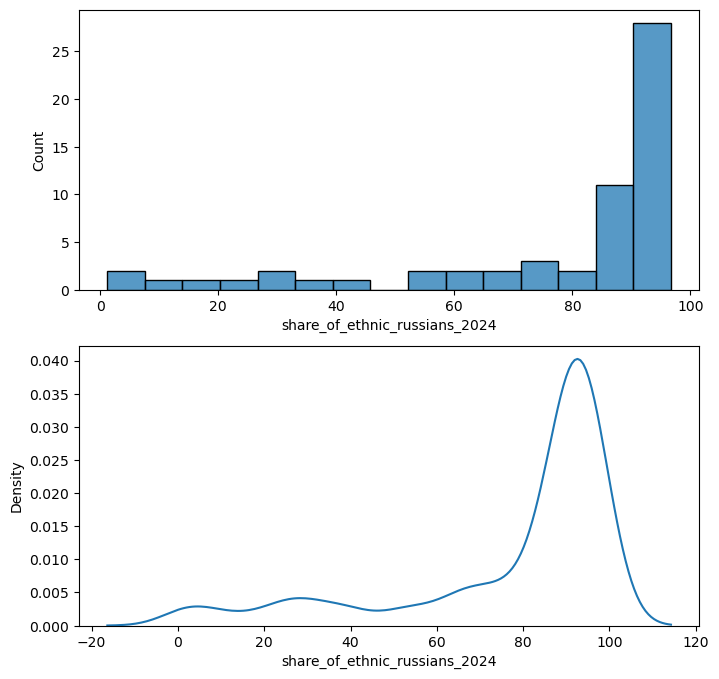

In [23]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8, 8))

sns.histplot(data = workcopy_train, x = "share_of_ethnic_russians_2024", bins = 15, ax = axs[0])
sns.kdeplot(data = workcopy_train, x = "share_of_ethnic_russians_2024", ax = axs[1], bw_adjust = 0.5)
plt.show()

These plots show that the distribution of this feature is heavily left-skewed. The kernel density plot suggests that we may be dealing with a multimodal distribution, consisting of sub-distributions of varying sizes. The most prominent distribution centers around a 95% share of the ethnically Russian population, while two smaller distributions have modes at approximately 5% and 30% of the ethnically Russian population, respectively. Taking these observations into account, it might be useful to attempt to distinguish these distributions from each other. We may use Gaussian Mixture model to distinguish different subpopulations from each other.

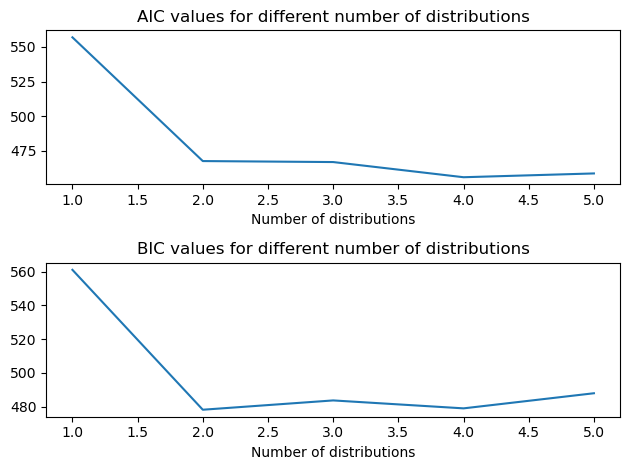

In [24]:
# Evaluating AIC and BIC for different number of distributions to find the optimal number of components for Gaussian Mixture model

aics = []
bics = []

for i in range(1, 6):
    gm = GaussianMixture(n_components = i, n_init = 10, random_state=42)
    gm.fit(workcopy_train[["share_of_ethnic_russians_2024"]])
    aics.append(gm.aic(workcopy_train[["share_of_ethnic_russians_2024"]]))
    bics.append(gm.bic(workcopy_train[["share_of_ethnic_russians_2024"]]))

fig, axs = plt.subplots(nrows = 2, ncols = 1)

x_axis_vals = range(1, len(aics)+1)

axs[0].plot(x_axis_vals, aics)
axs[0].set_title("AIC values for different number of distributions")
axs[0].set_xlabel("Number of distributions")

axs[1].plot(x_axis_vals, bics)
axs[1].set_title("BIC values for different number of distributions")
axs[1].set_xlabel("Number of distributions")

plt.tight_layout()
plt.show()

Technically, four distributions (and, consequently, four clusters of regions) seems to be the best option, but 1) it is not much better than the option with two clusters and 2) would imply a noticeable complication of the (linear) models through introduction of several new variables (especially if we want to have interaction terms as well). On balance, it seems that two clusters is a reasonable choice. Now we can proceed to indentifying them. 

In [25]:
gm = GaussianMixture(n_components = 2, n_init = 10, random_state=42)
gm.fit(workcopy_train[["share_of_ethnic_russians_2024"]])
clusters = gm.predict((workcopy_train[["share_of_ethnic_russians_2024"]]))
workcopy_train["ethnic_clusters"] = clusters
workcopy_train[["share_of_ethnic_russians_2024", "ethnic_clusters"]].sort_values(by = "share_of_ethnic_russians_2024")

share_of_ethnic_russians_2024  ethnic_clusters
region_in_English                                                      
Chechnya                                           1.2                1
Dagestan                                           3.3                1
Tuva                                              10.1                1
Kabardino-Balkaria                                19.8                1
Kalmykia                                          25.7                1
Karachay-Cherkessia                               27.5                1
Chuvashia                                         30.7                1
Bashkortostan                                     37.5                1
Tatarstan                                         40.3                1
Mari El                                           52.5                1
Mordovia                                          54.1                1
Buryatia                                          64.0                1
Adygea                                            64.4                1
Udmurtia                                          67.7                1
Nenets Autonomous Okrug                           69.6                1
Crimea Republic                                   73.0                1
Tyumen Oblast                                     76.4                1
Ulyanovsk Oblast                                  77.5                1
Khakassia                                         82.1                1
Stavropol Krai                                    82.9                1
Chelyabinsk Oblast                                86.3                0
Karelia                                           86.4                0
Magadan Oblast                                    87.7                0
Kamchatka Krai                                    88.3                0
Omsk Oblast                                       88.7                0
Zabaykalsky Krai                                  89.2                0
Perm Krai                                         89.4                0
Samara Oblast                                     89.6                0
Saratov Oblast                                    89.7                0
Murmansk Oblast                                   89.9                0
Sevastopol                                        90.1                0
Kaluga Oblast                                     90.4                0
Saint Petersburg                                  90.6                0
Sakhalin Oblast                                   91.2                0
Rostov Oblast                                     91.7                0
Irkutsk Oblast                                    92.2                0
Moscow Oblast                                     92.2                0
Sverdlovsk Oblast                                 92.3                0
Krasnodar Krai                                    92.4                0
Khabarovsk Krai                                   92.9                0
Kurgan Oblast                                     93.4                0
Tomsk Oblast                                      93.4                0
Krasnoyarsk Krai                                  93.6                0
Tula Oblast                                       94.1                0
Ryazan Oblast                                     94.6                0
Amur Oblast                                       95.2                0
Kemerovo Oblast                                   95.3                0
Belgorod Oblast                                   95.3                0
Novgorod Oblast                                   95.4                0
Tambov Oblast                                     95.6                0
Voronezh Oblast                                   95.7                0
Vladimir Oblast                                   95.8                0
Pskov Oblast                                      95.8                0
Bryansk Oblast                                    95.9           

As we can see, in this case, a Gaussian Mixture model draws a threshold at 82.9% of the ethnically Russian population. For heuristic purposes, we can set this threshold at 85% (which is compatible with the results of the preceding analysis). This threshold implies that all formally national republics expect for one (Karelia) are assigned to the cluster comprising substantial share of ethnic minorities.

In [26]:
# Some features in the dataset are not meant to be predictors but serve for creating new, meaningful predictors:

# Adjusted (by the cost of living) mean salary:
workcopy_train["adj_mean_salary"] = workcopy_train["mean_salary_2022"] / workcopy_train["relative_cost_of_living_2022"]
# Adjusted median income:
workcopy_train["adj_median_income"] = workcopy_train["median_income_2022"] / workcopy_train["relative_cost_of_living_2022"]
# Adjusted GRP per capita:
workcopy_train["adj_GRP_pc"] = workcopy_train["GRP_pc_2022"] / workcopy_train["relative_cost_of_living_2022"]
# Share of the male rural population:
workcopy_train["share_rural"] = workcopy_train["men_working_age_rural_2022"] / workcopy_train["men_working_age_total_2022"]
# Share of the male population of working age:
workcopy_train["share_working_age_men"] = workcopy_train["men_working_age_total_2022"] / workcopy_train["population_2022"]

In [27]:
num_feats_ = workcopy_train.select_dtypes(include=[np.number])
list(enumerate(num_feats_))

[(0, 'poverty_level_2022'),
 (1, 'entrepreneurship_income_2023'),
 (2, 'social_transfers_income_2023'),
 (3, 'mean_salary_2022'),
 (4, 'median_income_2022'),
 (5, 'Gini_coeff_2022'),
 (6, 'decile_coeff_2022'),
 (7, 'GRP_pc_2022'),
 (8, 'unemployment_2022'),
 (9, 'men_working_age_total_2022'),
 (10, 'relative_cost_of_living_2022'),
 (11, 'men_higher_educ_2020'),
 (12, 'population_2022'),
 (13, 'men_share_never_married_2022'),
 (14, 'men_share_divorced_2022'),
 (15, 'share_of_ethnic_russians_2024'),
 (16, 'men_longevity_2022'),
 (17, 'men_working_age_rural_2022'),
 (18, 'crimes_per_10_000_residents_2022'),
 (19, 'border_with_Ukraine'),
 (20, 'contract_payment_2023'),
 (21, 'square_km^2'),
 (22, 'Caucasus'),
 (23, 'casualties_mid_july_2025'),
 (24, 'casualties_rate'),
 (25, 'log_cas_rate'),
 (26, 'log_density'),
 (27, 'ethnic_clusters'),
 (28, 'adj_mean_salary'),
 (29, 'adj_median_income'),
 (30, 'adj_GRP_pc'),
 (31, 'share_rural'),
 (32, 'share_working_age_men')]

In [28]:
# Creating a subset of the train set with numerical predictors for exploratory analysis
num_feats = workcopy_train.select_dtypes(include=[np.number])
num_feats = DataFrame(num_feats, columns = num_feats.columns.to_list()[:3] + 
                      num_feats.columns.to_list()[5:6] + 
                      num_feats.columns.to_list()[8:9] +
                      num_feats.columns.to_list()[13:17] +
                      num_feats.columns.to_list()[18:19] +
                      num_feats.columns.to_list()[20:21] +
                      num_feats.columns.to_list()[26:27] + 
                      num_feats.columns.to_list()[28:], index = num_feats.index)

In [29]:
# descriptive statistics 
pd.set_option("display.max_columns", None)
num_feats.describe()

poverty_level_2022  entrepreneurship_income_2023  \
count           59.000000                     59.000000   
mean            11.457627                      7.877966   
std              4.105976                      3.766965   
min              4.600000                      1.600000   
25%              9.200000                      5.500000   
50%             10.900000                      6.800000   
75%             13.500000                      9.200000   
max             25.900000                     23.300000   

       social_transfers_income_2023  Gini_coeff_2022  unemployment_2022  \
count                     59.000000        59.000000          59.000000   
mean                      22.450847         0.365034           4.666102   
std                        4.718503         0.024462           2.307455   
min                       12.600000         0.315000           2.000000   
25%                       19.350000         0.348000           3.300000   
50%                       23.200000         0.363000           3.700000   
75%                       25.000000         0.378000           5.150000   
max                       35.200000         0.441000          12.200000   

       men_share_never_married_2022  men_share_divorced_2022  \
count                     59.000000                59.000000   
mean                       0.244386                 0.116531   
std                        0.024945                 0.021319   
min                        0.204041                 0.052591   
25%                        0.231237                 0.108028   
50%                        0.240321                 0.116964   
75%                        0.254692                 0.128057   
max                        0.314880                 0.163092   

       share_of_ethnic_russians_2024  men_longevity_2022  \
count                       59.00000           59.000000   
mean                        77.50678           66.316441   
std                         26.45920            2.728155   
min                          1.20000           61.410000   
25%                         71.30000           64.570000   
50%                         89.90000           65.890000   
75%                         94.35000           67.710000   
max                         96.70000           75.320000   

       crimes_per_10_000_residents_2022  contract_payment_2023  log_density  \
count                         59.000000              59.000000    59.000000   
mean                         105.598305          150508.474576     4.832853   
std                           29.231180          111016.832039     1.733183   
min                           12.500000               0.000000     0.548833   
25%                           87.300000          100000.000000     3.600613   
50%                          104.800000          100000.000000     5.346849   
75%                          125.350000          200000.000000     5.844522   
max                          161.800000          600000.000000    10.293322   

       adj_mean_salary  adj_median_income    adj_GRP_pc  share_rural  \
count        59.000000          53.000000  5.900000e+01    59.000000   
mean      53240.324143       33512.017192  8.632825e+05     0.302817   
std       11840.013690       11333.611662  1.183924e+06     0.130889   
min       36544.062500       19846.354167  2.344710e+05     0.000000   
25%       44477.294535       26848.064516  4.862946e+05     0.224163   
50%       51806.082474       30337.115385  6.350836e+05     0.289401   
75%       57072.966396       35051.348315  8.086397e+05     0.383246   
max       90643.134328       75668.100000  9.230604e+06     0.615388   

       share_working_age_men  
count              59.000000  
mean                0.296653  
std                 0.012163  
min                 0.269712  
25%                 0.288853  
50%                 0.295676  
75%                 0.303140  
max                 0.332536

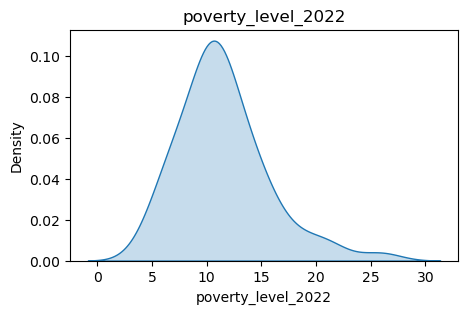

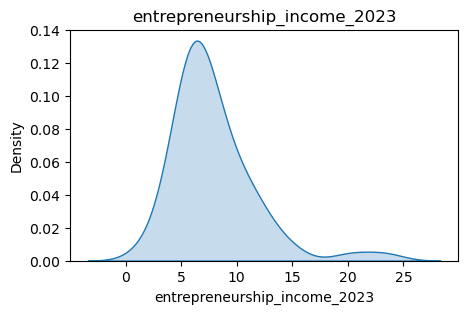

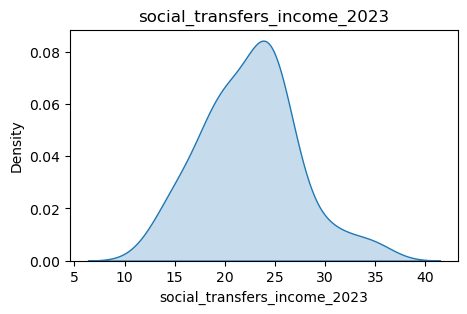

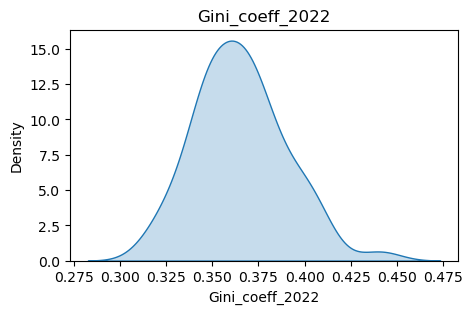

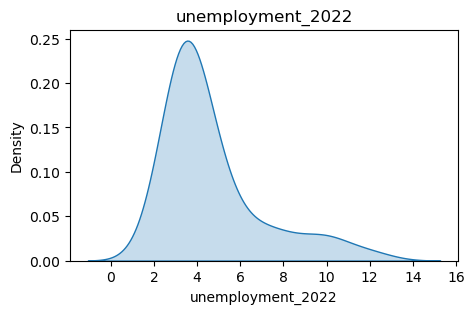

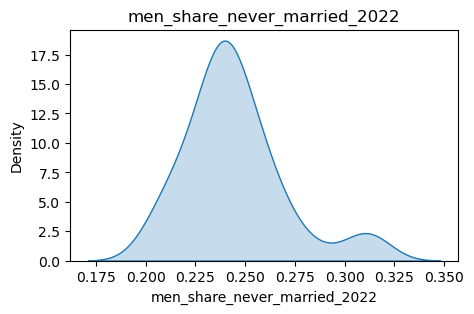

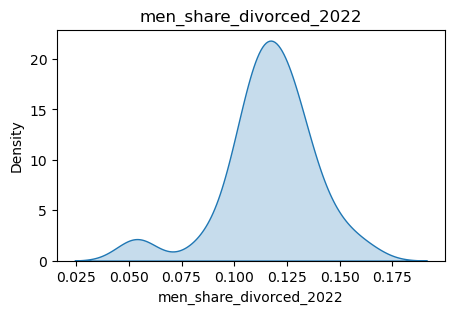

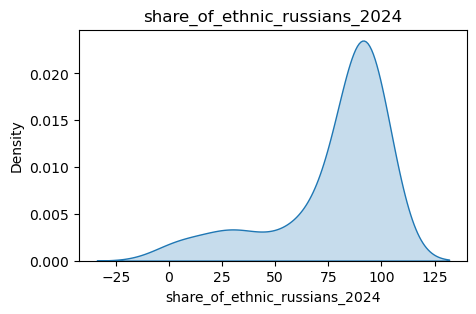

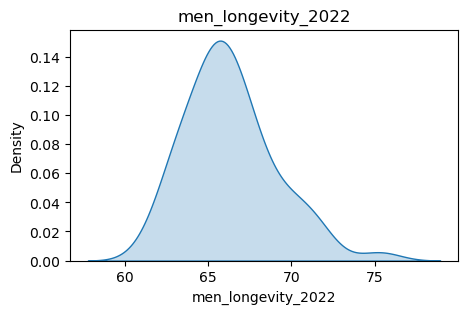

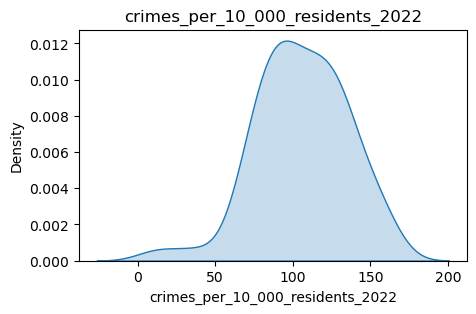

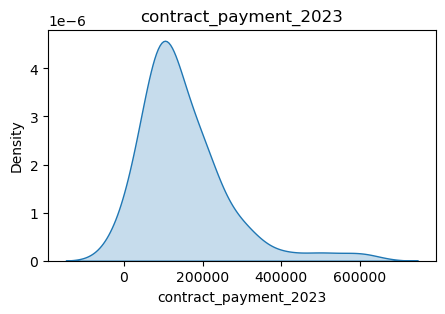

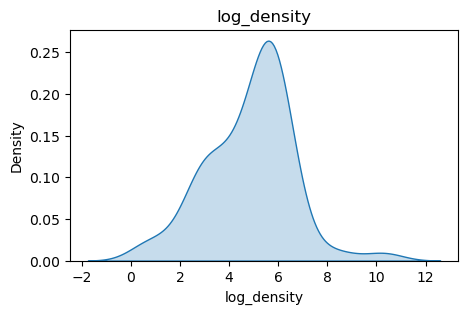

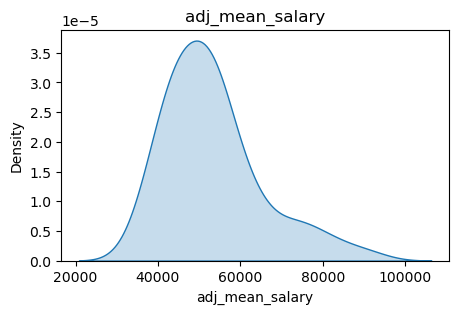

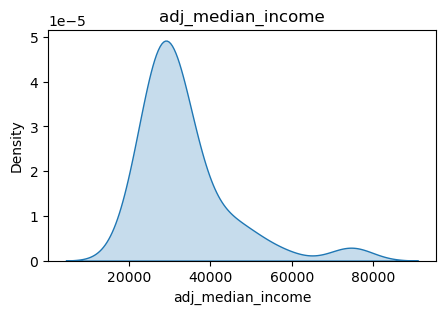

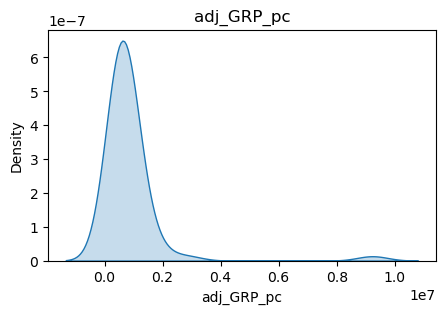

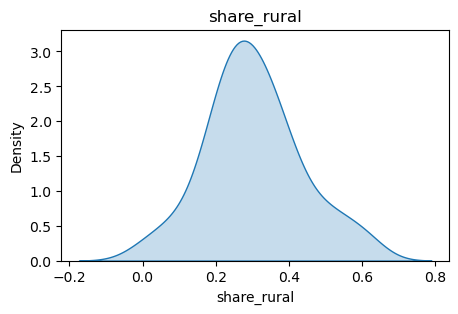

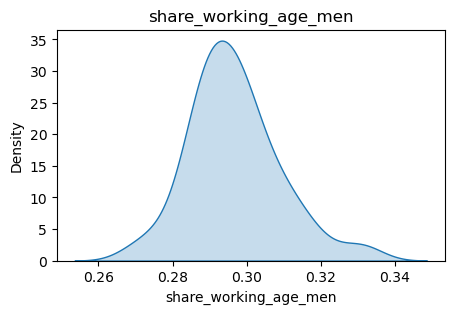

In [30]:
# Kernel denisty plots for potential predictors
for col in num_feats.columns:
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.kdeplot(data = num_feats, x = col, fill=True)
    ax.set_title(col)

plt.show()

The plots indicate that many features exhibit skewness (and we are mostly worried about right-skewness, though left-skewness, if too large, can also be problematic for linear models).  To address this, let's calculate the skewness of the relevant variables.

In [31]:
# Since some vareiables have missing values, imputing is necessary
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 5)

skewness_dict = {}

for col in num_feats.columns:
    imputed = imputer.fit_transform(workcopy_train[[col]]).flatten()
    skewness_dict[col] = skew(imputed).round(3)

skewness_df = DataFrame({"feature": key,
                         "skewness": skewness_dict[key]}
                        for key in skewness_dict.keys()).set_index("feature")

skewness_df

skewness
feature                                   
poverty_level_2022                   1.073
entrepreneurship_income_2023         1.851
social_transfers_income_2023         0.299
Gini_coeff_2022                      0.481
unemployment_2022                    1.619
men_share_never_married_2022         1.064
men_share_divorced_2022             -0.919
share_of_ethnic_russians_2024       -1.612
men_longevity_2022                   0.798
crimes_per_10_000_residents_2022    -0.432
contract_payment_2023                1.843
log_density                         -0.050
adj_mean_salary                      1.146
adj_median_income                    2.200
adj_GRP_pc                           6.211
share_rural                          0.270
share_working_age_men                0.634

Heuristically, we can set skewness = 1 as a threshold: if skewness is larger than 1, then transformation is needed.

In [32]:
for feature in skewness_df.index:
    if skewness_df.loc[feature, "skewness"] > 1:
        workcopy_train[f"log_{feature}"] = np.log(workcopy_train[feature] + 1)

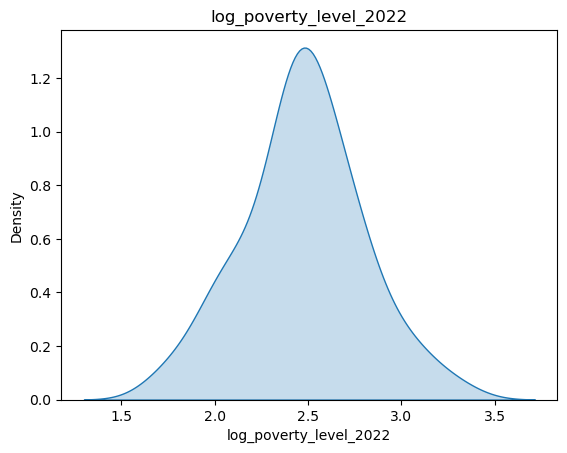

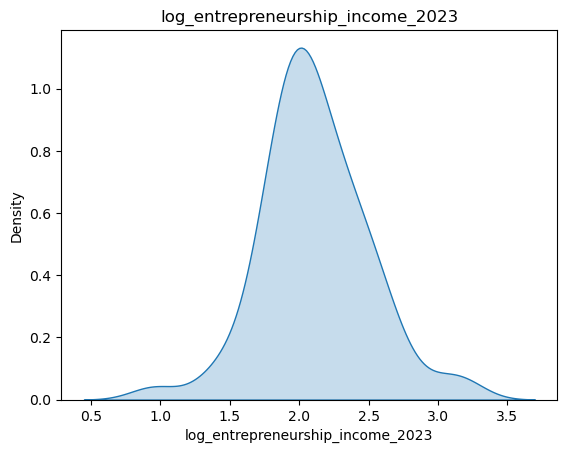

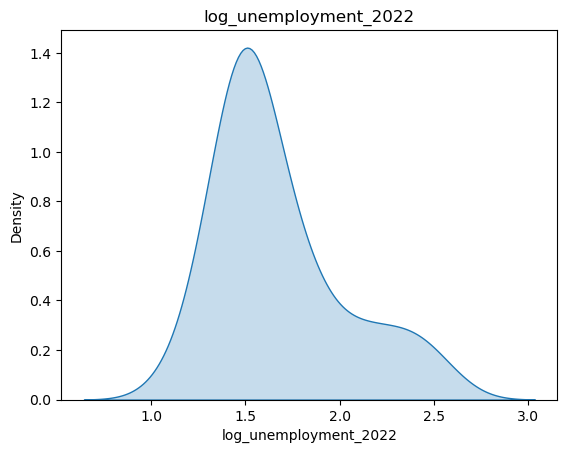

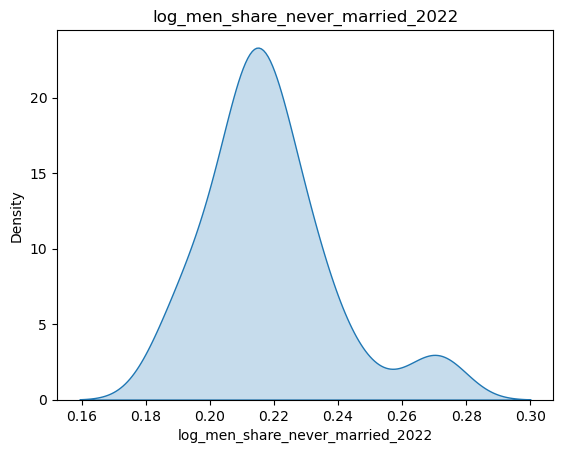

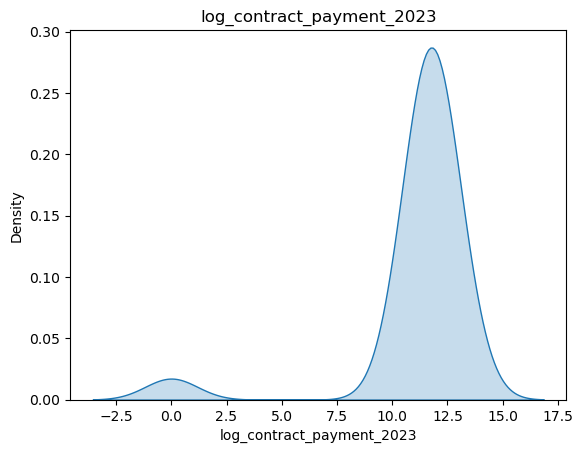

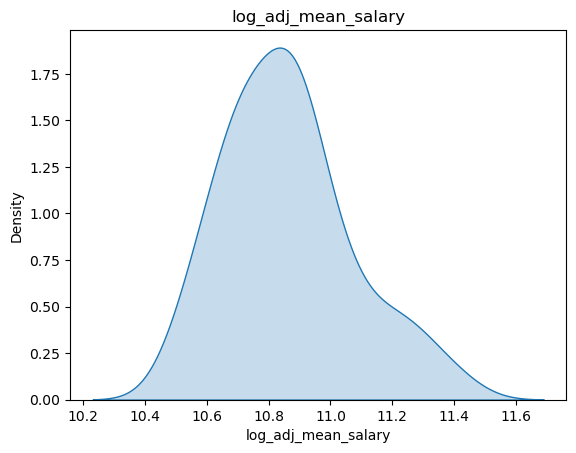

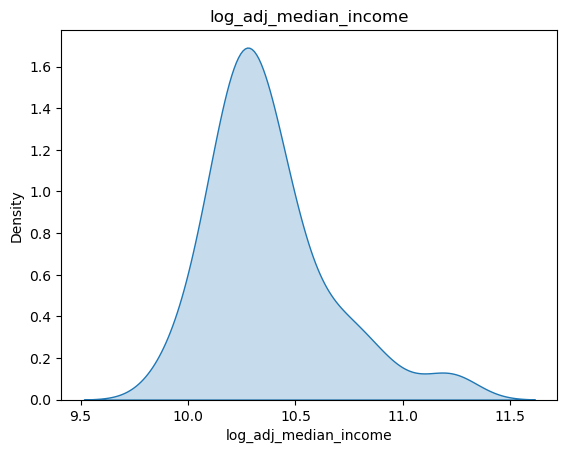

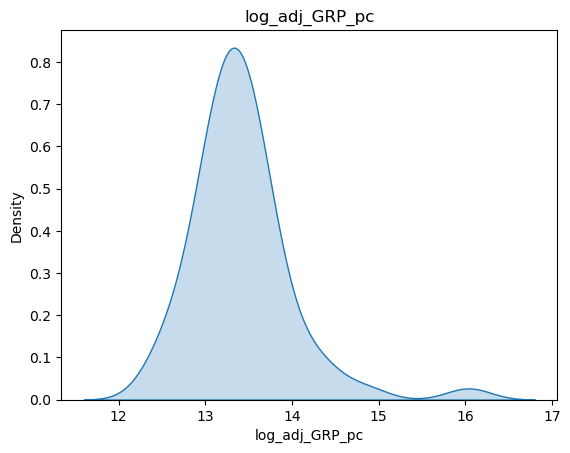

In [33]:
# Let's take a look at the distributions of log-transformed features:
for col in workcopy_train.columns.to_list()[35:]:
    fig, ax = plt.subplots()
    sns.kdeplot(data = workcopy_train, x = col, fill = True)
    ax.set_title(col)

plt.show()

The distributions are, on the whole, closer to normal, but still there are heavy tails signalling that there is a heterogeneity between regions. This was already evident prior to the analysis and was the reason why we performed stratified  (rather than non-stratified) splitting into training and test sets. Earlier we already noted the peculiarity of the Caucasus area and introduced a dummy labeling Caucasus republics. However, this may not be sufficient; we might need to introduce additional dummy variables by grouping regions. To achieve this, we will implement cluster analysis alongside PCA (to get the general idea of how clusters are situated in the features space).

To ensure the robustness of our results, we will begin with two different clustering techniques: Gaussian Mixture and K-Means.

In [34]:
list(enumerate(workcopy_train.columns.to_list()))

[(0, 'region_in_Russian'),
 (1, 'poverty_level_2022'),
 (2, 'entrepreneurship_income_2023'),
 (3, 'social_transfers_income_2023'),
 (4, 'mean_salary_2022'),
 (5, 'median_income_2022'),
 (6, 'Gini_coeff_2022'),
 (7, 'decile_coeff_2022'),
 (8, 'GRP_pc_2022'),
 (9, 'unemployment_2022'),
 (10, 'men_working_age_total_2022'),
 (11, 'relative_cost_of_living_2022'),
 (12, 'men_higher_educ_2020'),
 (13, 'population_2022'),
 (14, 'men_share_never_married_2022'),
 (15, 'men_share_divorced_2022'),
 (16, 'share_of_ethnic_russians_2024'),
 (17, 'men_longevity_2022'),
 (18, 'men_working_age_rural_2022'),
 (19, 'crimes_per_10_000_residents_2022'),
 (20, 'border_with_Ukraine'),
 (21, 'contract_payment_2023'),
 (22, 'square_km^2'),
 (23, 'Caucasus'),
 (24, 'casualties_mid_july_2025'),
 (25, 'fed_district'),
 (26, 'casualties_rate'),
 (27, 'log_cas_rate'),
 (28, 'log_density'),
 (29, 'ethnic_clusters'),
 (30, 'adj_mean_salary'),
 (31, 'adj_median_income'),
 (32, 'adj_GRP_pc'),
 (33, 'share_rural'),
 (34,

In [35]:
# Preparing a subset of features for clusterization
data_clust = DataFrame(workcopy_train, columns = workcopy_train.columns.to_list()[35:] + ['social_transfers_income_2023', 'Gini_coeff_2022',
                                                                                          'men_share_divorced_2022', 'share_of_ethnic_russians_2024',
                                                                                          'men_longevity_2022', 'crimes_per_10_000_residents_2022'],
                       index = workcopy_train.index)

# Though Gaussian Mixture does not need scaling, KMeans do, therefore, for simplicity, let's include it into the general preprocessing pipeline
# We may not be worrying much abeout the accuracy if imputation since there are only two variables with missing values, 
# and they do not appear central for our analysis

preprocessing = make_pipeline(KNNImputer(n_neighbors = 5), StandardScaler())
preprocessed = preprocessing.fit_transform(data_clust)

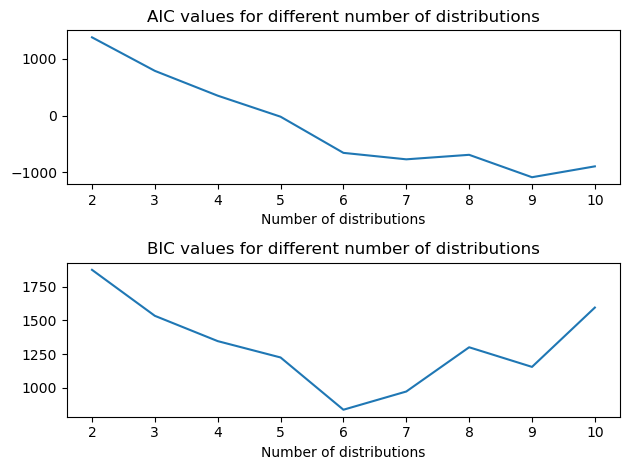

In [36]:
aics_clust = []
bics_clust = []

for i in range(2, 11):
    gm_clust = GaussianMixture(n_components = i, n_init = 10, random_state=42)
    gm_clust.fit(preprocessed)
    aics_clust.append(gm_clust.aic(preprocessed))
    bics_clust.append(gm_clust.bic(preprocessed))

fig, axs = plt.subplots(nrows = 2, ncols = 1)

x_axis_vals = range(2, len(aics_clust)+2)

axs[0].plot(x_axis_vals, aics_clust)
axs[0].set_title("AIC values for different number of distributions")
axs[0].set_xlabel("Number of distributions")

axs[1].plot(x_axis_vals, bics_clust)
axs[1].set_title("BIC values for different number of distributions")
axs[1].set_xlabel("Number of distributions")

plt.tight_layout()
plt.show()

According to the BIC criterion, six clusters is the best option, while according to AIC criterion, nine clusters is preferable. Taking into account the importance of simplicity, we will opt for six clusters.

In [37]:
# Generating cluster labels based on Gaussian Mixture
gm_clust = GaussianMixture(n_components = 6, n_init = 10, random_state=42)
gm_clust.fit(preprocessed)
clusters_gm = gm_clust.predict(preprocessed)

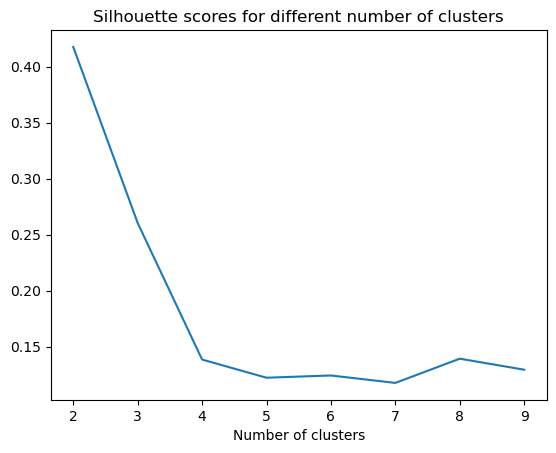

In [38]:
# Choosing the number of clusters for KMeans based on silhouette score
silhouette_scores = []

for i in range(2, 10):
    kmeans = KMeans(n_clusters = i, random_state=42)
    kmeans.fit(preprocessed)
    silh_score = silhouette_score(preprocessed, kmeans.predict(preprocessed))
    silhouette_scores.append(silh_score)

fig, ax = plt.subplots()

x_axis_vals = range(2, len(silhouette_scores)+2)

ax.plot(x_axis_vals, silhouette_scores)
ax.set_title("Silhouette scores for different number of clusters")
ax.set_xlabel("Number of clusters")
plt.show()

According to the silhouette score, the closer the score is to 1, the clearer the boundaries between clusters. Based on the plot, it seems that our sample is best suited for dividing into just 2 clusters; however, the heuristic value of such a division would be minimal. Therefore, let's opt for 3 clusters. 

In [39]:
# Generating cluster labels based on KMeans
kmeans = KMeans(n_clusters = 3, random_state=42)
kmeans.fit(preprocessed)
clusters_km = kmeans.predict(preprocessed)

Now let's implement PCA and in order to explore how clusters are projected into the feature space.

In [40]:
pca = make_pipeline(preprocessing, PCA(n_components = 2, random_state=42))
pca_scores = pca.fit_transform(data_clust)
pca_ = pca.named_steps["pca"]
print(f"Explained variance ratio: "
      f"\nFirst component: {pca_.explained_variance_ratio_[0].round(3)} "
        f"\nSecond component: {pca_.explained_variance_ratio_[1].round(3)}")

Explained variance ratio: 
First component: 0.36 
Second component: 0.164


In [41]:
pca_clusters_df = DataFrame(pca_scores, columns = ["Comp_1", "Comp_2"], index = workcopy_train.index)
pca_clusters_df["cluster_gm"] = clusters_gm
pca_clusters_df["cluster_kmeans"] = clusters_km
pca_clusters_df.head()

Comp_1    Comp_2  cluster_gm  cluster_kmeans
region_in_English                                                
Sevastopol        -0.352760  0.136258           2               2
Tambov Oblast      0.012325 -0.735329           2               2
Ulyanovsk Oblast  -0.781034 -0.869517           2               2
Saratov Oblast    -0.122905 -0.071621           2               2
Magadan Oblast     4.546174  0.649617           4               0

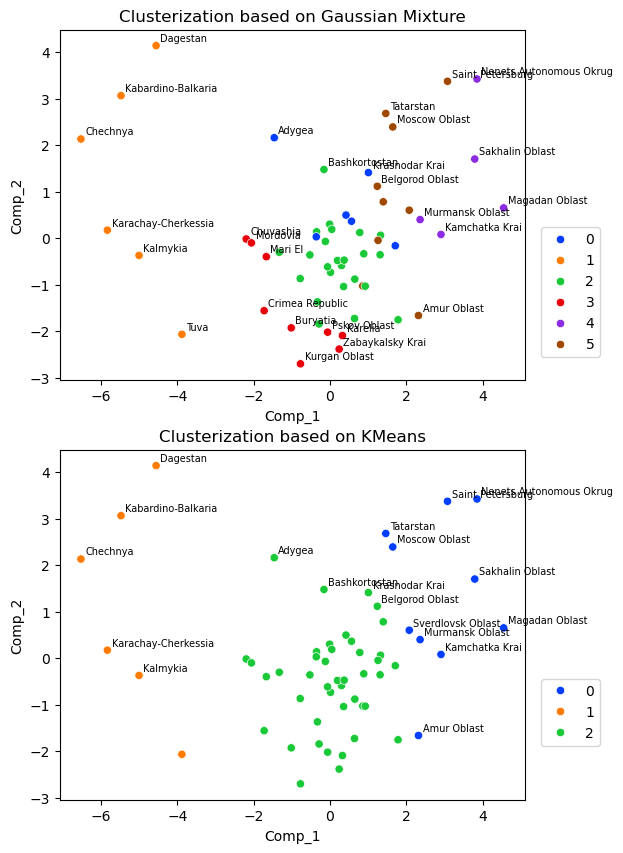

In [42]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (6, 10))

h = sns.scatterplot(data = pca_clusters_df, x = "Comp_1", y = "Comp_2", hue = "cluster_gm", ax = axs[0], palette = "bright")
axs[0].set_title("Clusterization based on Gaussian Mixture")
axs[0].legend(loc = "center left", bbox_to_anchor = (1.02, 0.25))
for i, row in pca_clusters_df.iterrows():
    if row["Comp_1"] < -4 or row["Comp_1"] > 2.2 or row["Comp_2"] > 1 or row["Comp_2"] < -1.9 or row["cluster_gm"] == 4 or row["cluster_gm"] == 3:
        h.annotate(str(i), xy = (row["Comp_1"], row["Comp_2"]), xytext = (3, 3), textcoords = "offset points", fontsize = 7) 

g = sns.scatterplot(data = pca_clusters_df, x = "Comp_1", y = "Comp_2", hue = "cluster_kmeans", ax = axs[1], palette = "bright")
axs[1].set_title("Clusterization based on KMeans")
axs[1].legend(loc = "center left", bbox_to_anchor = (1.02, 0.25))
for i, row in pca_clusters_df.iterrows():
    if row["Comp_1"] < -4 or row["Comp_2"] > 1 or row["cluster_kmeans"] == 0:
        g.annotate(str(i), xy = (row["Comp_1"], row["Comp_2"]), xytext = (3, 3), textcoords = "offset points", fontsize = 7) 

plt.show()

At least two patterns seem to be present on these plots.
1. The second plot (based on KMeans clusterization) resulted in somewhat dubious clusters, not only from the point of view of principal components projection, but also in substantive terms. For instance, cluster 0 seems to comprise regions which are too different from one another. In contrast, the clustering based on Gaussian Mixture (GM) appears to be more heuristically useful, so we will focus on it. But it is quite important that cluster 1 in KMeans clusterization is identical to cluster 1 in GM clusterization, and cluster 0 significantly intersects with cluster 4.
2. Regarding the GM clustering, there are two groups of regions (cluster 1 and cluster 4) which are relatively far from the main assemblage of points. Cluster 1  comprises Caucausian national republics plus Kalmykia and Tuva (with the exception of Adygea). Though socio-economic and demographic data makes Adygea a standalone region, it is still basically a Caucausian republic and therefore can be associated with other Caucasian republics and included in the same cluster. From the point of view of substantive considerations, the assignment of Tuva and Kalmykia to the same cluster is dubious.
3. Cluster 4 comprises "cold periphery" regions. However, it includes mainly Siberian "cold periphery", with Murmansk Oblast being the only European region included. Murmansk is relatively close to other clusters (for instance, cluster # 5 in the first plot and cluster # 2 in the second plot). Therefore, it may be reasonable to exclude Murmansk from the "cold periphery" cluster based on substantive grounds, thereby renaming the remaining cluster to represent the "cold Siberian periphery."

In [43]:
# PCA loadings

loadings = pca_.components_.T
loadings_df = DataFrame(loadings, columns = ["Comp_1", "Comp_2"], index = data_clust.columns)

print(f"First component loadings (sorted): \n{loadings_df["Comp_1"].sort_values()} \n\n"
f"Second component loadings (sorted): \n{loadings_df["Comp_2"].sort_values()}")

First component loadings (sorted): 
log_poverty_level_2022             -0.330557
social_transfers_income_2023       -0.284740
log_unemployment_2022              -0.283189
log_entrepreneurship_income_2023   -0.262530
men_longevity_2022                 -0.189780
log_men_share_never_married_2022   -0.163436
log_adj_median_income               0.130082
log_contract_payment_2023           0.145296
Gini_coeff_2022                     0.197357
crimes_per_10_000_residents_2022    0.225083
men_share_divorced_2022             0.322266
share_of_ethnic_russians_2024       0.341984
log_adj_mean_salary                 0.350980
log_adj_GRP_pc                      0.355204
Name: Comp_1, dtype: float64 

Second component loadings (sorted): 
social_transfers_income_2023       -0.397291
crimes_per_10_000_residents_2022   -0.382960
log_adj_median_income              -0.294392
log_poverty_level_2022             -0.291449
share_of_ethnic_russians_2024      -0.238867
men_share_divorced_2022            -0.124

Taking into account the largest loadings by module, we can notice that the first principal component comprises two meaningful elements. Firstly, it captures a dimension of economic prosperity versus economic backwardness. Secondly, it differentiates the "traditional national periphery" (primarily the Caucasian republics) from other regions based on the importance of the share of ethnically Russian population and divorce rates. In the Caucasian regions, divorce rates are particularly low. Moreover, the Caucasian area is economically underdeveloped compared to many other regions in Russia. 

A reasonable interpretation of this principal component is that it emphasizes the specificity of the "traditional national periphery," particularly the Caucasian republics. It also highlights another group of regions that is largely opposite—namely the "cold Siberian periphery." These regions have much stronger economic indicators, largely due to their proximity to seas or oceans and, in some instances, the presence of oil and gas fields. In sum, this component distinguishes between two contrasting types of (geographic) "periphery" in Russia.

It is more difficult to interpret the second principal component. A high score on this component indicates regions with high life expectancy, low reliance on social transfers, low crime rates, and low poverty levels, suggesting a relatively high level of overall well-being.  On the other hand, they are charactarized by high inequality (and low median income which can be tightly related to high inequality). Apparently, these are relatively prosperous and well-developed regions with significant economic stratification at least partly connected with regional wealth. 

Conversely, regions that score low on this component tend to be "depressive," characterized by low life expectancy, high crime rates, and elevated levels of social dependency. Interestingly, this lower inequality may not indicate that there are few wealthy individuals, but rather that nearly everyone in these regions is relatively poor. Therefore, the second principal component can be understood as reflecting the contrast between a "Dynamic Economy with High Inequality" and a "Depressive Socio-Economic Landscape."

If these interpretations are reasonable, a further intriguing consideration arises. One pole of both principal components is related to prosperous economy, but prosperous economy is opposite to different things in different components: economic backwardness in one case and socio-economic "depressiveness" in the other. PCA suggests that in the next stages of the analysis it might be important to differentiate "backwardness" as such from "depressiveness", even though both are opposite to prosperity. 

In the Caucasian republics, relative economic backwardness does not lead to low life expectancy or high crime rates. This could be attributed to the strong traditional social structures, which help maintain social order, support networks, and certain standards of quality of life, despite the relatively poor economic indicators. On the other hand, there are regions (like Buryatia and Zabaykalskiy Krai, according to the plots) which do not enjoy these advantages of traditional social structures, nor they have effective social and economic infrastructures of advanced modernity to compensate for the absence of traditional social structures. Perhaps such regions are "depressive" because their socio-economic landscape is in the breach between two worlds - that of traditional society that has either vanished or been destroyed, and that of the advanced modernity, which has failed to come about. 

To sum up, it seems logical to identify two distinct clusters: one would include Caucausian republics (quite similar to each other not only across various socio-economic characteristics, but also in cultural aspects); the other would consist of the regions of "cold Siberian periphery" - northern regions with relatively good economic conditions. A dummy variable for the first cluster was created earlier, and now we need to create a dummy variable for the second cluster.

It is also worth noting that, though we have identified "depressive" regions at a conceptual level, it is hard to come up with a "formal" criterion which would unite them. Such criteria exist for two other clusters - it is cultural and geographic for the Caucausian republics and largely geographic for "cold Siberian periphery". Apparently, there does not appear to be a common characteristic of this kind for "depressive" regions. Nevertheless, it would be worthwhile to create a corresponding dummy variable. To achieve this, we can implement the following strategy: 1) identify regions that are likely to belong to this cluster, as well as those that clearly do not; 2) apply a semi-supervised learning technique to propagate labels across our sample, using features that have significant loadings in the second principal component. 

We will begin by creating a dummy variable for "cold Siberian periphery" regions and then we will tackle "depressive" regions.

In [44]:
# Creating a dummy variable for "cold Siberian periphery" regions
cold_sib_periphery = ['Magadan Oblast', 'Nenets Autonomous Okrug', 'Sakhalin Oblast', 'Kamchatka Krai']
workcopy_train["Cold_Siberian_periphery"] = [1 if region in cold_sib_periphery else 0 for region in workcopy_train.index] 

In [45]:
# Selecting features for label propagation

# Features with the highest loadings for the second principal component
print(abs(loadings_df["Comp_2"]).sort_values(ascending=False))

# There is a drop in absolute values between the 6th and 7th feature, thus we can use 6 features with the highest loadings:
label_prop_cols = abs(loadings_df["Comp_2"]).sort_values(ascending=False)[:6].index.to_list()
label_prop_feats = DataFrame(workcopy_train, columns = label_prop_cols, index = workcopy_train.index)
label_prop_feats.head()

men_longevity_2022                  0.488824
social_transfers_income_2023        0.397291
crimes_per_10_000_residents_2022    0.382960
Gini_coeff_2022                     0.354002
log_adj_median_income               0.294392
log_poverty_level_2022              0.291449
share_of_ethnic_russians_2024       0.238867
log_adj_GRP_pc                      0.187764
log_men_share_never_married_2022    0.181766
men_share_divorced_2022             0.124663
log_adj_mean_salary                 0.099956
log_contract_payment_2023           0.065663
log_unemployment_2022               0.050189
log_entrepreneurship_income_2023    0.043725
Name: Comp_2, dtype: float64


men_longevity_2022  social_transfers_income_2023  \
region_in_English                                                     
Sevastopol                      70.02                          17.4   
Tambov Oblast                   66.63                          23.6   
Ulyanovsk Oblast                65.52                          26.9   
Saratov Oblast                  68.08                          24.1   
Magadan Oblast                  62.89                          14.4   

                   crimes_per_10_000_residents_2022  Gini_coeff_2022  \
region_in_English                                                      
Sevastopol                                     92.1            0.324   
Tambov Oblast                                 109.3            0.356   
Ulyanovsk Oblast                               77.4            0.348   
Saratov Oblast                                 95.7            0.363   
Magadan Oblast                                131.7            0.409   

                   log_adj_median_income  log_poverty_level_2022  
region_in_English                                                 
Sevastopol                           NaN                2.332144  
Tambov Oblast                  10.408550                2.424803  
Ulyanovsk Oblast                     NaN                2.595255  
Saratov Oblast                 10.257012                2.631889  
Magadan Oblast                 10.703381                2.041220

Now we have to figure out which regions should be certainly assigned to the "depressive" cluster and which certainly do not belong to it. To tackle this task, it's beneficial to use information from both cluster analysis and PCA, as these two techniques can complement each other in our case, especially bearing in mind that the first two principal components explain only slightly more than 50% of the variance of the original data. According to the Gaussian Mixture clustering, the regions that are strong candidates for inclusion in the "depressive" cluster are those from cluster # 3 (red): Chuvashia, Mordovia, Mari El, Crimea Republic, Buryatia, Pskov Oblast, Karelia, Zabaykalsky Krai and Kurgan Oblast. However, the results from the KMeans clustering are more ambiguous since there is no "dominant" cluster characterized by low values on the second principal component. To bring in additional clarity, we may need to use a third clustering technique.

In [46]:
# Creating new clusters via AgglomerativeClustering
for i in range(4, 7):
    aggl_clust = AgglomerativeClustering(n_clusters = i)
    aggl_clust.fit(preprocessed)
    pca_clusters_df[f"aggl_cluster_{i}"] = aggl_clust.labels_

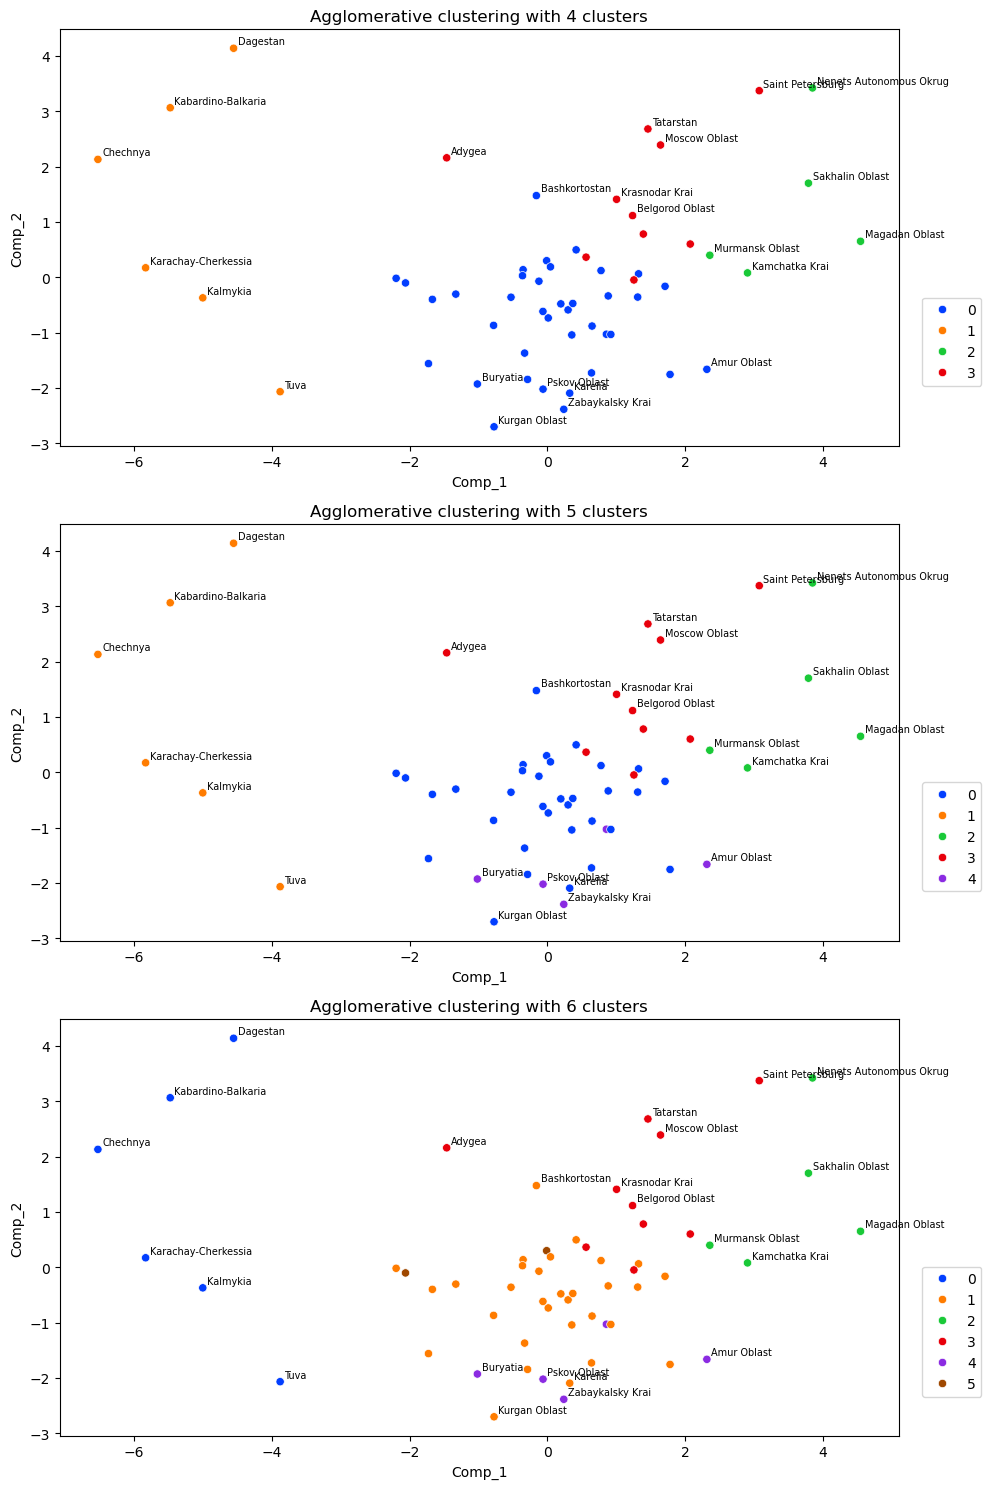

In [47]:
# Creating a funciton for plotting clusters
def annotated_plot(data, num_ax, num_clusters):
    plot = sns.scatterplot(data = data, x = "Comp_1", y = "Comp_2", hue = f"aggl_cluster_{num_clusters}", ax = axs[num_ax], palette = "bright")
    axs[num_ax].set_title(f"Agglomerative clustering with {num_clusters} clusters")
    axs[num_ax].legend(loc = "center left", bbox_to_anchor = (1.02, 0.25))
    for i, row in data.iterrows():
            if row["Comp_1"] < -4 or row["Comp_1"] > 2.2 or row["Comp_2"] > 1 or row["Comp_2"] < -1.9:
                plot.annotate(str(i), xy = (row["Comp_1"], row["Comp_2"]), xytext = (3, 3), textcoords = "offset points", fontsize = 7)

# Testing different numbers of clusters

fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 15))

for i in range(4, 7):
    annotated_plot(data = pca_clusters_df, num_ax = i - 4, num_clusters = i)

plt.tight_layout()
plt.show()

In the cases of 5 and 6 clusters, AgglomerativeClustering identifies a separate cluster (Cluster # 4) that appears to be "overrepresented" in areas where we can expect to see "depressive" regions. In both cases, this cluster includes Buryatia, Pskov Oblast, Zabaykalsky Krai and Amur Oblast. When we compare this group of regions to the "depressive" cluster identified in the results of Gaussian Mixture clustering, we find three overlapping regions:  Buryatia, Pskov Oblast and Zabaykalsky Krai. We will use these three regions for label propagation as "positive" cases.

Now we can proceed to determining negative cases. One way to do that is to 1) calculate the "mean" localization of the three "depressive" regions along the second principal component, 2) calculate distances between this average value and other regions' localizations along the second component, and 3) choose some number of the "farthest" regions as our "negative" cases.

In [48]:
depressive_regions = ["Buryatia", "Pskov Oblast", "Zabaykalsky Krai"]

# Calculating average coordinates of the "depressive" regions for the second principal component
depressive_regions_df = pca_clusters_df.loc[depressive_regions].iloc[:, 1:2]
centre_depr = np.array(depressive_regions_df.mean())

# Calculating the distance between every region and the "centre" of "depressive" regions
pca_clusters_df["distance_from_depr_reg"] = abs(pca_clusters_df["Comp_2"] - centre_depr)

In [49]:
# Sorting regions by the distance from the "centre" of depressive regions
pca_clusters_df["distance_from_depr_reg"].sort_values()

region_in_English
Karelia                    0.017653
Tuva                       0.044413
Pskov Oblast               0.090307
Buryatia                   0.183246
Khakassia                  0.266310
Zabaykalsky Krai           0.273553
Kemerovo Oblast            0.356466
Novgorod Oblast            0.383750
Amur Oblast                0.448577
Crimea Republic            0.551994
Kurgan Oblast              0.589975
Kostroma Oblast            0.741598
Vladimir Oblast            1.069904
Chelyabinsk Oblast         1.078761
Yaroslavl Oblast           1.082662
Irkutsk Oblast             1.230438
Ulyanovsk Oblast           1.242574
Tambov Oblast              1.376762
Bryansk Oblast             1.494805
Vologda Oblast             1.522497
Tomsk Oblast               1.631171
Arkhangelsk Oblast         1.638681
Mari El                    1.712626
Kalmykia                   1.740019
Udmurtia                   1.751192
Khabarovsk Krai            1.753902
Tula Oblast                1.774855
Stavropol 

Interestingly, our three regions occupy only 3rd, 4th and 6th places in this "rating". For the "negative" cases, we can select regions that are more than 2.5 units away from the center of the "depressive" regions. This seems reasonable, as it would be strange (on substantive grounds) to assume that relatively well-developed areas like Tyumen Oblast or Sverdlovsk Oblast may be assigned to the "depressive" cluster. Now we are ready to proceed with label propagation.

In [50]:
labels = np.full(data_clust.shape[0], -1) # Creating an array with labels

# Determining the indices of "positive" and "negative" cases:
nondepressive_regions = pca_clusters_df.query('distance_from_depr_reg > 2.5').index
labels_positive = [idx for idx, region in enumerate(pca_clusters_df.index) if region in depressive_regions]
labels_negative = [idx for idx, region in enumerate(pca_clusters_df.index) if region in nondepressive_regions]

# Finalizing the labels array
labels[labels_positive] = 1
labels[labels_negative] = 0

In [51]:
# Labels propagation
preproc_spreading = preprocessing.fit_transform(label_prop_feats)

label_spreading = LabelSpreading()
label_spreading.fit(preproc_spreading, labels)
pca_clusters_df["depressive_reg"] = label_spreading.transduction_

# This is out list of "depressive" regions
print(pca_clusters_df.query('depressive_reg == 1').index.to_list())

# Creating a dummy variable for "depressive" regions
workcopy_train["depressive_reg"] = pca_clusters_df["depressive_reg"]

['Kemerovo Oblast', 'Pskov Oblast', 'Karelia', 'Amur Oblast', 'Tuva', 'Zabaykalsky Krai', 'Kurgan Oblast', 'Buryatia']


We now have three dummy variables: Caucasian republics, the "cold Siberian periphery," and "depressive regions," which purport to capture important heterogeneity in our sample. Let's return to the exploratory analysis and examine the correlation matrix.

In [52]:
# Creating a dataframe for correlation analysis
for_corr_analysis = DataFrame(workcopy_train, 
                              columns = data_clust.columns.to_list() + ["log_density", "share_rural", "share_working_age_men"], 
                              index = workcopy_train.index)

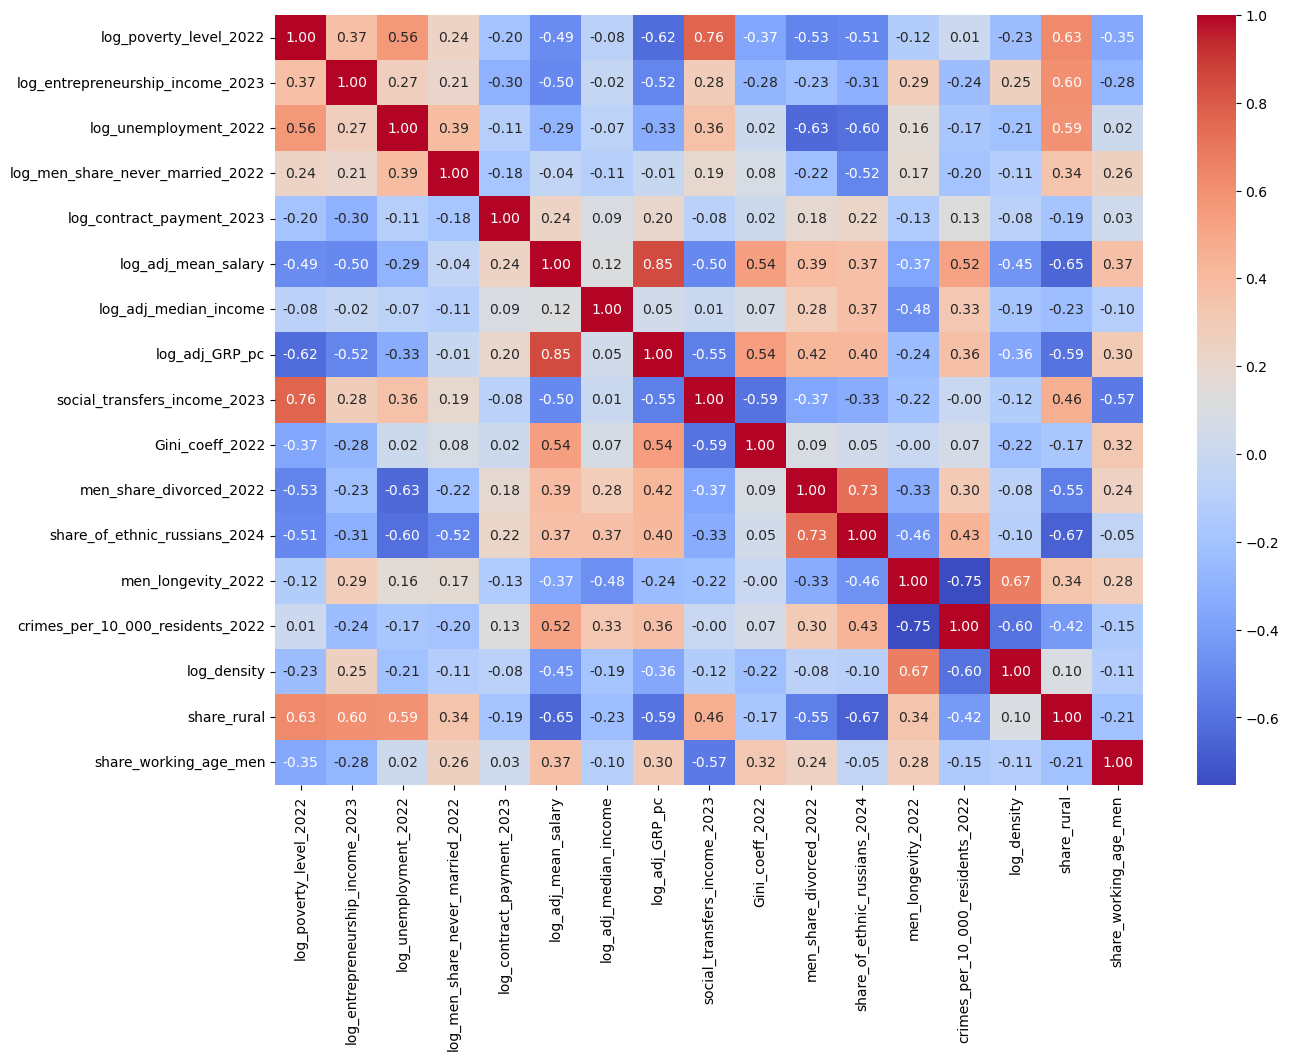

30 pairs with the highest correlation coefficients (by module):


In [53]:
# Correlation matrix heatmap

corr_matrix = for_corr_analysis.corr()

fig, ax = plt.subplots(figsize = (14, 10))

sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

# Retrieving 30 pairs with the highest correlation coefficients (by module)

mask = np.triu(np.ones_like(corr_matrix), k = 1).astype(bool)
triang_matrix = corr_matrix.where(mask).stack()
pairwise_corrs = DataFrame(triang_matrix).rename(columns = {0: "correlation_coeff"})
print("30 pairs with the highest correlation coefficients (by module):")
abs(pairwise_corrs["correlation_coeff"].round(3)).sort_values(ascending = False)[:30]

plt.show()

It’s clear that we shouldn't include both the log of adjusted mean salary and the log of adjusted GRP per capita as predictors, since they are highly correlated with each other. 

Next, let’s analyze the relationships between our features and the target variable.

In [54]:
# The correlations of the target with the features: Pearson's r and Spearman's r

# Pearson'r r:
num_vars = for_corr_analysis.copy()
num_vars["log_cas_rate"] = workcopy_train["log_cas_rate"].copy()
print("The target and the features: Pearson's r: \n")
print(num_vars.corr()["log_cas_rate"].sort_values()[:-1])

# Spearman's r:
spearmanr_dict = {}
for col in num_vars.columns:
    imputed_col = imputer.fit_transform(num_vars[[col]])
    r, pval = spearmanr(imputed_col, num_vars["log_cas_rate"])
    spearmanr_dict[col] = [np.round(r, 3), np.round(pval, 3)]

spearman_r_df = DataFrame({"feature": key, "Spearman's r": spearmanr_dict[key][0], 
                           "p-value": spearmanr_dict[key][1]} for key in spearmanr_dict.keys())

print("\n\nThe target and the features: Spearman's r: \n")
print(spearman_r_df.sort_values(by = "Spearman's r")[:-1])

The target and the features: Pearson's r: 

men_longevity_2022                 -0.692257
log_density                        -0.654790
share_working_age_men              -0.272802
log_entrepreneurship_income_2023   -0.200667
share_rural                        -0.093918
log_men_share_never_married_2022   -0.087220
men_share_divorced_2022             0.032640
Gini_coeff_2022                     0.040260
share_of_ethnic_russians_2024       0.040434
log_unemployment_2022               0.042632
log_contract_payment_2023           0.056719
log_adj_median_income               0.098344
log_adj_GRP_pc                      0.213863
log_poverty_level_2022              0.233788
social_transfers_income_2023        0.244141
log_adj_mean_salary                 0.265964
crimes_per_10_000_residents_2022    0.668125
Name: log_cas_rate, dtype: float64


The target and the features: Spearman's r: 

                             feature  Spearman's r  p-value
14                       log_density        -0.66

The correlation coefficients indicate that, among the numeric features, the logarithm of population density, life expectancy for men, and the number of crimes per 10,000 residents are the strongest candidates for being important predictors in the following analysis. Let's examine scatter plots.

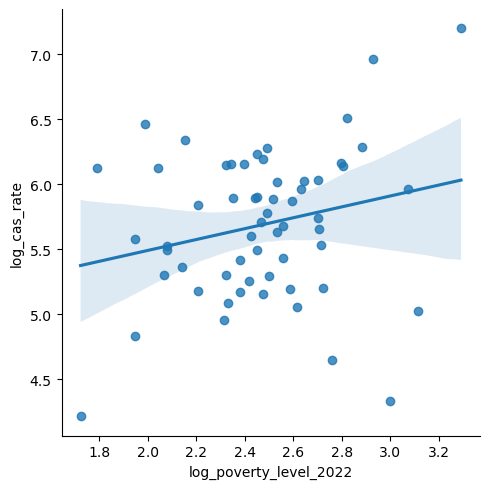

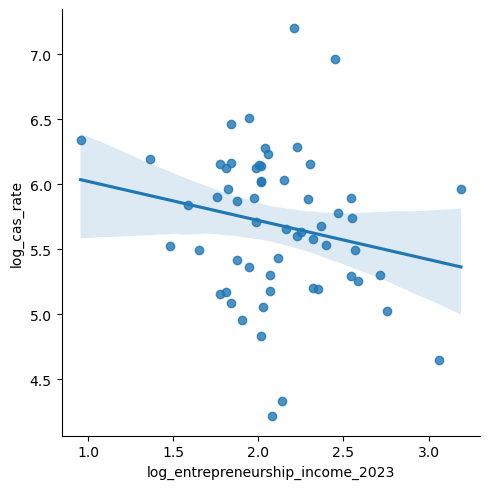

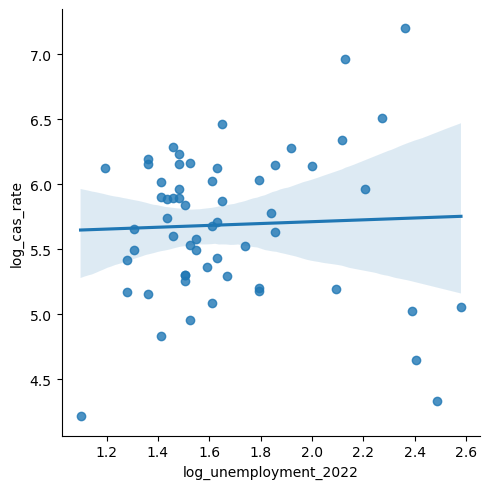

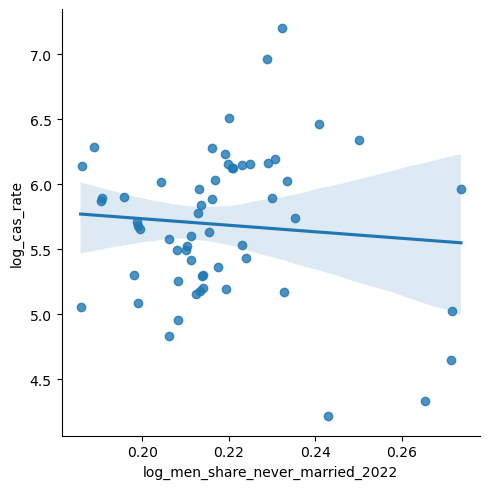

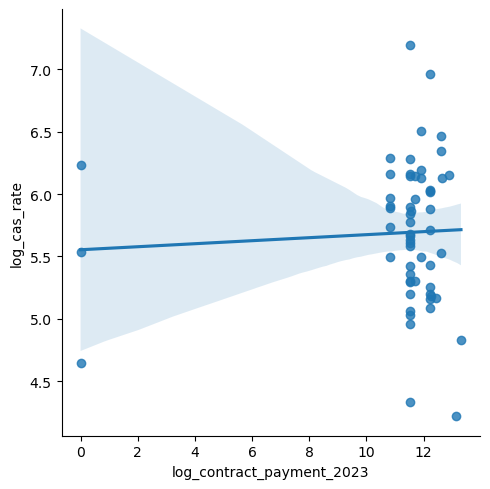

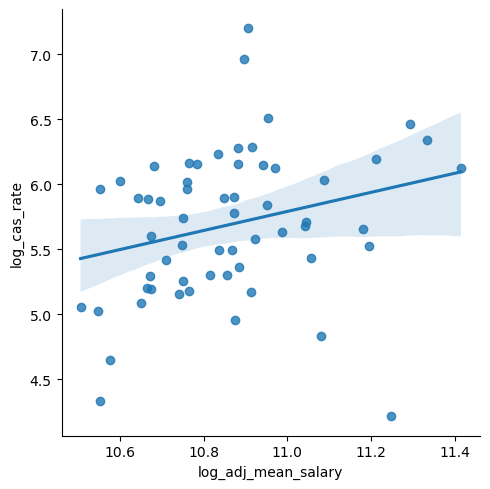

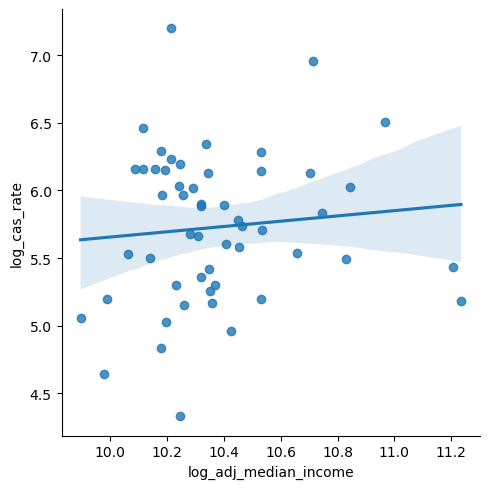

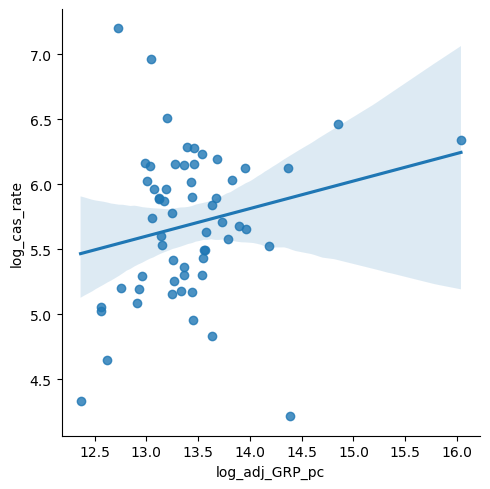

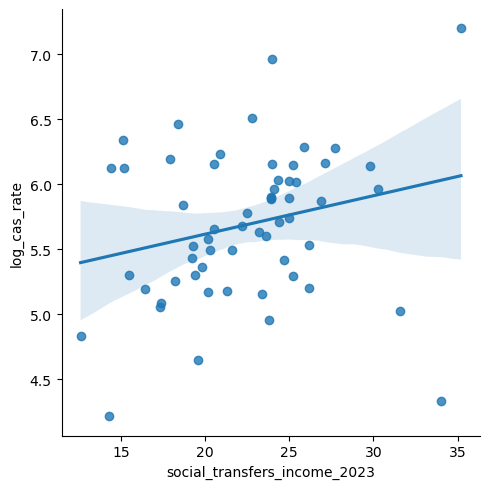

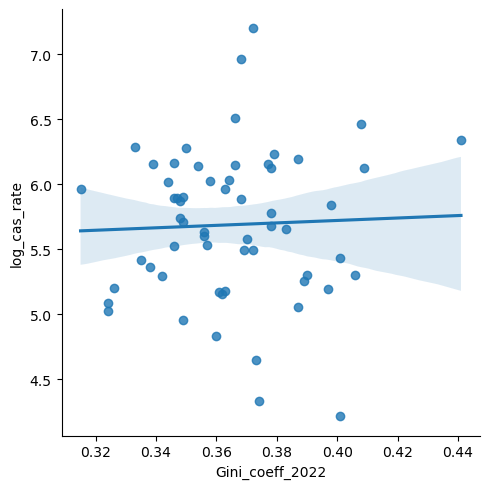

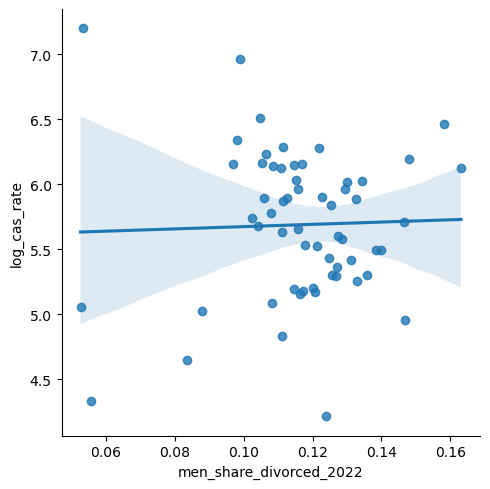

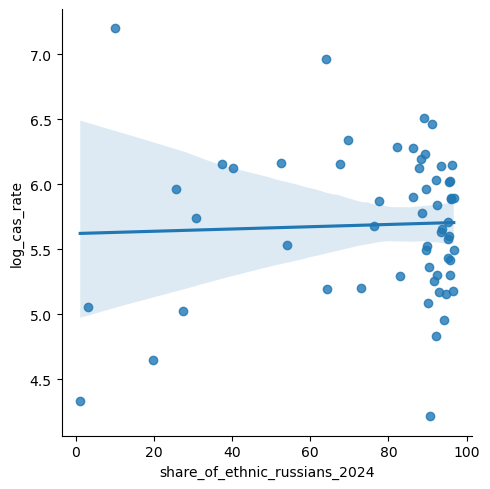

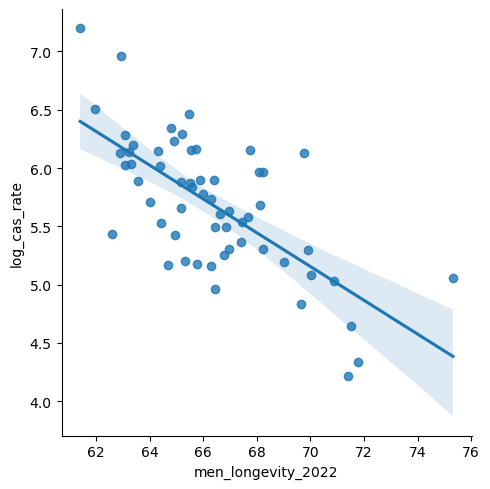

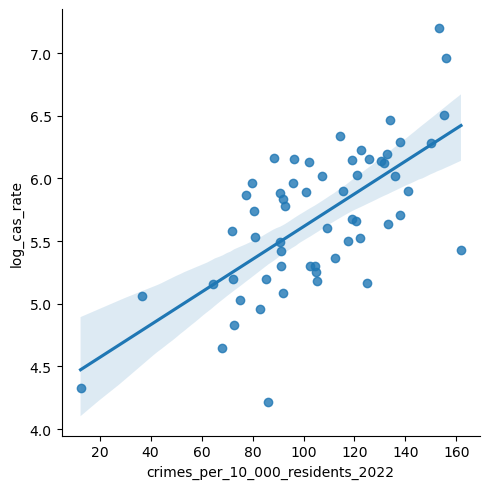

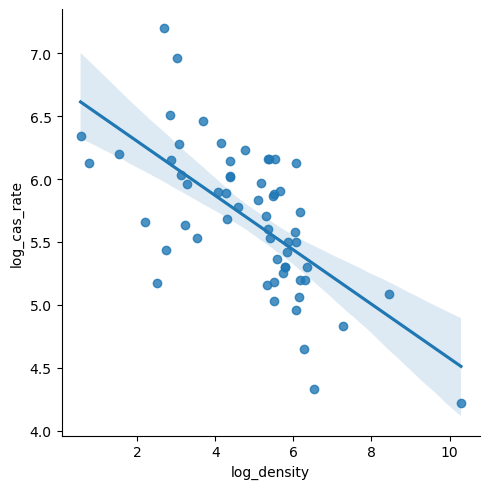

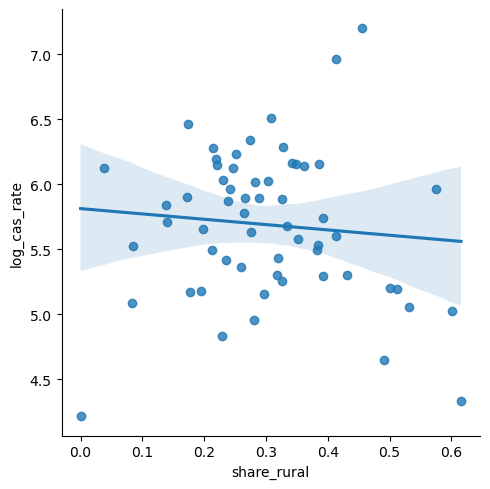

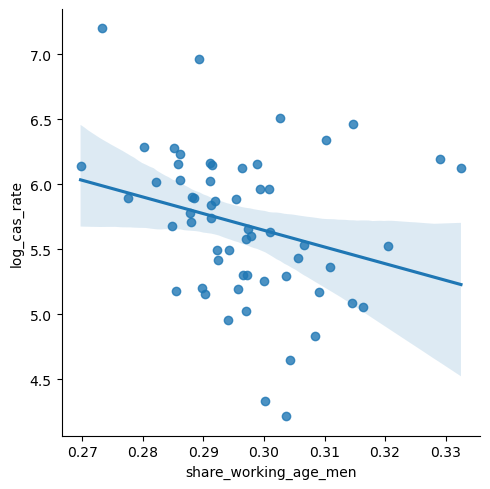

In [55]:
for col in num_vars.columns[:-1]:
    sns.lmplot(data = num_vars, x = col, y = "log_cas_rate")

plt.show()

The visual analysis of the scatter plot corroborates the conclusions from the correlation analysis: the same three features obviously perform better than others.

At the same time, it may be useful to create some meaningful interaction terms which have the potential to push some patterns observed above into greater relief. To highlight some guiding principles behind these interaction terms, it is useful to introduce some conceptual distinctions. The first distinction is concerned with the type of conditions which might facilitate recruitment in the Russian army. The first set of conditions is related to what we may call macro- or "region-level" conditions, which promote higher conscription rates and subsequently lead to increased casualty rates. . I associate this kind of conditions with "structural" explanations of political and bureaucratic nature. In contrast, the second set focuses on micro- or "individual-level" factors, which are tied to socio-economic conditions, as these ultimately manifest in the personal circumstances of individuals.

There are two main channels for recruiting soldiers in the Russian army: 1) coercive mobilization, which began with the announcement of "partial mobilization" in September 2022; and 2) enlistment by contract, which offers substantial payments and high salaries to those who sign. 

Thus, we have two types of facilitating conditions ("region-level" and "individual-level") and two types of recruitment channels (coercive mobilization and volunteer recruitment with very substantial material incentives). Theoretically, these variables can intersect resulting in a 2-by-2 matrix:
1) "region-level" conditions facilitating coercive mobilization;
2) "region-level" conditions facilitating volunteer recruitment with material incentives;
3) "individual-level" conditions facilitating coercive mobilization;
4) "individual-level" conditions facilitating volunteer recruitment with material incentives.

All four conbinations might be important. However, combinations (1) and (4) appear more obvious and heuristically powerful. I will briefly discuss the logic behind them below.

A. "Region-level" conditions facilitating coercive mobilization. 

Certain regions may contribute more soldiers to the Russian army due to their political vulnerability to the wartime political economy logic. It is clear that the federal center (the Russian federal government in the broad sense of the term) exerts pressure on regional authorities regarding soldier recruitment. But it is quite probable that this pressure varies depending on particular contexts. At least three considerations may be relevant in this regard:
1) High mobilization rates create tensions that can have politically undesired consequences. Therefore, active mobilization should be directed towards regions that are either politically insignificant for the federal government or where society lacks the organizational resources to pressure local authorities against mobilization. In this logic, "peripheral" regions distant from major cities like Moscow and St. Petersburg are particularly susceptible to mobilization efforts. The same applies to regions with weak or sparse social networks and low levels of social capital, as these local societies may be unable to resist mobilization (for instance, there were such protests in Dagestan [[1]](https://zona.media/article/2022/09/25/dagestan)).
2) It would be ill-advised to dismiss the possibility that some kind of "imperial" logic is also active in Russian recruitment policies. Some researchers suggest that the Russian government employs "a time-tested imperial tactic of military recruitment from the peripheries" [[Driscoll, Sichinava, Berglund]](https://www.tandfonline.com/doi/full/10.1080/1060586X.2025.2484150). This observation aligns with findings that ethnic minorities are disproportionately hit by this war. [[Vyushkova, Sherkhonov]](https://brill.com/view/journals/inas/25/1/article-p126_11.xml). It implies the possibility of existence of another layer of "periphery" in the Kremlin's possibly "imperial" or quasi-imperial perspective, which includes regions with significant populations of ethnic minorities.
3) Additionally, administrative effectiveness may play a role. All others held equal, it makes sense to assume that sparsely populated regions and rural areas offer fewer opportunities to evade coercive mobilization - in contrast to major cities where individuals have better chances to keep out of sight of military recruitment offices.

These three considerations do not encompass all possible factors, but they do indicate that certain regional characteristics can be significant for analysis. One variable that effectively reflects a substantial share of these characteristics is population density. This variable aligns with the logic of the first consideration, as sparsely populated regions tend to be less politically significant to the federal government and are often located far from Moscow. Additionally, these regions typically lack dense social networks and a vibrant civil society that could withstand mobilization efforts. finally, it is more difficult to avoid the attention of recruitment authorities in sparsely populated areas. 

The second relevant variable is the share of ethnically Russian population (and its inverse - the share of ethnic minorities) which refects the logic behind consideration # 2. 

B. "Individual-level" conditions facilitating volunteer recruitment with material incentives.

In this context, two factors are particularly relevant: the voluntary nature of recruitment and the significant material incentives. The latter suggests that economic conditions may play an important role.  Thus, we may expect that:
1) Mobilization rates may be higher in the regions with higher poverty level.
2) Beyond purely economic factors, a precarious life situation can also influence recruitment. A low level of general well-being may lead individuals to consider signing a contract as a potential escape from difficult circumstances, especially when other options are limited. Crime rates can partially capture this logic, particularly for ex-prisoners who may face challenges reintegrating into civilian life (it's also well known that Russian authorities actively recruit from prisons; this is a consideration that makes crime rates potentially relevant for coercive mobilization from prisons). Life expectancy among men is another variable that can indicate the overall level of well-being.
3) Finally, susceptibility to state propaganda may be another critical factor. The level of education (or, on the region level, the share of the adult male population with higher education) may serve as a proxy for this characteristic.

All these factors may interact with each other creating additional layers of incentives or circumstances facilitating recruitment into the Russian army. It is therefore useful to create some new interaction terms between the variables reflecting these factors, in line with the considerations outlined above.

Thus, we may introduce interaction terms between the following variables:
1) population density and the share of ethnically Russian population (the higher the value of this interaction term, the weaker recruitment in the army might be, and hence the lower casualty rate);
2) crimes rate and the share of ethnic minorities (the higher the value of this interaction term, the higher casualty rate, accoring to our hypotheses);
3) (100 years - men life expectancy) and crimes rate (the higher the value of this interaction term, the higher casualty rate, accoring to our hypotheses);
4) poverty level and (100% - the share of men with higher education) (the higher the value of this interaction term, the higher casualty rate, accoring to our hypotheses);
5) population density and (100% - poverty level) (the higher the value of this interaction term, the lower casualty rate, accoring to our hypotheses);
6) population density and (maximum crime rate in the sample minus crime rate in the given region) (the higher the value of this interaction term, the lower casualty rate, accoring to our hypotheses).

Certainly, we may have created other interaction terms as well, but we have to stop somewhere because our sample size is small.

In [56]:
# Creating interaction terms described above
workcopy_train["density_ethnic"] = workcopy_train["log_density"] * workcopy_train["share_of_ethnic_russians_2024"] # 1

workcopy_train["minorities_crimes"] = (workcopy_train["crimes_per_10_000_residents_2022"] * 
    (100 - workcopy_train["share_of_ethnic_russians_2024"]) 
                                      ) # 2

workcopy_train["longevity_crimes"] = (workcopy_train["crimes_per_10_000_residents_2022"] *
    (workcopy_train["men_longevity_2022"].max() - workcopy_train["men_longevity_2022"]) 
                                     ) # 3

workcopy_train["pov_educ"] = workcopy_train["poverty_level_2022"] * (100 - workcopy_train["men_higher_educ_2020"]) # 4

workcopy_train["density_poverty"] = workcopy_train["log_density"] * np.log(100 - workcopy_train["poverty_level_2022"]) # 5

workcopy_train["density_crimes"] = workcopy_train["log_density"] * (workcopy_train["crimes_per_10_000_residents_2022"].max() + 1 -
                                                                    workcopy_train["crimes_per_10_000_residents_2022"]) # 6

Skew of density_ethnic = 0.146
Skew of minorities_crimes = 2.62
Skew of longevity_crimes = 0.318
Skew of pov_educ = 1.072
Skew of density_poverty = 0.002
Skew of density_crimes = 0.723


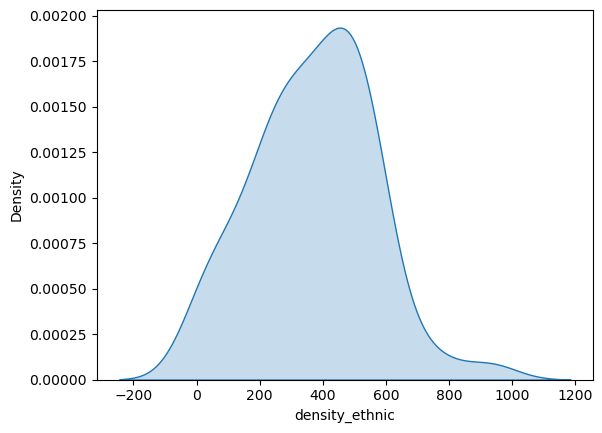

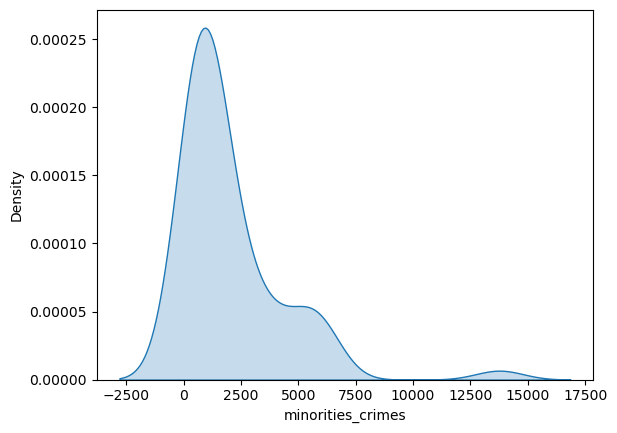

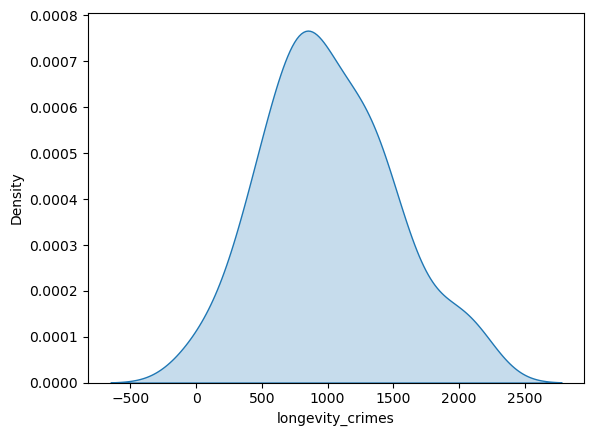

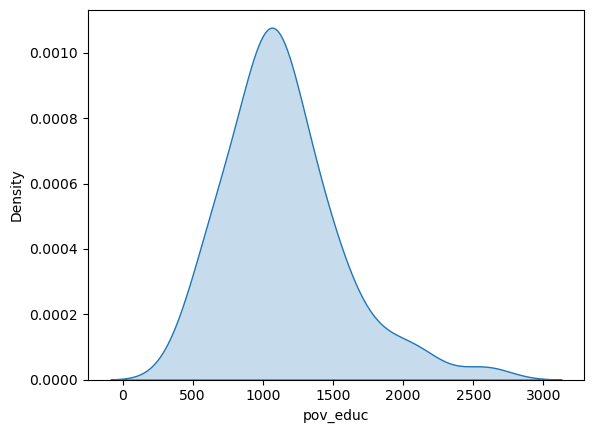

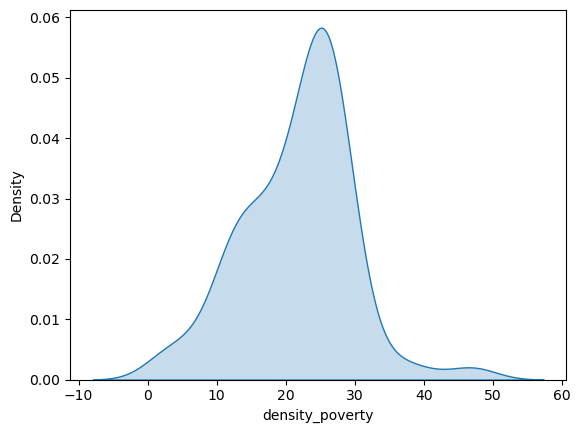

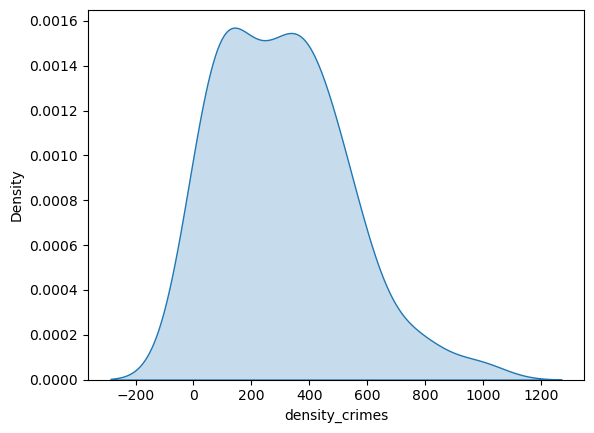

In [57]:
# Checking the distribution of new interaction terms

new_interaction_terms = ["density_ethnic", "minorities_crimes", "longevity_crimes", "pov_educ", "density_poverty", "density_crimes"] 
new_interaction_terms_df = DataFrame(workcopy_train, columns = new_interaction_terms, index = workcopy_train.index)

for col in new_interaction_terms_df.columns:
    fig, ax = plt.subplots()
    sns.kdeplot(data = new_interaction_terms_df, x = col, fill = True)
    print(f"Skew of {col} = {skew(new_interaction_terms_df[col]).round(3)}")

plt.show()

Given the skewness and distribution of the new variables, it's worth creating log-transformed versions of "minorities_crimes" and "pov_educ" features.

In [58]:
workcopy_train["log_minorities_crimes"] = np.log(workcopy_train["minorities_crimes"])
workcopy_train["log_pov_educ"] = np.log(workcopy_train["pov_educ"])

Let's proceed to discuss categorical features.

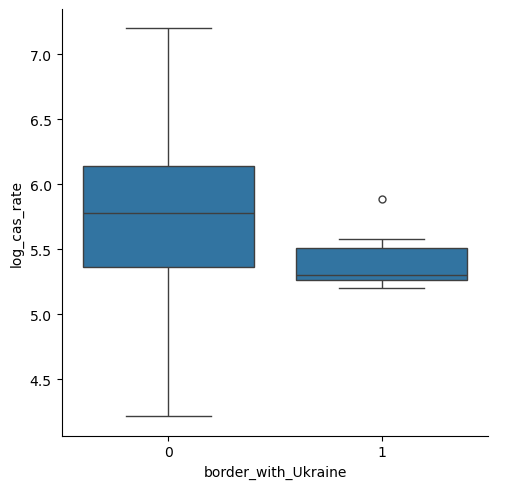

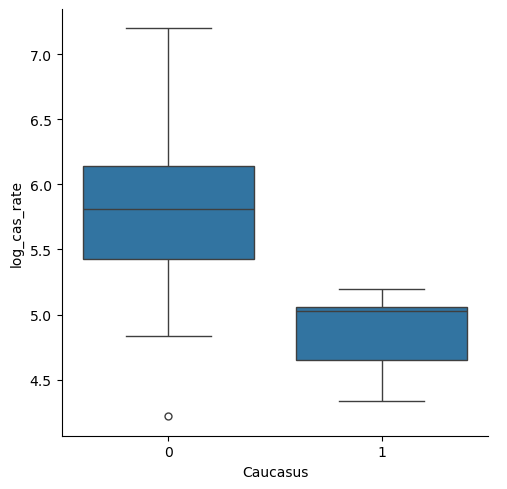

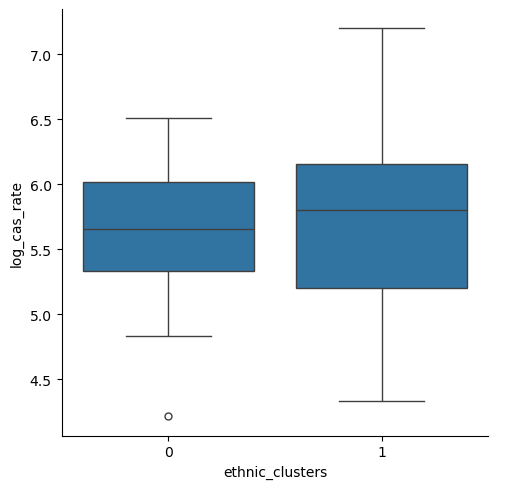

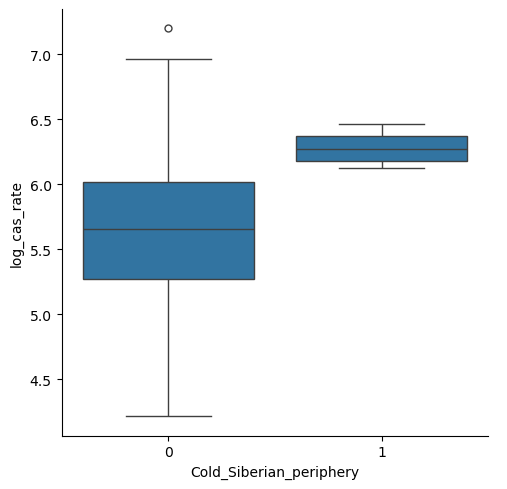

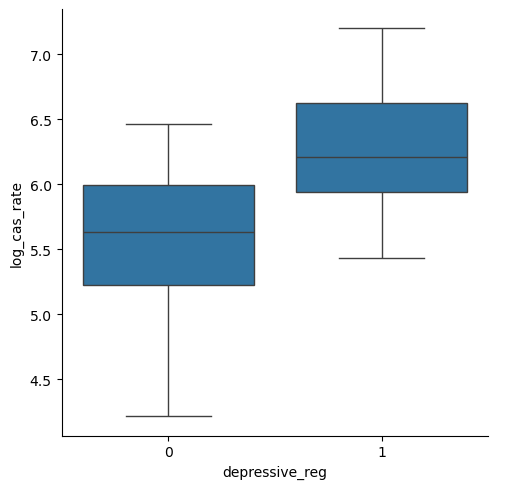

In [59]:
# Creating a dataframe of categorical features and the target
categorical = ['border_with_Ukraine', 'Caucasus', 'ethnic_clusters', 'Cold_Siberian_periphery', 'depressive_reg']
cat_vars = DataFrame(workcopy_train, columns = categorical + ["log_cas_rate"], index = workcopy_train.index)

# Plotting the relationships between categorical features and the target
for col in cat_vars.columns[:-1]:
    sns.catplot(data = cat_vars, x = col, y = "log_cas_rate", kind = "box")

"Caucasus", "Cold_Siberian_periphery" and, to a lesser extent, "depressive_reg" appear to be promising predictors.

Now, once we have identified the most promising numeric and categorical predictors, it is interesting to examine their interactions.

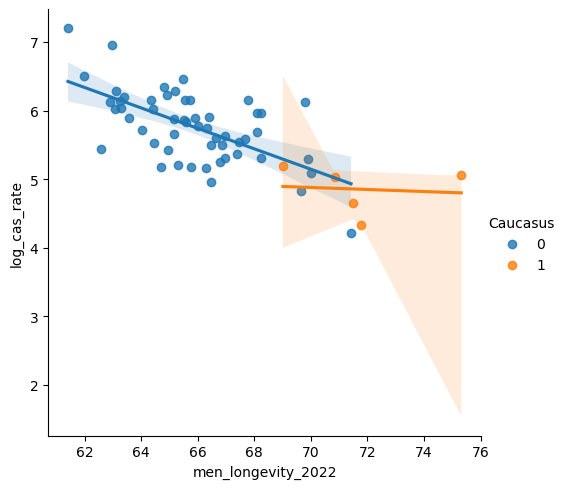

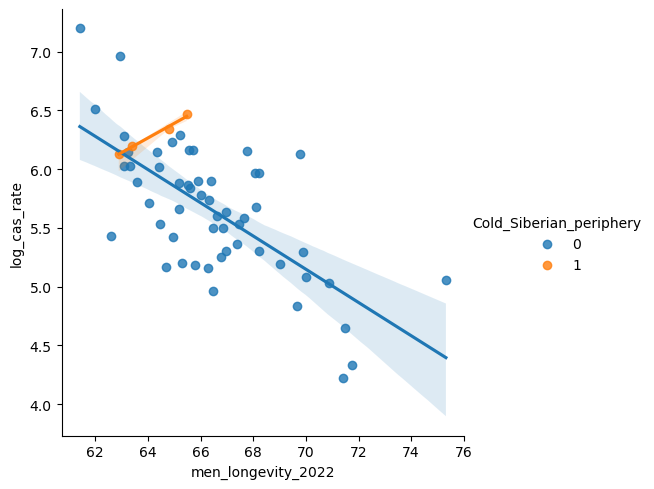

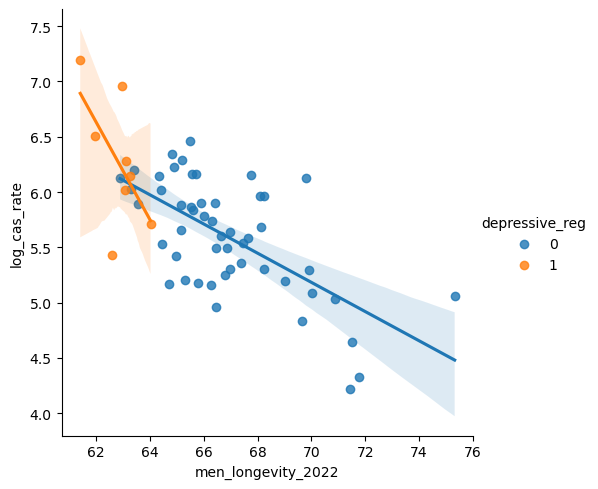

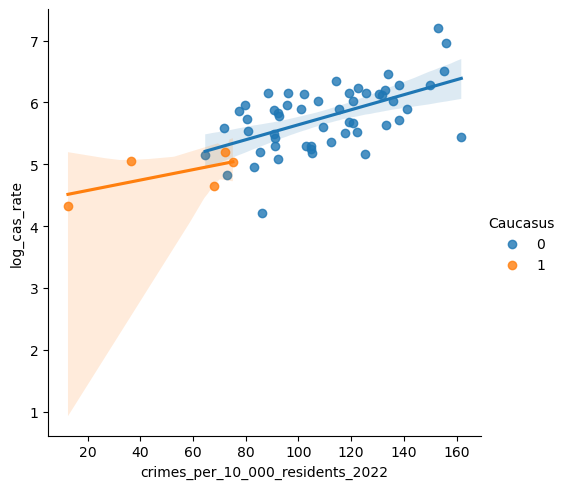

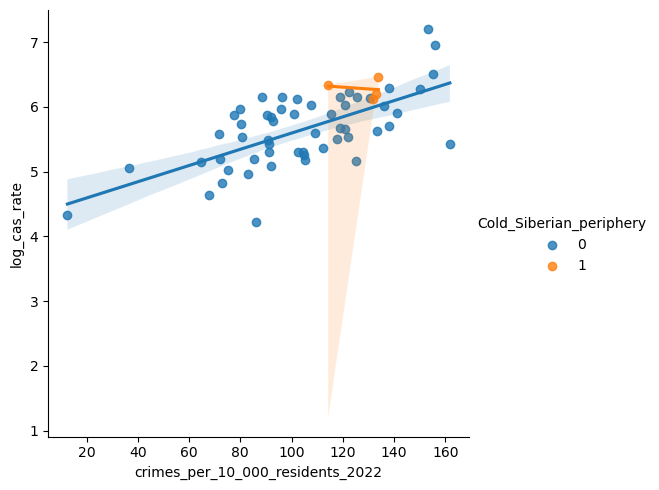

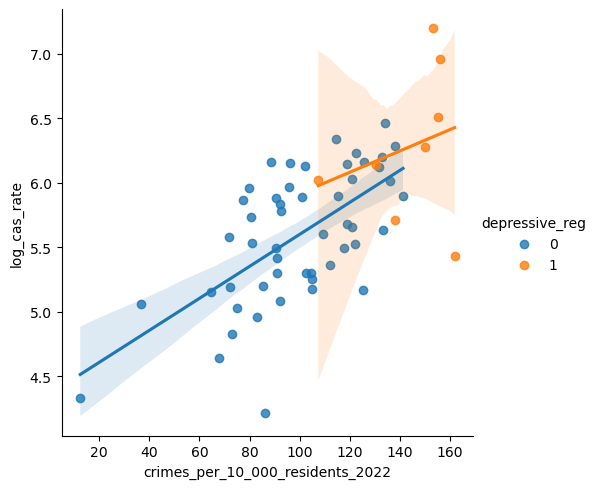

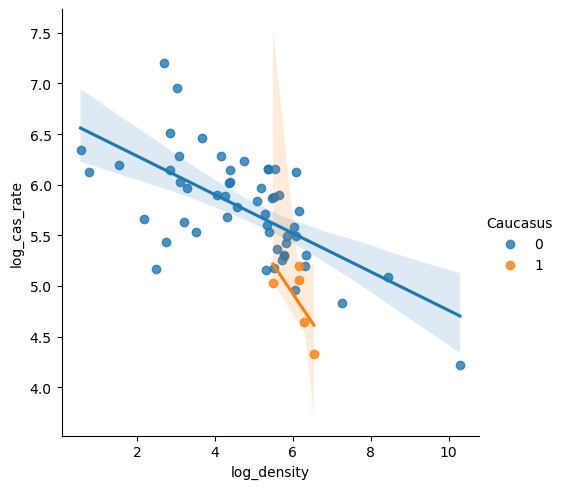

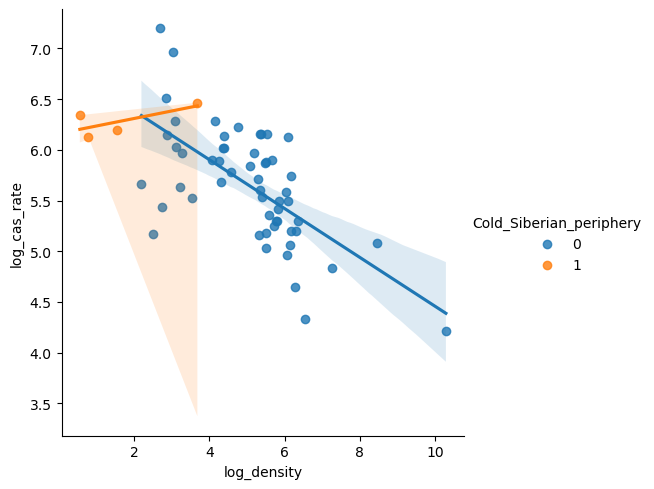

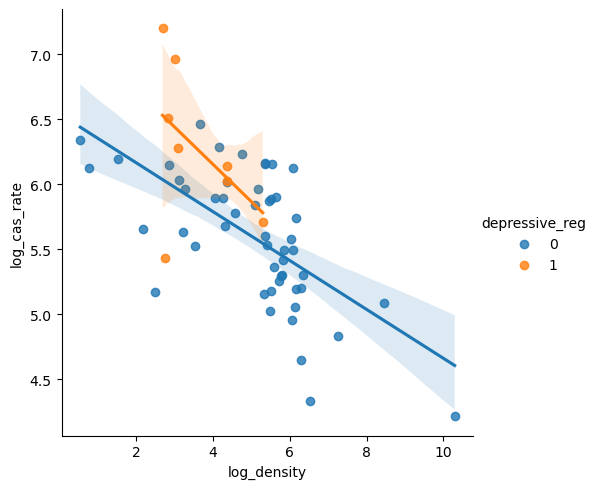

In [60]:
# Creating a dataframe with all types of predictors
all_vars = pd.merge(num_vars, cat_vars.iloc[:, :-1], left_index = True, right_index = True)
num_ = ['men_longevity_2022', 'crimes_per_10_000_residents_2022', 'log_density']
cat_ = ['Caucasus', 'Cold_Siberian_periphery', 'depressive_reg']

# Plotting relationships between basic features and the target to identify interactions between basic numeric and categorical features
for num_feature in num_:
    for cat_feature in cat_:
        sns.lmplot(data = all_vars, x = num_feature, y = "log_cas_rate", hue = cat_feature)

The results are intriguing because they suggest that certain interaction terms might be useful due to the peculiar slopes of the regression lines.
To be more precise, the following interactions terms are promising:
1. men_longevity_2022 and Cold_Siberian_periphery;
2. men_longevity_2022 and depressive_reg

In [61]:
# Creating new interaction terms
workcopy_train["longevity_sib_periphery"] = workcopy_train["men_longevity_2022"] * workcopy_train["Cold_Siberian_periphery"]
workcopy_train["longevity_depressive"] = workcopy_train["men_longevity_2022"] * workcopy_train["depressive_reg"]

In [62]:
list(enumerate(workcopy_train.columns))

[(0, 'region_in_Russian'),
 (1, 'poverty_level_2022'),
 (2, 'entrepreneurship_income_2023'),
 (3, 'social_transfers_income_2023'),
 (4, 'mean_salary_2022'),
 (5, 'median_income_2022'),
 (6, 'Gini_coeff_2022'),
 (7, 'decile_coeff_2022'),
 (8, 'GRP_pc_2022'),
 (9, 'unemployment_2022'),
 (10, 'men_working_age_total_2022'),
 (11, 'relative_cost_of_living_2022'),
 (12, 'men_higher_educ_2020'),
 (13, 'population_2022'),
 (14, 'men_share_never_married_2022'),
 (15, 'men_share_divorced_2022'),
 (16, 'share_of_ethnic_russians_2024'),
 (17, 'men_longevity_2022'),
 (18, 'men_working_age_rural_2022'),
 (19, 'crimes_per_10_000_residents_2022'),
 (20, 'border_with_Ukraine'),
 (21, 'contract_payment_2023'),
 (22, 'square_km^2'),
 (23, 'Caucasus'),
 (24, 'casualties_mid_july_2025'),
 (25, 'fed_district'),
 (26, 'casualties_rate'),
 (27, 'log_cas_rate'),
 (28, 'log_density'),
 (29, 'ethnic_clusters'),
 (30, 'adj_mean_salary'),
 (31, 'adj_median_income'),
 (32, 'adj_GRP_pc'),
 (33, 'share_rural'),
 (34,

In [63]:
# Combining all predictors in one dataframe
columns_to_include = (workcopy_train.columns.to_list()[3:4] + 
    workcopy_train.columns.to_list()[6:7] + workcopy_train.columns.to_list()[12:13] + 
    workcopy_train.columns.to_list()[15:18] + workcopy_train.columns.to_list()[19:21] + 
    workcopy_train.columns.to_list()[23:24] + workcopy_train.columns.to_list()[28:30] +
    workcopy_train.columns.to_list()[33:46] + workcopy_train.columns.to_list()[47:48] +
    workcopy_train.columns.to_list()[49:]
                     )

all_predictors = DataFrame(workcopy_train, columns = columns_to_include, index = workcopy_train.index) 

print(f"Total number of potential predictors = {len(all_predictors.columns)}")

Total number of potential predictors = 31


## III. Selecting features

Our train set comprises 59 observations, and the number of potential predictors is 31. The observations-predictors ratio is very low. It is necessary to select predictors. A commonly accepted rule of thumb is that the ideal observations-to-predictors ratio is approximately 10, suggesting we should aim for no more than 6 predictors. 

One of the possible strategies to select predictors is the following one:
1. Narrowing down the set of predictors to 10-15 via SelectKBest method;
2. Implementing some simple models (linear and based on decision trees, albeit heavily regularized to limit complexity) to assess the importance of various predictors from the reduced set.
3. Narrowing down the set of predictors further via recursive elimination of features with cross-validation (RFECV) if the previous steps do not yield clear results.
4. Selecting final features based on the insights from the previous steps.

In [64]:
# Creating a separate target variable
target = workcopy_train["log_cas_rate"]

# Narrowing down the set of potential predictors via SelectKBest method
selector = make_pipeline(preprocessing, SelectKBest(score_func = f_regression, k = 10))
selector.fit(all_predictors, target)
sel_k_best = selector.named_steps["selectkbest"]
selected_features = all_predictors.columns[sel_k_best.get_support()]
print(f"Features selected by SelectKBest: \n\n: {selected_features}")

Features selected by SelectKBest: 

: Index(['men_higher_educ_2020', 'men_longevity_2022',
       'crimes_per_10_000_residents_2022', 'Caucasus', 'log_density',
       'depressive_reg', 'longevity_crimes', 'density_poverty',
       'density_crimes', 'longevity_depressive'],
      dtype='object')


Since some selected features are interaction terms, it is important to also include the "original" features that were used to create these interaction terms (the poverty level).

In [65]:
selected_features_fin = list(selected_features) + ["log_poverty_level_2022"]

In [66]:
# Creating a dataframe with the reduced set of predictors
reduced_predictors = DataFrame(workcopy_train, columns = selected_features_fin, index = workcopy_train.index)

Now we may quickly fit some models to our data in order to understand which predictors from the reduced set turn out to be the most important. Given our sample size, it's worthwhile to use regularized and/or robust models. Additionally, using different types of models can help highlight various aspects of the data and address each other's weaknesses in subsequent stages of the analysis.

Thus, we can choose:
1. Linear models: Ridge, Lasso and ElasticNet and HuberRegressor.
2. Heavily regularized versions of the models based on decision trees: DecisionTreeRegressor and ensemble models, such as RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor and GradientBoostingRegressor.

In [67]:
# Initializing models with hyperparameters providing sufficient regularization

ridge_reg = make_pipeline(preprocessing, Ridge())
lasso_reg = make_pipeline(preprocessing, Lasso())
elasticnet_reg = make_pipeline(preprocessing, ElasticNet(max_iter=1000))
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(max_depth = 3, max_features = "sqrt"))
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(n_estimators = 20, max_depth = 3, max_features = "sqrt", random_state=42))
huber_reg = make_pipeline(preprocessing, HuberRegressor(max_iter=1000))
extra_reg = make_pipeline(preprocessing, ExtraTreesRegressor(n_estimators = 20, max_depth = 3, max_features = "sqrt", random_state=42))
adaboost_reg = make_pipeline(preprocessing, AdaBoostRegressor(n_estimators = 10, random_state=42))
gradboost_reg = make_pipeline(preprocessing, GradientBoostingRegressor(n_estimators = 10, max_depth = 3, max_features = "sqrt", random_state=42))

In [68]:
# Creating a dataframe with predictors' coefficients or importances
predictors_weights_df = DataFrame(reduced_predictors.columns, columns = ["predictor"]).set_index("predictor")

# Fitting models to evaluate predictors' coefficients or importances

linear_models = [ridge_reg, lasso_reg, elasticnet_reg, huber_reg]
other_models = [tree_reg, forest_reg, extra_reg, adaboost_reg, gradboost_reg]

for model in linear_models:
    model.fit(reduced_predictors, target)
    lin_model = model.named_steps[str.lower(model.steps[-1][1].__class__.__name__)]
    predictors_weights_df[f"{model.steps[-1][1].__class__.__name__}"] = lin_model.coef_

for model in other_models:
    model.fit(reduced_predictors, target)
    nonlin_model = model.named_steps[str.lower(model.steps[-1][1].__class__.__name__)]
    predictors_weights_df[f"{model.steps[-1][1].__class__.__name__}"] = nonlin_model.feature_importances_

# Sorting predictors by coefficients or importances for each model
for col in predictors_weights_df.columns:
    print(f"\n\n{col}: \n{predictors_weights_df[col].sort_values()}")



Ridge: 
predictor
density_crimes                     -0.194775
Caucasus                           -0.141173
men_higher_educ_2020               -0.123636
density_poverty                    -0.060107
log_density                        -0.040260
longevity_depressive               -0.008289
longevity_crimes                    0.007701
crimes_per_10_000_residents_2022    0.021267
men_longevity_2022                  0.022608
depressive_reg                      0.040091
log_poverty_level_2022              0.077253
Name: Ridge, dtype: float64


Lasso: 
predictor
men_higher_educ_2020               -0.0
men_longevity_2022                 -0.0
crimes_per_10_000_residents_2022    0.0
Caucasus                           -0.0
log_density                        -0.0
depressive_reg                      0.0
longevity_crimes                    0.0
density_poverty                    -0.0
density_crimes                     -0.0
longevity_depressive                0.0
log_poverty_level_2022              0

The results are quite ambiguous. It may be beneficial to include "density_crimes" in the final set of predictors, which would also mean including "crimes_per_10_000_residents_2022" and "log_density." However, the situation regarding the other predictors remains largely unclear.

To finalize the selection of predictors, we will need to take some additional steps. We can try using recursive feature elimination with cross-validation (RFECV) and, in addition, assess the performance of various models with different subsets of predictors.

In [69]:
# Selecting features based on recursive features elimination

for i in range(3, 11):
    rfecv = make_pipeline(preprocessing, RFECV(estimator=Ridge(), cv=i))
    rfecv.fit(reduced_predictors, target)
    rfecv_ = rfecv.named_steps["rfecv"]
    selected_features_rfecv = reduced_predictors.columns[rfecv_.get_support()]
    print(f"CV = {i}: selected features: {selected_features_rfecv.to_list()}")

CV = 3: selected features: ['men_higher_educ_2020', 'density_crimes']
CV = 4: selected features: ['density_crimes']
CV = 5: selected features: ['men_higher_educ_2020', 'density_crimes']
CV = 6: selected features: ['men_higher_educ_2020', 'density_crimes']
CV = 7: selected features: ['density_crimes']
CV = 8: selected features: ['men_higher_educ_2020', 'Caucasus', 'log_density', 'density_poverty', 'density_crimes', 'log_poverty_level_2022']
CV = 9: selected features: ['men_higher_educ_2020', 'density_crimes']
CV = 10: selected features: ['men_higher_educ_2020', 'Caucasus', 'log_density', 'density_poverty', 'density_crimes', 'log_poverty_level_2022']


Two features— the percentage of men with higher education and the interaction term "density_crimes"—are included in the vast majority of these subsets of predictors. We can consider them our two core predictors. However, since "density_crimes" is an interaction term that involves two original features (the crime rate and the logarithm of population density), we should also include these two original features in our core set of predictors. 

In [70]:
selected_features_rfecv_enhanced = ['men_higher_educ_2020', 'density_crimes', 'log_density', 'crimes_per_10_000_residents_2022']

In [71]:
# Finalizing the core set of predictors
predictors_core = DataFrame(workcopy_train, columns = selected_features_rfecv_enhanced, index = workcopy_train.index)
predictors_core.head()

men_higher_educ_2020  density_crimes  log_density  \
region_in_English                                                      
Sevastopol                     0.417480      597.518031     8.451457   
Tambov Oblast                  0.224798      286.056423     5.346849   
Ulyanovsk Oblast               0.233320      466.907893     5.467306   
Saratov Oblast                 0.251827      347.481978     5.178569   
Magadan Oblast                 0.295341       24.115006     0.775402   

                   crimes_per_10_000_residents_2022  
region_in_English                                    
Sevastopol                                     92.1  
Tambov Oblast                                 109.3  
Ulyanovsk Oblast                               77.4  
Saratov Oblast                                 95.7  
Magadan Oblast                                131.7

Let's evaluate the performance of models using this reduced set of predictors. At this stage, we can introduce some new models to enhance the diversity of our model set. These include RANSACRegression as another robust linear model, along with two models of entirely different types: SVR as a support vector machine model and KNeighborsRegressor as a nonparametric model.

In [72]:
# Initializing new models
svr = make_pipeline(preprocessing, SVR())
ransac_reg = make_pipeline(preprocessing, RANSACRegressor())
kneighb_reg = make_pipeline(preprocessing, KNeighborsRegressor())

Let's assess the performance of our untuned models on the dataset of our core predictors.

In [73]:
# Creating a function which would yield a dataframe with the performance of models

def model_performance(models_predictors_dict, scoring, cv):
    models_performance_dict = {}
    for model in models_predictors_dict.keys():
        if scoring == corr_scorer: 
            models_performance_dict[model.steps[-1][1].__class__.__name__] = cross_val_score(model, models_predictors_dict[model], target, 
                                                                                        cv = cv, scoring = scoring).mean().round(3)
            
        else: 
            models_performance_dict[model.steps[-1][1].__class__.__name__] = -cross_val_score(model, models_predictors_dict[model], target, 
                                                                                        cv = cv, scoring = scoring).mean().round(3)
    return models_performance_dict

In [74]:
# Performance of our models on the predictors_core dataframe

# Creating a models-cum-predictors dictionary
models = [ridge_reg, lasso_reg, elasticnet_reg, tree_reg, forest_reg, svr, huber_reg, ransac_reg, 
          extra_reg, adaboost_reg, gradboost_reg, kneighb_reg]

models_predictors_dict = {}
for model in models:
    models_predictors_dict[model] = predictors_core

# Creating a Person's r scorer (in addition to rmse and mae as metrics)
def pearson_scorer(x, y):
    r, _ = pearsonr(x, y)
    return r

corr_scorer = make_scorer(pearson_scorer)

# Creating a dataframe for models performance results
models_names = [model.steps[-1][1].__class__.__name__ for model in models]

performance_df = DataFrame(index = models_names)

# Calculating models performance across 3 different metrics
metrics_dict = {"rmse": "neg_root_mean_squared_error", "r": corr_scorer, "mae": "neg_median_absolute_error"}

for key in metrics_dict.keys():
    performance_df[key] = model_performance(models_predictors_dict = models_predictors_dict, scoring = metrics_dict[key], cv = 5)

performance_df

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27736\3574514642.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(x, y)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27736\3574514642.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(x, y)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27736\3574514642.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(x, y)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27736\3574514642.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(x, y)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27736\3574514642.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(x, y)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27736\3574514642.py:13: Constant

rmse      r    mae
Ridge                      0.365  0.718  0.228
Lasso                      0.556    NaN  0.421
ElasticNet                 0.556    NaN  0.421
DecisionTreeRegressor      0.515  0.602  0.302
RandomForestRegressor      0.417  0.639  0.264
SVR                        0.449  0.622  0.299
HuberRegressor             0.368  0.718  0.231
RANSACRegressor            0.437  0.443  0.322
ExtraTreesRegressor        0.397  0.669  0.272
AdaBoostRegressor          0.473  0.541  0.332
GradientBoostingRegressor  0.432  0.625  0.318
KNeighborsRegressor        0.415  0.668  0.292

It is evident that the Lasso and ElasticNet models do not perform well on our dataset, and overall, the results have been unremarkable. However, we currently have only four predictors. We can safely add one or two more predictors and evaluate whether the performance of our models improves.

Let's create a subset of potential additional predictors. We can employ the same strategies as before—using the SelectKBest and RFECV methods — but this time, we will exclude the four predictors already included in our core set.

In [75]:
# Forming our reduced set of potential predictors
potential_predictors = [feature for feature in all_predictors.columns.to_list() if feature not in selected_features_rfecv_enhanced]

potential_predictors_df = DataFrame(workcopy_train, columns = potential_predictors, index = workcopy_train.index)

# Implementing SelectKBest
selector = make_pipeline(preprocessing, SelectKBest(score_func = f_regression, k = 10))
selector.fit(potential_predictors_df, target)
sel_k_best = selector.named_steps["selectkbest"]
selected_features_2 = potential_predictors_df.columns[sel_k_best.get_support()]
print(f"Features selected by SelectKBest: \n\n: {selected_features_2}")

Features selected by SelectKBest: 

: Index(['men_longevity_2022', 'Caucasus', 'Cold_Siberian_periphery',
       'depressive_reg', 'density_ethnic', 'longevity_crimes',
       'density_poverty', 'log_minorities_crimes', 'longevity_sib_periphery',
       'longevity_depressive'],
      dtype='object')


At the next move, let's include the "original" features on which interaction terms are based in this new set.

In [76]:
selected_feats_2_enhanced = selected_features_2.to_list() + ['share_of_ethnic_russians_2024', 'log_poverty_level_2022']

reduced_predictors_2 = DataFrame(workcopy_train, columns = selected_feats_2_enhanced, index = workcopy_train.index)

In [77]:
# Implementing RFECV
for i in range(3, 11):
    rfecv = make_pipeline(preprocessing, RFECV(estimator=Ridge(), cv=i))
    rfecv.fit(reduced_predictors_2, target)
    rfecv_ = rfecv.named_steps["rfecv"]
    selected_features_rfecv_2 = reduced_predictors_2.columns[rfecv_.get_support()]
    print(f"CV = {i}: selected features: {selected_features_rfecv_2.to_list()}\n")

CV = 3: selected features: ['men_longevity_2022', 'Caucasus', 'longevity_crimes', 'density_poverty', 'log_minorities_crimes']

CV = 4: selected features: ['men_longevity_2022', 'Caucasus', 'longevity_crimes', 'density_poverty', 'log_minorities_crimes', 'share_of_ethnic_russians_2024']

CV = 5: selected features: ['men_longevity_2022', 'Caucasus', 'longevity_crimes', 'density_poverty', 'log_minorities_crimes', 'share_of_ethnic_russians_2024']

CV = 6: selected features: ['men_longevity_2022', 'Caucasus', 'longevity_crimes', 'density_poverty', 'log_minorities_crimes']

CV = 7: selected features: ['men_longevity_2022', 'Caucasus', 'longevity_crimes', 'density_poverty', 'log_minorities_crimes']

CV = 8: selected features: ['men_longevity_2022', 'Caucasus', 'longevity_crimes', 'density_poverty', 'log_minorities_crimes', 'share_of_ethnic_russians_2024']

CV = 9: selected features: ['men_longevity_2022', 'Caucasus', 'longevity_crimes', 'density_poverty', 'log_minorities_crimes', 'share_of_eth

The "winners" are clear - it is 'men_longevity_2022', 'Caucasus', 'density_poverty', 'longevity_crimes', 'log_minorities_crimes' and 'share_of_ethnic_russians_2024'. Due to the presence of interaction terms, we should also include 'log_poverty_level_2022'. Let's refer to this set as "optional" predictors.

In [78]:
optional_predictors = ['density_poverty', 'longevity_crimes', 'log_minorities_crimes', 'men_longevity_2022', 'Caucasus', 
                       'share_of_ethnic_russians_2024', 'log_poverty_level_2022']

We need to decide which of the six optional predictors may enhance our models. To maintain a reasonable balance between observations and predictors, we aim to add no more than two additional predictors. We will examine all suitable combinations of these optional predictors, limited to a maximum of two at a time, and assess whether they improve upon our benchmark models that consist of the four core predictors.

By "appropriate combinations" (or subsets) we will mean those that do not include an interaction term without also including the original feature on which it is based, unless that original feature is one of our core predictors.

In [79]:
# Creatign a set of optional predictions without interactions
optional_no_interactions = ['men_longevity_2022', 'Caucasus', 'share_of_ethnic_russians_2024', 'log_poverty_level_2022']

# Creating a general list of subsets involving up to 2 predictors from the previous set
subsets_preds_no_interactions = [combination for r in range(3) for combination in list(combinations(optional_no_interactions, r))]

# Permissible subsets with interaction terms
with_interactions_pov = [('density_poverty', 'log_poverty_level_2022')]
with_interactions_long = [('longevity_crimes', 'men_longevity_2022')]
with_interactions_minor = [('log_minorities_crimes', 'share_of_ethnic_russians_2024')]

# Finalizing our appropriate list of subsets of "optional" predictors
appr_subsets = ([combination for combination in subsets_preds_no_interactions] + 
                with_interactions_pov + with_interactions_long + with_interactions_minor)

appr_subsets

[(),
 ('men_longevity_2022',),
 ('Caucasus',),
 ('share_of_ethnic_russians_2024',),
 ('log_poverty_level_2022',),
 ('men_longevity_2022', 'Caucasus'),
 ('men_longevity_2022', 'share_of_ethnic_russians_2024'),
 ('men_longevity_2022', 'log_poverty_level_2022'),
 ('Caucasus', 'share_of_ethnic_russians_2024'),
 ('Caucasus', 'log_poverty_level_2022'),
 ('share_of_ethnic_russians_2024', 'log_poverty_level_2022'),
 ('density_poverty', 'log_poverty_level_2022'),
 ('longevity_crimes', 'men_longevity_2022'),
 ('log_minorities_crimes', 'share_of_ethnic_russians_2024')]

In [80]:
core_predictors = predictors_core.columns.to_list()

# Creating a list of dataframes with appropriate subsets of the set of "optional" predictors + baseline predictors
subsets_dfs = []
for element in appr_subsets:
    new_subset = core_predictors + list(element)
    df = DataFrame(workcopy_train, columns = new_subset, index = workcopy_train.index)
    subsets_dfs.append(df)

print(f"Number of combinations = {len(subsets_dfs)}")

Number of combinations = 14


In [81]:
# Creating a dataframe with the results of analysis of the performace of models with different subsets of predictors

# Creating a dataframe with the results of regressions
res_dict = {}

index = [f"subset_{i}" for i in range(len(subsets_dfs))]

for model in models:
    subset_results = []
    for subset in subsets_dfs:
        result = -cross_val_score(model, subset, target, cv = 5, scoring = "neg_root_mean_squared_error").mean().round(3)
        subset_results.append(result)
    res_dict[f"{model.steps[-1][1].__class__.__name__}"] = subset_results

results_df = DataFrame(res_dict, columns = [key for key in res_dict.keys()], 
                       index = index)

results_df.head()

Ridge  Lasso  ElasticNet  DecisionTreeRegressor  \
subset_0  0.365  0.556       0.556                  0.497   
subset_1  0.362  0.556       0.556                  0.462   
subset_2  0.364  0.556       0.556                  0.514   
subset_3  0.350  0.556       0.556                  0.545   
subset_4  0.371  0.556       0.556                  0.457   

          RandomForestRegressor    SVR  HuberRegressor  RANSACRegressor  \
subset_0                  0.417  0.449           0.368            0.501   
subset_1                  0.403  0.441           0.369            0.496   
subset_2                  0.405  0.436           0.368            0.481   
subset_3                  0.393  0.403           0.374            0.482   
subset_4                  0.403  0.421           0.378            0.411   

          ExtraTreesRegressor  AdaBoostRegressor  GradientBoostingRegressor  \
subset_0                0.397              0.473                      0.432   
subset_1                0.385              0.437                      0.435   
subset_2                0.397              0.449                      0.430   
subset_3                0.390              0.399                      0.411   
subset_4                0.410              0.410                      0.469   

          KNeighborsRegressor  
subset_0                0.415  
subset_1                0.402  
subset_2                0.410  
subset_3                0.421  
subset_4                0.419

In [82]:
# Printing the best results for each model

for col in results_df.columns:
    print(f"\n{col}: \n{results_df[col].sort_values()[:5]}")


Ridge: 
subset_6     0.324
subset_8     0.328
subset_13    0.328
subset_3     0.350
subset_10    0.357
Name: Ridge, dtype: float64

Lasso: 
subset_0    0.556
subset_1    0.556
subset_2    0.556
subset_3    0.556
subset_4    0.556
Name: Lasso, dtype: float64

ElasticNet: 
subset_0    0.556
subset_1    0.556
subset_2    0.556
subset_3    0.556
subset_4    0.556
Name: ElasticNet, dtype: float64

DecisionTreeRegressor: 
subset_6     0.423
subset_4     0.457
subset_1     0.462
subset_11    0.470
subset_13    0.474
Name: DecisionTreeRegressor, dtype: float64

RandomForestRegressor: 
subset_13    0.389
subset_3     0.393
subset_12    0.399
subset_8     0.401
subset_4     0.403
Name: RandomForestRegressor, dtype: float64

SVR: 
subset_8     0.372
subset_6     0.402
subset_3     0.403
subset_10    0.412
subset_13    0.414
Name: SVR, dtype: float64

HuberRegressor: 
subset_6     0.321
subset_8     0.348
subset_13    0.357
subset_0     0.368
subset_2     0.368
Name: HuberRegressor, dtype: float6

There is no single best subset of predictors for all models; however, for each specific model, we can select the formally "best" subset.

## IV. Selecting models for tuning

Now we can move on to selecting 3-5 models for tuning, with the goal of later combining them to create an even better model from this set of strong candidates (if possible).

We will use three criteria to guide our selection:

1. Each untuned model must demonstrate relatively good performance in cross-validation tests.
2. The models should be of different types.
3. If possible, the models' errors should be weakly correlated.

We have already accomplished the first task by the previous step and can eliminate Lasso, ElasticNet, DecisionTreeRegressor, GradientBoostingRegressor, and RANSACRegressor as models that performed noticeably worse than others.

Next, let's examine how the residuals of our models are correlated.

Since we discovered that different models perform best with various subsets of the data, we will adhere to this principle in the following analysis.

In [83]:
# Creating a function yielding model predictions
def model_predictions(dataframe, models_subsets_dict, cv):
    for model in models_subsets_dict.keys():
        dataframe[f"{model.steps[-1][1].__class__.__name__}"] = cross_val_predict(model, subsets_dfs[models_subsets_dict[model]], target, cv = cv)
    return dataframe

In [84]:
# Calculating model predictions
models_subsets_dict = {ridge_reg: 6, huber_reg: 6, extra_reg: 6, forest_reg: 13, adaboost_reg: 13, svr: 8, kneighb_reg: 5}

cv_predictions_df = DataFrame(target, index = workcopy_train.index) 

model_predictions(dataframe = cv_predictions_df, models_subsets_dict = models_subsets_dict, cv = 3)

log_cas_rate     Ridge  HuberRegressor  \
region_in_English                                                 
Sevastopol                   5.084355  4.666823        4.630412   
Tambov Oblast                5.603910  5.624250        5.621437   
Ulyanovsk Oblast             5.868160  5.436206        5.477083   
Saratov Oblast               5.964822  5.391848        5.416987   
Magadan Oblast               6.126925  6.047927        6.171174   
Kaluga Oblast                5.361801  5.577549        5.589090   
Sverdlovsk Oblast            5.837001  5.495544        5.533436   
Rostov Oblast                5.253834  5.482497        5.500276   
Krasnoyarsk Krai             5.659849  5.906167        5.988690   
Nenets Autonomous Okrug      6.341897  6.092317        6.287507   
Adygea                       5.195985  5.131951        5.150685   
Karachay-Cherkessia          5.029646  5.255017        5.403272   
Bryansk Oblast               5.883311  5.462962        5.473855   
Perm Krai                    6.229983  5.972654        5.984428   
Samara Oblast                5.497874  5.582746        5.609314   
Kalmykia                     5.964373  5.735641        6.009351   
Vologda Oblast               5.897086  5.795194        5.819846   
Bashkortostan                6.155653  5.834422        5.919880   
Kemerovo Oblast              5.709119  6.107913        6.107870   
Mari El                      6.160010  5.780309        5.849603   
Voronezh Oblast              5.301972  5.411402        5.398380   
Pskov Oblast                 6.022490  5.941096        6.004955   
Irkutsk Oblast               6.030613  6.102843        6.147489   
Lipetsk Oblast               5.496257  5.367496        5.366415   
Karelia                      6.281870  6.370945        6.380022   
Sakhalin Oblast              6.465236  5.935760        5.924041   
Amur Oblast                  5.433035  6.400610        6.374523   
Moscow Oblast                4.832345  4.625343        4.556401   
Novgorod Oblast              6.016586  6.142513        6.145766   
Tyumen Oblast                5.679326  5.724793        5.712239   
Kostroma Oblast              5.892406  5.876587        5.936323   
Tuva                         7.197644  7.294043        7.472631   
Krasnodar Krai               5.303173  5.395588        5.359378   
Ryazan Oblast                5.155923  5.193110        5.221972   
Yaroslavl Oblast             5.180831  5.590054        5.598462   
Chelyabinsk Oblast           5.901461  6.010708        6.006576   
Belgorod Oblast              5.582631  5.067159        5.048786   
Chuvashia                    5.738533  5.838268        5.970484   
Murmansk Oblast              5.529050  5.857040        5.887912   
Chechnya                     4.331896  4.977881        5.053485   
Udmurtia                     6.158461  5.999326        6.070013   
Dagestan                     5.059279  4.884725        4.759584   
Mordovia                     5.534954  5.570232        5.618302   
Zabaykalsky Krai             6.508252  6.362470        6.357009   
Kamchatka Krai               6.197057  6.040052        6.010167   
Tomsk Oblast                 5.634298  5.707379        5.612740   
Stavropol Krai               5.298054  5.233057        5.149320   
Tatarstan                    6.128772  5.527169        5.530455   
Tula Oblast                  4.960629  5.422301        5.417768   
Khabarovsk Krai              5.170028  5.912928        5.885373   
Kurgan Oblast                6.141389  6.149545        6.203702   
Arkhangelsk Oblast           6.148820  5.980658        5.978862   
Saint Petersburg             4.218005  4.409797        4.246495   
Omsk Oblast                  5.778737  5.687248        5.710118   
Vladimir Oblast              5.421598  5.638403        5.678804   
Khakassia                    6.288343  6.053744        6.054412   
Crimea Republic              5.200465  5.604544        5.674870   
Kabardino-Balkaria           4.647023  5.240275        5.213470   
Burya

Let's examine scatter plots for the true and predicted values.

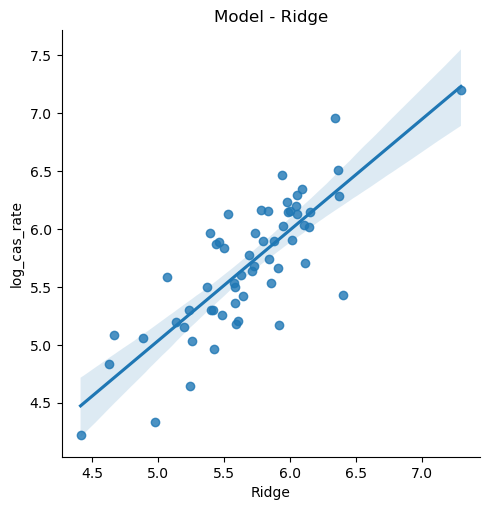

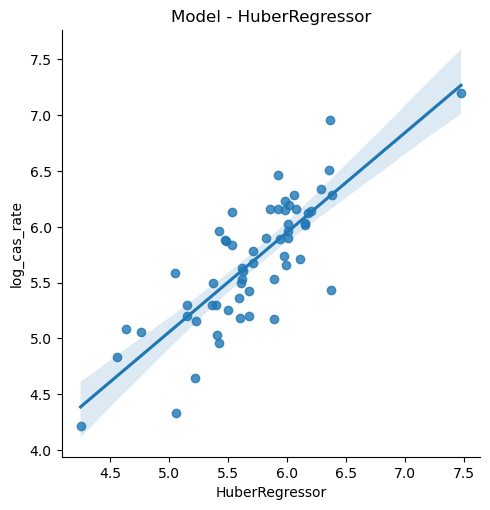

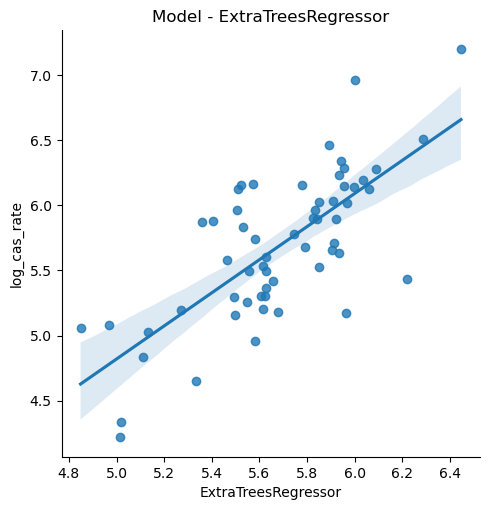

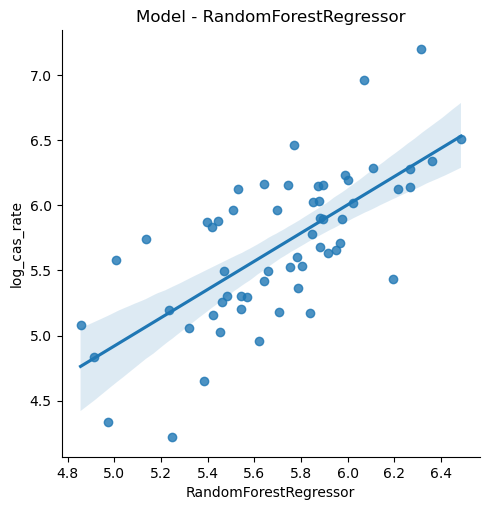

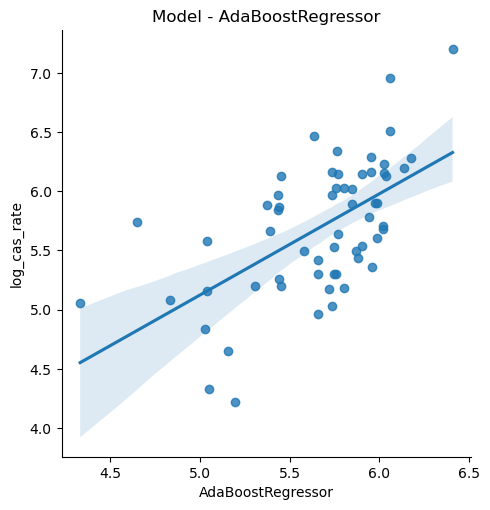

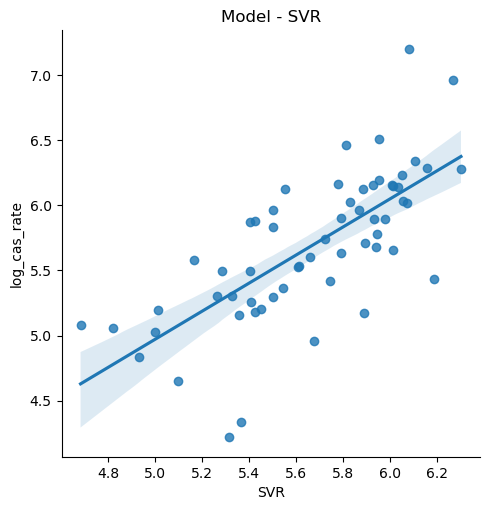

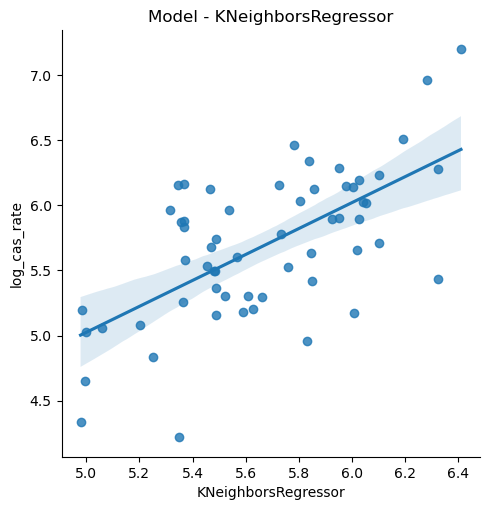

In [85]:
for col in cv_predictions_df.columns[1:]:
    sns.lmplot(data = cv_predictions_df, x = col, y = "log_cas_rate")
    plt.title(f"Model - {col}") 
    plt.show()

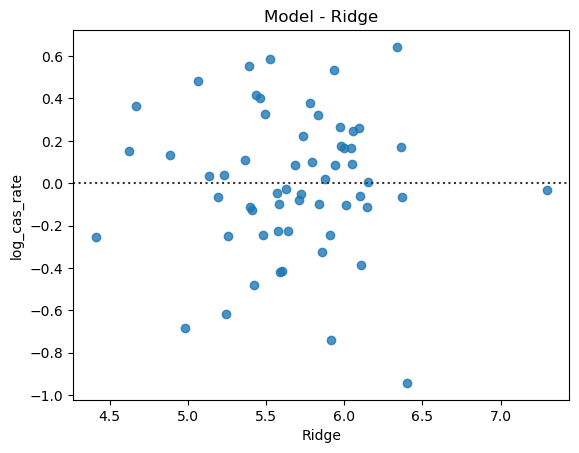

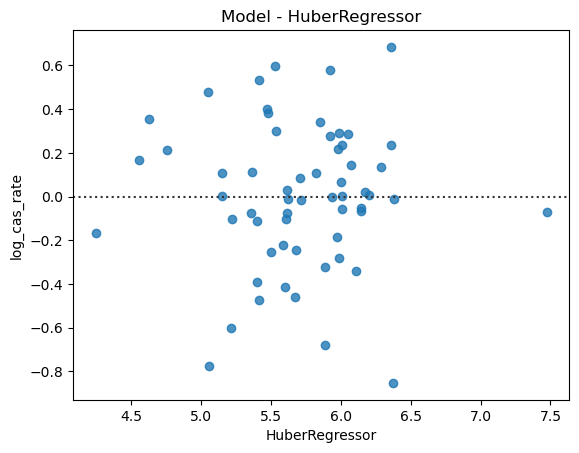

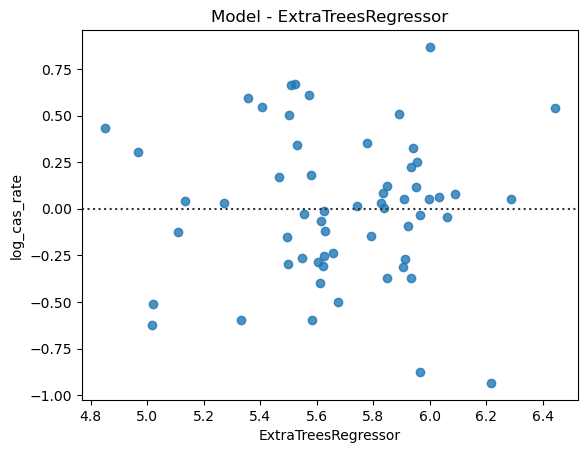

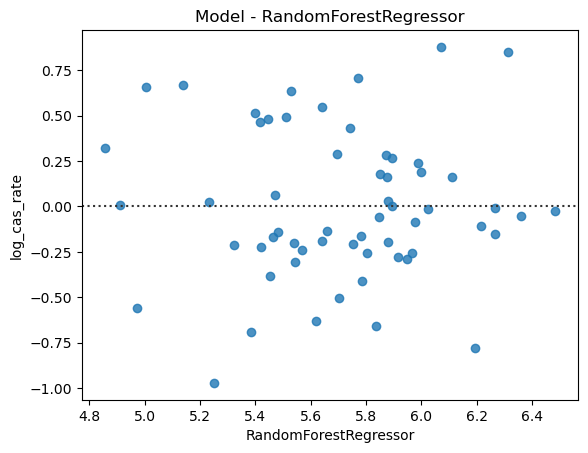

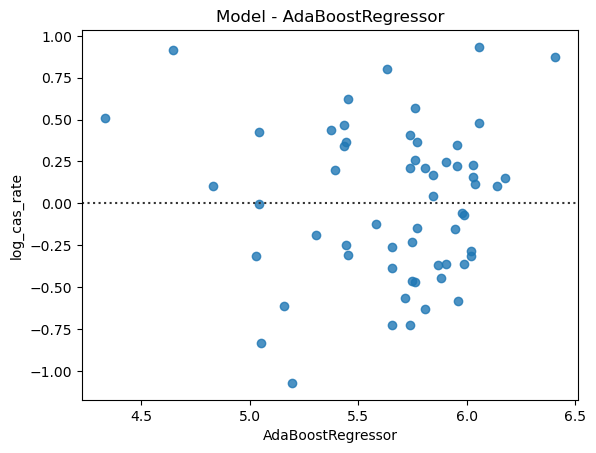

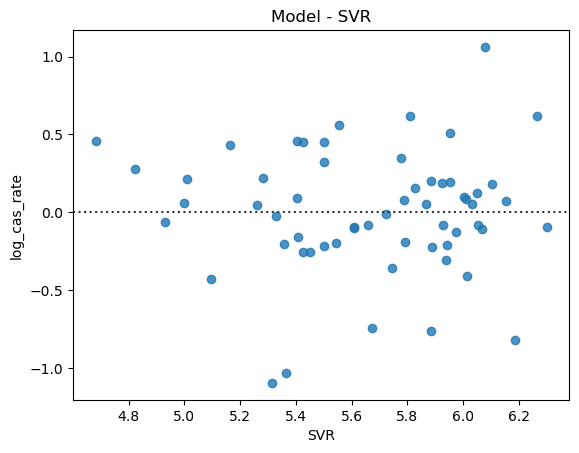

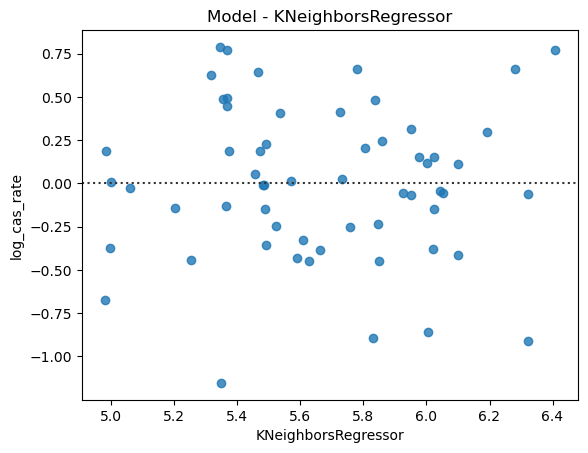

In [86]:
# Examining residuals

for col in cv_predictions_df.columns[1:]:
    fig, ax = plt.subplots()
    sns.residplot(data = cv_predictions_df, x = col, y = "log_cas_rate")
    plt.title(f"Model - {col}") 

plt.show()

In general, residuals do not show clear marks of patterned behavior.

In [87]:
# Creating a dataframe for residuals
resid_df = DataFrame(index = cv_predictions_df.index)

# Calculating residuals
for col in cv_predictions_df.iloc[:, 1:]:
    resid_df[f"resid_{col}"] = cv_predictions_df["log_cas_rate"] - cv_predictions_df[col]

resid_df.head()

resid_Ridge  resid_HuberRegressor  \
region_in_English                                      
Sevastopol            0.417532              0.453943   
Tambov Oblast        -0.020340             -0.017527   
Ulyanovsk Oblast      0.431954              0.391076   
Saratov Oblast        0.572974              0.547835   
Magadan Oblast        0.078998             -0.044249   

                   resid_ExtraTreesRegressor  resid_RandomForestRegressor  \
region_in_English                                                           
Sevastopol                          0.115977                     0.228998   
Tambov Oblast                      -0.021648                    -0.177819   
Ulyanovsk Oblast                    0.510800                     0.470291   
Saratov Oblast                      0.461058                     0.455211   
Magadan Oblast                      0.066020                    -0.087207   

                   resid_AdaBoostRegressor  resid_SVR  \
region_in_English                                       
Sevastopol                        0.252010   0.402471   
Tambov Oblast                    -0.382147  -0.053778   
Ulyanovsk Oblast                  0.425463   0.463753   
Saratov Oblast                    0.528866   0.462693   
Magadan Oblast                    0.086979   0.243248   

                   resid_KNeighborsRegressor  
region_in_English                             
Sevastopol                         -0.118854  
Tambov Oblast                       0.035350  
Ulyanovsk Oblast                    0.513572  
Saratov Oblast                      0.648765  
Magadan Oblast                      0.269093

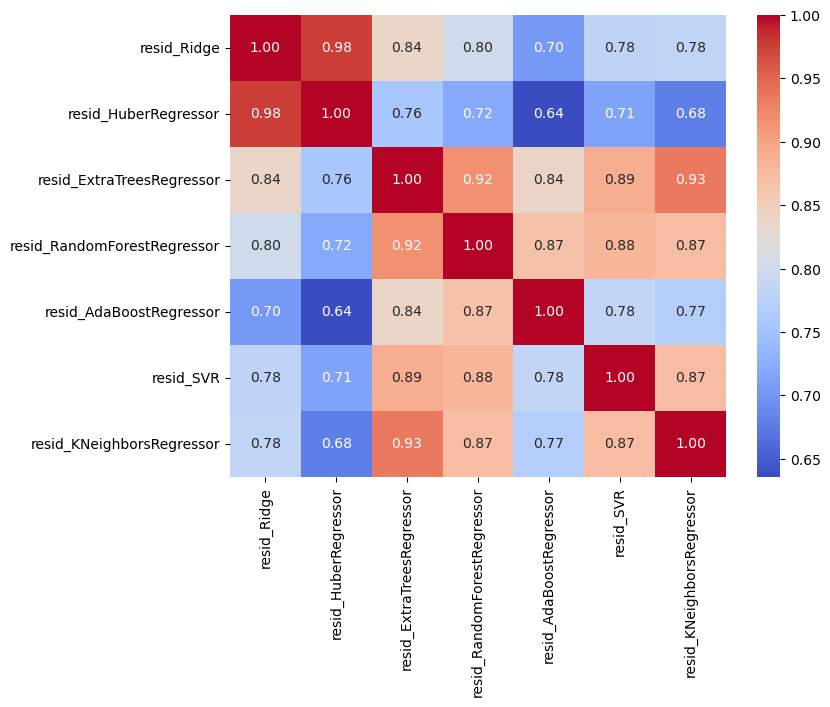

In [88]:
# Creating a heatmap for the correlation matrix of residuals
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(resid_df.corr(), annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

Based on our preliminary tests of the models implemented above and the observed correlations between the residuals, we can reasonably select the following models for further tuning:
* HuberRegressor as the linear model that performs slightly better than Ridge and has marginally less correlated residuals with those of other models;
* ExtraTreesRegressor as the best-performing ensemble model ;
* SVR as the only (and decently performing) support vector machines model;
* KNeighborsRegressor as the only nonparametric model.

In addition, the correlations between residuals in these four cases are often not particularly high, suggesting that some of them may complement one another.

## V. Tuning hyperparameters

In [89]:
# Creating a function for randomized / grid search cross-validation of the best hyperparameters

def tuning_hyperparams(model, param_distribs, scoring, cv, dataset):

    if model == kneighb_reg:
        grid_search = GridSearchCV(kneighb_reg, param_grid = param_distribs, 
                                        scoring = scoring, cv = cv)
        
        grid_search.fit(dataset, target)
        
        search_results = DataFrame(grid_search.cv_results_)
        return grid_search.best_params_, np.round(grid_search.best_score_, 3), search_results[["params", "mean_test_score", "std_test_score"]]
        
    else:
        rand_search = RandomizedSearchCV(model, param_distributions = param_distribs, n_iter=200, 
                                        scoring = scoring, cv = cv, random_state=42)

        rand_search.fit(dataset, target)

        search_results = DataFrame(rand_search.cv_results_)
        return rand_search.best_params_, np.round(rand_search.best_score_, 3), search_results[["params", "mean_test_score", "std_test_score"]]

Let's compare the results of the hyperparameters search for various metrics, such as mean squared error, mean absolute error, median absolute error, explained variance and $R^2$.

In [90]:
# Creating a dataframe for the results of hyperparameters search

models_for_tuning = [huber_reg, extra_reg, svr, kneighb_reg]
models_for_tuning_names = [model.steps[-1][1].__class__.__name__ for model in models_for_tuning]

tuning_results_df = DataFrame(index = models_for_tuning_names)

# Variables / parameters for the function for tuning hyperparameters

param_distribs_huber = [{"huberregressor__epsilon": uniform(1, 499), "huberregressor__alpha": uniform(0, 5)}]

param_distribs_extra = [{"extratreesregressor__n_estimators": np.arange(20, 220, 20), 
                          "extratreesregressor__max_depth": randint(2, 7), "extratreesregressor__min_samples_split": randint(2, 6),
                         "extratreesregressor__min_samples_leaf": randint(2, 4),
                         "extratreesregressor__max_features": randint(2, 7), "extratreesregressor__random_state": [42]}]

param_distribs_svr = [{"svr__kernel": ["linear", "poly", "rbf", "sigmoid"], 
                          "svr__gamma": ["scale", "auto", 0.01, 0.1, 0.5], "svr__C": uniform(0.01, 99.9),
                         "svr__epsilon": uniform(0.01, 0.99)}]

param_grid_kneighb = [{"kneighborsregressor__n_neighbors": np.arange(3, 23, 2),
                           "kneighborsregressor__weights": ["uniform", "distance"],
                           "kneighborsregressor__algorithm": ["auto"],
                           "kneighborsregressor__p": [1, 2]}]


param_distr = [param_distribs_huber, param_distribs_extra, param_distribs_svr, param_grid_kneighb]

datasets = [subsets_dfs[6], subsets_dfs[6], subsets_dfs[8], subsets_dfs[5]]

models_data = dict(zip(models_for_tuning, zip(param_distr, datasets)))

In [91]:
# A dataframe with results

for model in models_data.keys():
    tuning_results_df.loc[model.steps[-1][1].__class__.__name__, "neg_rmse"] = tuning_hyperparams(model = model, param_distribs = models_data[model][0], 
                                                              scoring = "neg_root_mean_squared_error", cv = 5, dataset = models_data[model][1])[1]
    tuning_results_df.loc[model.steps[-1][1].__class__.__name__, "neg_mean_ae"] = tuning_hyperparams(model = model, param_distribs = models_data[model][0], 
                                                              scoring = "neg_mean_absolute_error", cv = 5, dataset = models_data[model][1])[1]
    tuning_results_df.loc[model.steps[-1][1].__class__.__name__, "neg_median_ae"] = tuning_hyperparams(model = model, param_distribs = models_data[model][0], 
                                                              scoring = "neg_median_absolute_error", cv = 5, dataset = models_data[model][1])[1]
    tuning_results_df.loc[model.steps[-1][1].__class__.__name__, "explained_variance"] = tuning_hyperparams(model = model, param_distribs = models_data[model][0], 
                                                              scoring = "explained_variance", cv = 5, dataset = models_data[model][1])[1]
    tuning_results_df.loc[model.steps[-1][1].__class__.__name__, "R_squared"] = tuning_hyperparams(model = model, param_distribs = models_data[model][0], 
                                                              scoring = "r2", cv = 5, dataset = models_data[model][1])[1]

tuning_results_df

neg_rmse  neg_mean_ae  neg_median_ae  explained_variance  \
HuberRegressor         -0.318       -0.254         -0.178               0.622   
ExtraTreesRegressor    -0.359       -0.293         -0.242               0.588   
SVR                    -0.303       -0.245         -0.182               0.679   
KNeighborsRegressor    -0.389       -0.317         -0.263               0.510   

                     R_squared  
HuberRegressor           0.588  
ExtraTreesRegressor      0.506  
SVR                      0.632  
KNeighborsRegressor      0.448

Neither the ExtraTreesRegressor nor the KNeighborsRegressor ranks first in any of the evaluation metrics. The situation is different for HuberRegressor and SVR: the HuberRegressor achieves the lowest median absolute error, while the SVR leads in four metrics: rmse, mean absolute error, explained variance and $R^2$. Next, let's examine the hyperparameters for the best models in each metric. For ExtraTreesRegressor and KneighborsRegressor, we will check the hyperparameters for rmse.

In [92]:
# Printing results for the best version of the models

print(f"{huber_reg.steps[-1][1].__class__.__name__}, median absolute error: "
      f"{tuning_hyperparams(model = huber_reg, param_distribs = param_distribs_huber, 
                            scoring = "neg_median_absolute_error", cv = 5, dataset = subsets_dfs[6])[:2]}\n")

print(f"{extra_reg.steps[-1][1].__class__.__name__}, rmse: {tuning_hyperparams(model = extra_reg, param_distribs = param_distribs_extra, 
                                                              scoring = "neg_root_mean_squared_error", cv = 5, dataset = subsets_dfs[6])[:2]}\n")

print(f"{svr.steps[-1][1].__class__.__name__}, rmse: {tuning_hyperparams(model = svr, param_distribs = param_distribs_svr, 
                                                              scoring = "neg_root_mean_squared_error", cv = 5, dataset = subsets_dfs[8])[:2]}\n")

print(f"{svr.steps[-1][1].__class__.__name__}, mean absolute error: {tuning_hyperparams(model = svr, param_distribs = param_distribs_svr, 
                                                              scoring = "neg_mean_absolute_error", cv = 5, dataset = subsets_dfs[8])[:2]}\n")

print(f"{svr.steps[-1][1].__class__.__name__}, explained variance: {tuning_hyperparams(model = svr, param_distribs = param_distribs_svr, 
                                                              scoring = "explained_variance", cv = 5, dataset = subsets_dfs[8])[:2]}\n")

print(f"{svr.steps[-1][1].__class__.__name__}, R squared: {tuning_hyperparams(model = svr, param_distribs = param_distribs_svr, 
                                                              scoring = "r2", cv = 5, dataset = subsets_dfs[8])[:2]}\n")

print(f"{kneighb_reg.steps[-1][1].__class__.__name__}, rmse: {tuning_hyperparams(model = kneighb_reg, param_distribs = param_grid_kneighb, 
                                                              scoring = "neg_root_mean_squared_error", cv = 5, dataset = subsets_dfs[5])[:2]}")

HuberRegressor, median absolute error: ({'huberregressor__alpha': np.float64(1.4046725484369038), 'huberregressor__epsilon': np.float64(271.805345495966)}, np.float64(-0.178))

ExtraTreesRegressor, rmse: ({'extratreesregressor__max_depth': 5, 'extratreesregressor__max_features': 5, 'extratreesregressor__min_samples_leaf': 2, 'extratreesregressor__min_samples_split': 5, 'extratreesregressor__n_estimators': np.int64(140), 'extratreesregressor__random_state': 42}, np.float64(-0.359))

SVR, rmse: ({'svr__C': np.float64(39.458663665739415), 'svr__epsilon': np.float64(0.30055329297085775), 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}, np.float64(-0.303))

SVR, mean absolute error: ({'svr__C': np.float64(5.790603385994968), 'svr__epsilon': np.float64(0.40057658062204854), 'svr__gamma': 0.1, 'svr__kernel': 'linear'}, np.float64(-0.245))

SVR, explained variance: ({'svr__C': np.float64(39.458663665739415), 'svr__epsilon': np.float64(0.30055329297085775), 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}, 

We may see that two versions of SVR model (the first one and the third one) are identical, thus we have three distrinct versions instead of four.

We will tune the hyperparameters for HuberRegressor, ExtraTreesRegressor and KneighborsRegressor based on the preceding output. As far as SVR in concerned, it is worthwhile to compare the performance of our four versions across various metrics.

In [93]:
# Comparing three versions of the SVR model

# Initializing models with different sets of hyperparameters
svr_version_1 = Pipeline([
    ("preprocessing", preprocessing), 
    ("svr_version_1", SVR(C = 39.5, epsilon = 0.3, gamma = 0.01, kernel = "rbf"))])
    
svr_version_2 = Pipeline([
    ("preprocessing", preprocessing),
    ("svr_version_2", SVR(C = 5.8, epsilon = 0.4, gamma = 0.1, kernel = "linear"))])

svr_version_3 = Pipeline([
    ("preprocessing", preprocessing),
    ("svr_version_3", SVR(C = 3.67, epsilon = 0.26, gamma = 0.01, kernel = "rbf"))])

# Preparing a dataframe 
svr_versions_tuned = [svr_version_1, svr_version_2, svr_version_3]
svr_versions = [version.steps[-1][0] for version in svr_versions_tuned]
svr_versions_df = DataFrame(index = svr_versions)

metrics_dict = {"neg_rmse": "neg_root_mean_squared_error", "neg_mean_ae": "neg_mean_absolute_error", "explained_variance": "explained_variance", 
                "R_squared": "r2"}

# Assessing the performance of three versions of SVR across various metrics
for version in svr_versions_tuned:
    for key in metrics_dict.keys():
        svr_versions_df.loc[version.steps[-1][0], key] = cross_val_score(version, subsets_dfs[8], target, 
                                                                         scoring = metrics_dict[key], cv = 5).mean().round(3)

svr_versions_df

neg_rmse  neg_mean_ae  explained_variance  R_squared
svr_version_1    -0.303       -0.253               0.680      0.626
svr_version_2    -0.312       -0.245               0.636      0.590
svr_version_3    -0.308       -0.257               0.672      0.633

The results are quite close, and selecting the "best" model largely relies on formal criteria. We may notice that the first version performs best across two metrics: rmse and explained variance, and it ranks second in two other metrics. The performance of the other two models is slightly less robust. Therefore, we may choose the first version as the most promising one.

In [94]:
# Initializing tuned models
huber_tuned = make_pipeline(preprocessing, HuberRegressor(alpha = 1.4, epsilon = 271.81))

extra_tuned = make_pipeline(preprocessing, ExtraTreesRegressor(max_depth = 5, max_features = 5, min_samples_leaf = 2, 
                                                                min_samples_split = 5, n_estimators = 140, random_state = 42))

svr_tuned = svr_version_1

kneighb_tuned = make_pipeline(preprocessing, KNeighborsRegressor(n_neighbors = 7, p = 1, weights = "distance"))

Let's replicate the steps for our tuned models which we implimented for the untuned ones.

In [95]:
# Our tuned set of models
models_tuned = [huber_tuned, extra_tuned, svr_tuned, kneighb_tuned]

models_subsets_dict = {huber_tuned: 6, extra_tuned: 6, svr_tuned: 8, kneighb_tuned: 5}

# Creating a dataframe with the target and predictions
tuned_predictions_df = DataFrame(target, index = workcopy_train.index) 

# Generating predictions on 3 cross-validation samples
model_predictions(dataframe = tuned_predictions_df, models_subsets_dict = models_subsets_dict, cv = 3)

log_cas_rate  HuberRegressor  ExtraTreesRegressor  \
region_in_English                                                            
Sevastopol                   5.084355        4.667220             4.968306   
Tambov Oblast                5.603910        5.628049             5.675330   
Ulyanovsk Oblast             5.868160        5.444465             5.375618   
Saratov Oblast               5.964822        5.395380             5.500333   
Magadan Oblast               6.126925        6.020611             6.136314   
Kaluga Oblast                5.361801        5.589992             5.578574   
Sverdlovsk Oblast            5.837001        5.504294             5.505213   
Rostov Oblast                5.253834        5.494898             5.428221   
Krasnoyarsk Krai             5.659849        5.894692             5.833784   
Nenets Autonomous Okrug      6.341897        6.102511             6.057288   
Adygea                       5.195985        5.128143             5.274636   
Karachay-Cherkessia          5.029646        5.297463             5.167873   
Bryansk Oblast               5.883311        5.465304             5.415706   
Perm Krai                    6.229983        5.981924             5.929590   
Samara Oblast                5.497874        5.610855             5.576040   
Kalmykia                     5.964373        5.818009             5.723119   
Vologda Oblast               5.897086        5.793346             5.912715   
Bashkortostan                6.155653        5.870821             5.682309   
Kemerovo Oblast              5.709119        6.129403             6.005571   
Mari El                      6.160010        5.808054             5.552153   
Voronezh Oblast              5.301972        5.411718             5.560631   
Pskov Oblast                 6.022490        5.952965             5.916458   
Irkutsk Oblast               6.030613        6.105560             5.958624   
Lipetsk Oblast               5.496257        5.362030             5.491370   
Karelia                      6.281870        6.365457             6.419014   
Sakhalin Oblast              6.465236        5.933658             5.763445   
Amur Oblast                  5.433035        6.381322             6.475465   
Moscow Oblast                4.832345        4.596405             4.989153   
Novgorod Oblast              6.016586        6.145840             6.028936   
Tyumen Oblast                5.679326        5.725595             5.839754   
Kostroma Oblast              5.892406        5.884616             5.923004   
Tuva                         7.197644        7.324625             6.544875   
Krasnodar Krai               5.303173        5.391628             5.566079   
Ryazan Oblast                5.155923        5.181903             5.402924   
Yaroslavl Oblast             5.180831        5.594040             5.649546   
Chelyabinsk Oblast           5.901461        6.031731             5.910411   
Belgorod Oblast              5.582631        5.046203             5.194634   
Chuvashia                    5.738533        5.861514             5.264605   
Murmansk Oblast              5.529050        5.865342             5.795744   
Chechnya                     4.331896        4.936143             4.764757   
Udmurtia                     6.158461        6.029124             5.927260   
Dagestan                     5.059279        4.807589             4.920865   
Mordovia                     5.534954        5.594450             5.639906   
Zabaykalsky Krai             6.508252        6.306785             6.174508   
Kamchatka Krai               6.197057        6.012017             6.101625   
Tomsk Oblast                 5.634298        5.673471             5.909404   
Stavropol Krai               5.298054        5.211160             5.223517   
Tatarstan                    6.128772        5.541364             5.315130   
Tula Oblast                  4.960629        5.411956             5.620242   
Khabarovsk Krai              5.170028        5.

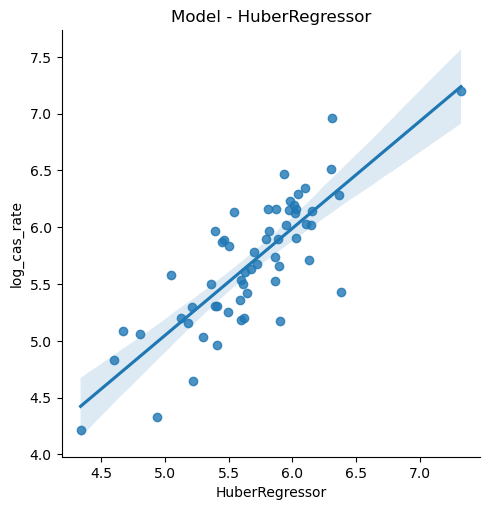

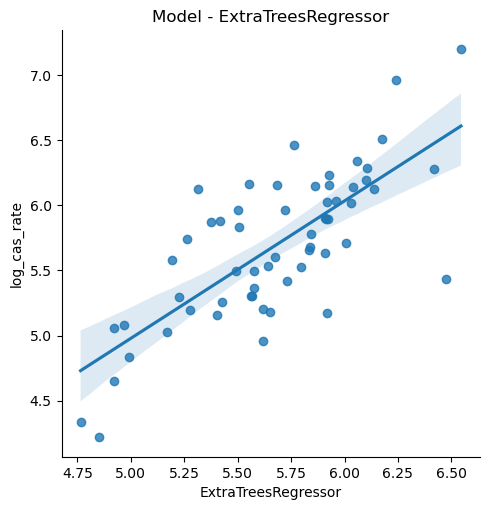

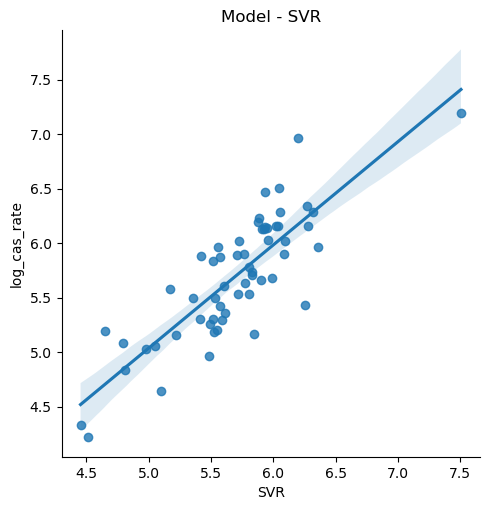

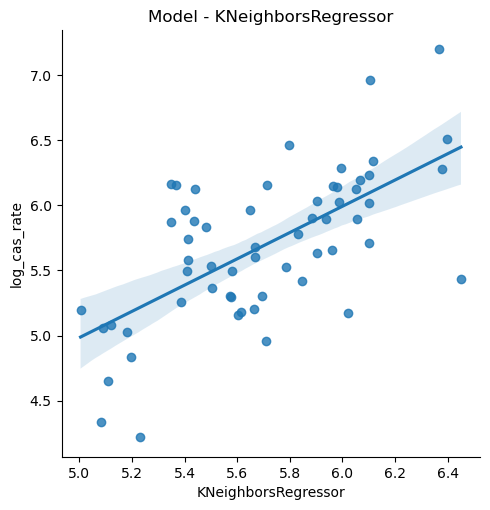

In [96]:
for col in tuned_predictions_df.columns[1:]:
    sns.lmplot(data = tuned_predictions_df, x = col, y = "log_cas_rate")
    plt.title(f"Model - {col}") 

plt.show()

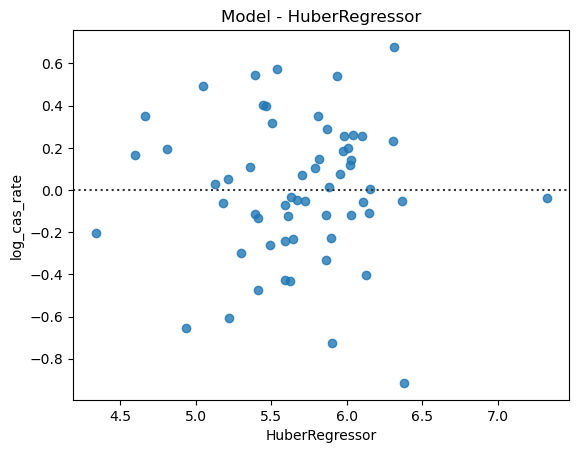

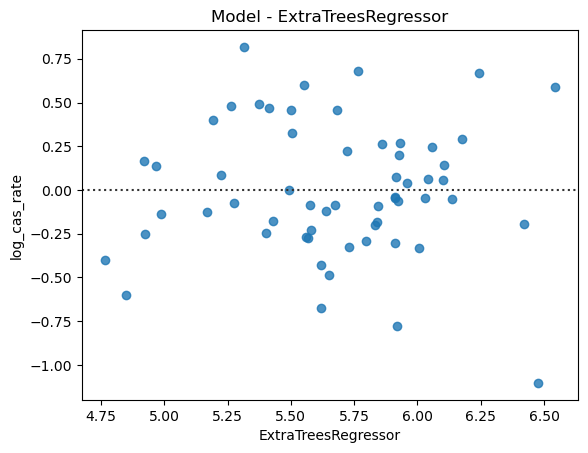

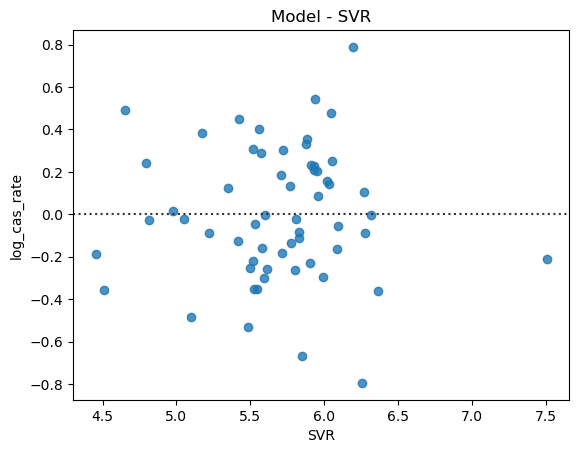

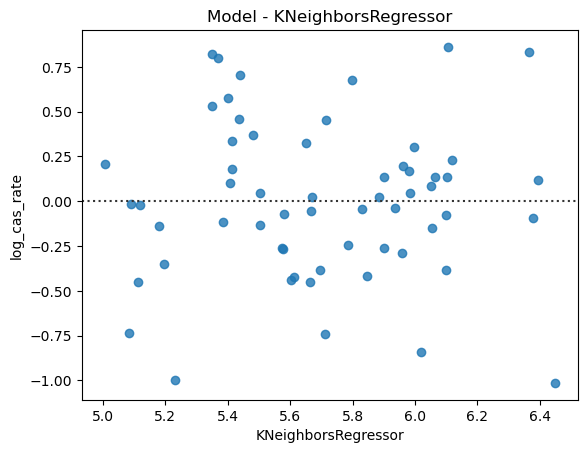

In [97]:
# Examining residuals
for col in tuned_predictions_df.columns[1:]:
    sns.residplot(data = tuned_predictions_df, x = col, y = "log_cas_rate")
    plt.title(f"Model - {col}") 
    plt.show()

There are no noticeable patterns on the resuduals plots.

In [98]:
# Creating a dataframe for residuals
resid_tuned_df = DataFrame(index = tuned_predictions_df.index)

# Calculating residuals
for col in tuned_predictions_df.iloc[:, 1:]:
    resid_tuned_df[f"resid_{col}"] = tuned_predictions_df["log_cas_rate"] - tuned_predictions_df[col]

resid_tuned_df.head()

resid_HuberRegressor  resid_ExtraTreesRegressor  resid_SVR  \
region_in_English                                                               
Sevastopol                     0.417135                   0.116049   0.291385   
Tambov Oblast                 -0.024139                  -0.071420   0.003434   
Ulyanovsk Oblast               0.423694                   0.492542   0.295530   
Saratov Oblast                 0.569442                   0.464489   0.406904   
Magadan Oblast                 0.106314                  -0.009389   0.197819   

                   resid_KNeighborsRegressor  
region_in_English                             
Sevastopol                         -0.034414  
Tambov Oblast                      -0.062853  
Ulyanovsk Oblast                    0.518944  
Saratov Oblast                      0.564530  
Magadan Oblast                      0.075584

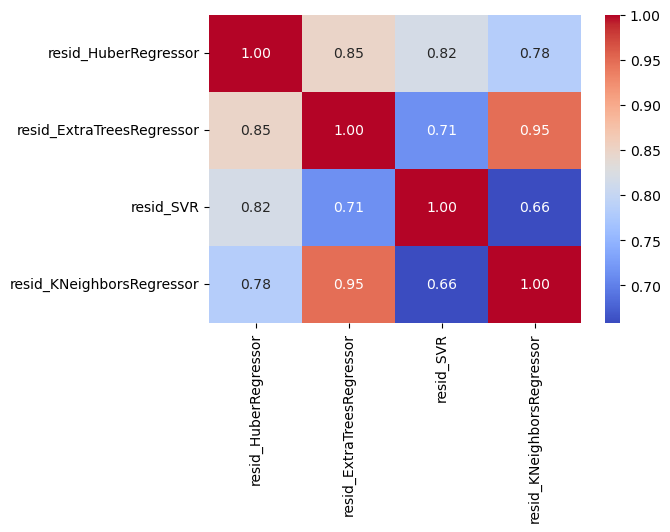

In [99]:
# Creating a heatmap for the correlation matrix of residuals of the selected tuned models
fig, ax = plt.subplots(figsize = (6, 4))
sns.heatmap(resid_tuned_df.corr(), annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

The correlation among resudials is not everywhere strong, thus there is some hope that complementarity may take place. Therefore it is reasonable to try a stacking regression model.

## VI. Building and choosing the final model

Let's try two stacking regressors, each with a different final estimator: a simple one, Ridge, and a more sophisticated one, GradientBoostingRegressor. Before proceeding, let's gather the performance data of our basic tuned models in one place.

In [100]:
# Creating a dataframe with the performance of the tuned models across 3 metrics

models_tuned = [huber_tuned, extra_tuned, svr_tuned, kneighb_tuned]

models_predictors_dict = {huber_tuned: subsets_dfs[6], extra_tuned: subsets_dfs[6], svr_tuned: subsets_dfs[8], kneighb_tuned: subsets_dfs[5]}

scoring_dict = {"rmse": "neg_root_mean_squared_error", "r": corr_scorer, "mae": "neg_median_absolute_error"}

models_tuned_names = [model.steps[-1][1].__class__.__name__ for model in models_tuned]
tuned_performance = DataFrame(index = models_tuned_names)
# Testing quality of tuned models
for model in models_tuned_names:
    for scoring in scoring_dict.keys():
        tuned_performance.loc[:, scoring] = model_performance(models_predictors_dict = models_predictors_dict, 
                                                              scoring = scoring_dict[scoring], cv = 5)

tuned_performance

rmse      r    mae
HuberRegressor       0.320  0.800  0.178
ExtraTreesRegressor  0.359  0.770  0.252
SVR                  0.303  0.853  0.229
KNeighborsRegressor  0.389  0.737  0.290

In [101]:
# Creating function for printing results for stacking regressors
def printing_results(regressor, final_estimator):
    print(
    f"StackingRegressor with {final_estimator} as a FE: \n"
    "Average rmse = ",
          f"{-cross_val_score(regressor, predictions_as_predictors, target, cv = 5, 
                              scoring = "neg_root_mean_squared_error").mean().round(3)};",
    "standard deviation = ",
    f"{cross_val_score(regressor, predictions_as_predictors, target, cv = 5, scoring = "neg_root_mean_squared_error").std().round(3)}\n")

In [102]:
# A stacking regressor with Ridge as a final estimator

# Preparing a dataset of the predictions made by our models as a set of predictors for StackingRegressor
predictions_as_predictors = tuned_predictions_df.iloc[:, 1:]

# Initializing StackingRegressor
stacking_reg_ridge = make_pipeline(preprocessing, StackingRegressor(estimators = [
    ("huber", huber_tuned),
    ("extra", extra_tuned),
    ("svr", svr_tuned),
    ("kneighbors", kneighb_tuned)
    ], final_estimator = Ridge()))

printing_results(stacking_reg_ridge, Ridge)

StackingRegressor with <class 'sklearn.linear_model._ridge.Ridge'> as a FE: 
Average rmse =  0.331; standard deviation =  0.092



Unfortunately, the result is worse than for some of our basic models.

Let's test StackingRegressor with GradientBoostingRegressor as the FE. 

In [103]:
# A stacking regressor with GradientBoostingRegressor as a final estimator

stacking_reg_gradboost = make_pipeline(preprocessing, StackingRegressor(estimators = [
    ("huber", huber_tuned),
    ("extra", extra_tuned),
    ("svr", svr_tuned),
    ("kneighbors", kneighb_tuned)
    ], final_estimator = GradientBoostingRegressor(random_state=42, max_depth = 3)))

printing_results(stacking_reg_gradboost, GradientBoostingRegressor)

StackingRegressor with <class 'sklearn.ensemble._gb.GradientBoostingRegressor'> as a FE: 
Average rmse =  0.391; standard deviation =  0.115



This is noticeably worse than the results from our basic models.

Let's try some simpler aggregation methods, like averaging across predictions of different models.

We may try two options: 1) averaging across the predictions from all models; 2) averaging across the predictions from our best models - HuberRegression and SVR.

In [104]:
# Average prediciton of all models
average_df = predictions_as_predictors.copy()
average_df["all"] = np.mean(average_df, axis = 1)
rmse_all = mean_squared_error(target, average_df["all"])**(0.5)
r_all, _ = pearsonr(target, average_df["all"])

print("For the average of all predictions:")
print(f"rmse score = {np.round(rmse_all, 3)}, Pearson's r = {r_all.round(3)}")

average_df["huber_svr"] = np.mean(average_df[["HuberRegressor", "SVR"]], axis = 1)
rmse_2best = mean_squared_error(target, average_df["huber_svr"])**(0.5)
r_2best, _ = pearsonr(target, average_df["huber_svr"])

print("\nFor the average of the predictions by HuberRegressor and SVR:")
print(f"rmse score = {np.round(rmse_2best, 3)}, Pearson's r = {r_2best.round(3)}")

For the average of all predictions:
rmse score = 0.334, Pearson's r = 0.81

For the average of the predictions by HuberRegressor and SVR:
rmse score = 0.305, Pearson's r = 0.842


Nothing beats SVR. 

Let's check how HuberRegressor and SVR perform across different number of splits in cross-validation. Hopefully, it will help us choose the model which generalizes better.

In [105]:
# Creating a dataframe of cross-validation results for different cross-validation splits

svr = {}
huber = {}

for scoring in scoring_dict.keys():
    svr[scoring] = []
    huber[scoring] = []
    for i in range(2, 21):    
        svr[scoring].append(cross_val_score(svr_tuned, subsets_dfs[8], target, cv=i, scoring = scoring_dict[scoring]).mean().round(3))
        huber[scoring].append(cross_val_score(huber_tuned, subsets_dfs[6], target, cv=i, scoring = scoring_dict[scoring]).mean().round(3))

cv_scores_df = DataFrame({"num_CVs": np.arange(2, 21), 
                          "svr_rmse": svr["rmse"],
                          "svr_r": svr["r"],
                          "svr_mae": svr["mae"],
                          "huber_rmse": huber["rmse"],
                          "huber_r": huber["r"],
                          "huber_mae": huber["mae"]
                         })

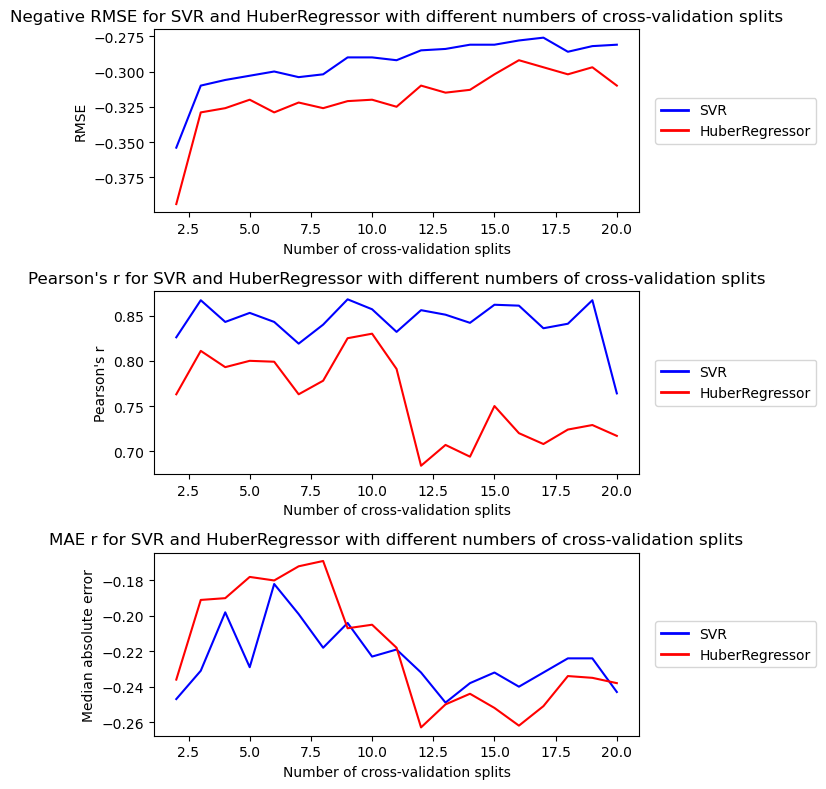

In [106]:
# Plotting rmse scores of SVR and StackingRegressor against different number of cross-validation splits
fig, axs = plt.subplots(3, 1, figsize = (8, 8))

axs[0].plot(cv_scores_df["num_CVs"], cv_scores_df["svr_rmse"], color = "blue")
axs[0].plot(cv_scores_df["num_CVs"], cv_scores_df["huber_rmse"], color = "red")
handles = [plt.Line2D([0], [0], color = color, lw = 2) for color in ["blue", "red"]]
labels = ["SVR", "HuberRegressor"]
axs[0].legend(handles, labels, loc = "center", bbox_to_anchor = (1.2, 0.5))
axs[0].set_title("Negative RMSE for SVR and HuberRegressor with different numbers of cross-validation splits")
axs[0].set_xlabel("Number of cross-validation splits")
axs[0].set_ylabel("RMSE")

axs[1].plot(cv_scores_df["num_CVs"], cv_scores_df["svr_r"], color = "blue")
axs[1].plot(cv_scores_df["num_CVs"], cv_scores_df["huber_r"], color = "red")
handles = [plt.Line2D([0], [0], color = color, lw = 2) for color in ["blue", "red"]]
labels = ["SVR", "HuberRegressor"]
axs[1].legend(handles, labels, loc = "center", bbox_to_anchor = (1.2, 0.5))
axs[1].set_title("Pearson's r for SVR and HuberRegressor with different numbers of cross-validation splits")
axs[1].set_xlabel("Number of cross-validation splits")
axs[1].set_ylabel("Pearson's r")

axs[2].plot(cv_scores_df["num_CVs"], cv_scores_df["svr_mae"], color = "blue")
axs[2].plot(cv_scores_df["num_CVs"], cv_scores_df["huber_mae"], color = "red")
handles = [plt.Line2D([0], [0], color = color, lw = 2) for color in ["blue", "red"]]
labels = ["SVR", "HuberRegressor"]
axs[2].legend(handles, labels, loc = "center", bbox_to_anchor = (1.2, 0.5))
axs[2].set_title("MAE r for SVR and HuberRegressor with different numbers of cross-validation splits")
axs[2].set_xlabel("Number of cross-validation splits")
axs[2].set_ylabel("Median absolute error")

plt.tight_layout()
plt.show()

It is evident that SVR outperforms HuberRegression when comparing rmse and Pearson's r. However, the evaluation of MAE presents a mixed picture: for a small number of cross-validation splits, the Huber Regressor seems to perform better, but this trend generally reverses with an increased number of splits.

Let's examine the performance of models using leave-one-out cross-validation (loocv).

In [107]:
# Since the results of loocv are identical across mae and rmse if models and data stay the same, we may use only one metrics

loocv = LeaveOneOut()

best_models = [svr_tuned, huber_tuned]

print("The results of the best models on leave-one-out cross-validation: \n")
for model in best_models:
    if model == huber_tuned:
        print(f"\n{model.steps[-1][1].__class__.__name__}: \n"
          "Average rmse = ",
          f"{-cross_val_score(model, subsets_dfs[6], target, cv = loocv, scoring = "neg_root_mean_squared_error").mean().round(3)}")
    if model == svr_tuned:
        print(f"{model.steps[-1][1].__class__.__name__}: \n"
          "Average rmse = ",
          f"{-cross_val_score(model, subsets_dfs[8], target, cv = loocv, scoring = "neg_root_mean_squared_error").mean().round(3)}")

The results of the best models on leave-one-out cross-validation: 

SVR: 
Average rmse =  0.249

HuberRegressor: 
Average rmse =  0.261


Once again, SVR outperforms HuberRegression. Different tests suggest that this is our best model.

To more reliably evaluate how well it generalizes, we may employ nested cross-validation. 

In [108]:
# Creating function for nested cross-validation

def nested_cv(model, param_distribs, scoring, predictors_set):
    model_ = make_pipeline(preprocessing, model)

    outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
    inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 41)

    rand_search = RandomizedSearchCV(model_, param_distributions = param_distribs, n_iter=200, 
                                        scoring = "neg_root_mean_squared_error", cv = inner_cv, random_state=42)

    if scoring == corr_scorer or scoring == "r2":
        nested_cv_results = np.round(cross_val_score(rand_search, predictors_set, target, cv = outer_cv, scoring = scoring), 3)
        
    else:
        nested_cv_results = np.round(-cross_val_score(rand_search, predictors_set, target, cv = outer_cv, scoring = scoring), 3)
        

    print(f"Nested cross-validation scores: {nested_cv_results};\nmean = {nested_cv_results.mean().round(3)};"
          f"\nstandard deviation = {nested_cv_results.std().round(3)}")

In [109]:
model = SVR()
param_distribs = [{"svr__kernel": ["linear", "poly", "rbf", "sigmoid"], 
                          "svr__gamma": ["scale", "auto", 0.01, 0.1, 0.5], "svr__C": uniform(0.01, 99.9),
                         "svr__epsilon": uniform(0.01, 0.99)}]

# Nested cross-validation with different metrics
print("RMSE as a metric:")
nested_cv(model = model, param_distribs = param_distribs, scoring = "neg_root_mean_squared_error", predictors_set = subsets_dfs[8])
print("\nPearson's r as a metric:")
nested_cv(model = model, param_distribs = param_distribs, scoring = corr_scorer, predictors_set = subsets_dfs[8])
print("\nMedian absolute error as a metric:")
nested_cv(model = model, param_distribs = param_distribs, scoring = "neg_median_absolute_error", predictors_set = subsets_dfs[8])
print("\nR squared as a metric:")
nested_cv(model = model, param_distribs = param_distribs, scoring = "r2", predictors_set = subsets_dfs[8])

RMSE as a metric:
Nested cross-validation scores: [0.415 0.244 0.341 0.282 0.374];
mean = 0.331;
standard deviation = 0.062

Pearson's r as a metric:
Nested cross-validation scores: [0.632 0.903 0.871 0.914 0.719];
mean = 0.808;
standard deviation = 0.112

Median absolute error as a metric:
Nested cross-validation scores: [0.372 0.211 0.173 0.2   0.179];
mean = 0.227;
standard deviation = 0.074

R squared as a metric:
Nested cross-validation scores: [0.364 0.685 0.676 0.736 0.428];
mean = 0.578;
standard deviation = 0.151


As expected, the results are somewhat worse than those from non-nested cross-validation, but Pearson's r higher than 0.8 is still a decent result.

Finally, we can proceed to the test set.

## VII. Measuring the performance of the best model on the test set

In [110]:
# Creating necessary features in the test set
workcopy_test = test_data.copy()
workcopy_test.set_index("region_in_English", inplace = True)

workcopy_test["log_density"] =  np.log(workcopy_test['population_2022'] / workcopy_test['square_km^2']) + 2

workcopy_test["density_crimes"] = workcopy_test["log_density"] * (workcopy_test["crimes_per_10_000_residents_2022"].max() + 1 -
                                                                    workcopy_test["crimes_per_10_000_residents_2022"]) 

# Creating a dataframe of predictors from the test set
predictors_fin_test = DataFrame(workcopy_test, columns = subsets_dfs[8].columns, index = workcopy_test.index)
predictors_fin_test.head()

men_higher_educ_2020  density_crimes  log_density  \
region_in_English                                                             
Smolensk Oblast                       0.241810      199.109672     4.880139   
Volgograd Oblast                      0.238391      251.686397     5.094866   
Ingushetia                            0.189997      920.635725     7.098194   
Leningrad Oblast                      0.256299      259.744236     5.174188   
Jewish Autonomous Oblast              0.187286       23.234327     3.416813   

                          crimes_per_10_000_residents_2022  Caucasus  \
region_in_English                                                      
Smolensk Oblast                                      121.8         0   
Volgograd Oblast                                     113.2         0   
Ingushetia                                            32.9         1   
Leningrad Oblast                                     112.4         0   
Jewish Autonomous Oblast                             155.8         0   

                          share_of_ethnic_russians_2024  
region_in_English                                        
Smolensk Oblast                                    94.7  
Volgograd Oblast                                   92.5  
Ingushetia                                          0.7  
Leningrad Oblast                                   93.7  
Jewish Autonomous Oblast                           95.7

In [111]:
# Fitting the best model on the train set
svr_tuned.fit(subsets_dfs[8], target)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                 ('standardscaler', StandardScaler())])),
                ('svr_version_1', SVR(C=39.5, epsilon=0.3, gamma=0.01))])

In [112]:
# Predicting the values of the dependent variable for the test set
final_predictions_test = svr_tuned.predict(predictors_fin_test)

# Converting log-transformed predicted values into the original scale
final_predictions_orig = np.exp(final_predictions_test)

# Calculating casualties per 100 000 men for the test set
workcopy_test["casualties_rate"] = workcopy_test["casualties_mid_july_2025"] / (workcopy_test["men_working_age_total_2022"] / 100_000)

# Creating a dataframe with the true and predicted values of the dependent variable for the test set
true_and_predicted = DataFrame(workcopy_test, columns = ["casualties_rate"], index = predictors_fin_test.index)
true_and_predicted["predicted_orig_scale"] = final_predictions_orig
true_and_predicted["log_casualties_rate"] = np.log(workcopy_test["casualties_rate"])
true_and_predicted["log_predicted"] = final_predictions_test

In [113]:
# Let's examine the results for the test set
true_and_predicted

casualties_rate  predicted_orig_scale  \
region_in_English                                                       
Smolensk Oblast                      171.797143            319.354847   
Volgograd Oblast                     301.742596            311.244985   
Ingushetia                            96.118749            103.175102   
Leningrad Oblast                     165.544454            289.149763   
Jewish Autonomous Oblast             255.532842            432.164351   
Moscow                                36.428182             84.791545   
Altai Republic                       960.488604            835.482995   
Yamalo-Nenets Autonomous Okrug       321.938932            381.029003   
Oryol Oblast                         289.058266            227.598222   
Khanty-Mansi Autonomous Okrug        211.476595            348.503426   
Astrakhan Oblast                     395.376803            379.673384   
Nizhny Novgorod Oblast               215.172138            231.436368   
North Ossetia–Alania                 426.511441            156.816620   
Altai Krai                           374.243313            368.028295   
Sakha                                436.240539            817.007031   
Novosibirsk Oblast                   280.140107            296.386786   
Kirov Oblast                         587.071464            355.945544   
Primorsky Krai                       347.591103            350.492576   
Chukotka Autonomous Okrug            833.133541            647.115834   
Penza Oblast                         261.840606            256.409845   
Orenburg Oblast                      435.329507            335.976477   
Ivanovo Oblast                       387.028042            256.446929   
Kursk Oblast                         266.873805            236.136958   
Kaliningrad Oblast                   311.983504            213.108612   
Komi Republic                        514.117986            572.879057   
Tver Oblast                          300.748517            365.065886   

                                log_casualties_rate  log_predicted  
region_in_English                                                   
Smolensk Oblast                            5.146314       5.766303  
Volgograd Oblast                           5.709574       5.740580  
Ingushetia                                 4.565584       4.636428  
Leningrad Oblast                           5.109240       5.666945  
Jewish Autonomous Oblast                   5.543351       6.068806  
Moscow                                     3.595343       4.440196  
Altai Republic                             6.867442       6.728010  
Yamalo-Nenets Autonomous Okrug             5.774362       5.942875  
Oryol Oblast                               5.666628       5.427582  
Khanty-Mansi Autonomous Okrug              5.354114       5.853648  
Astrakhan Oblast                           5.979839       5.939311  
Nizhny Novgorod Oblast                     5.371438       5.444305  
North Ossetia–Alania                       6.055639       5.055077  
Altai Krai                                 5.924906       5.908160  
Sakha                                      6.078194       6.705648  
Novosibirsk Oblast                         5.635290       5.691665  
Kirov Oblast                               6.375147       5.874778  
Primorsky Krai                             5.851027       5.859340  
Chukotka Autonomous Okrug                  6.725194       6.472525  
Penza Oblast                               5.567736       5.546777  
Orenburg Oblast                            6.076103       5.817041  
Ivanovo Oblast                             5.958497       5.546922  
Kursk Oblast                               5.586776       5.464412  
Kaliningrad Oblast                         5.742950       5.361802  
Komi Republic                              6.242453       6.350675  
Tver Oblast                                5.706274       5.900078

In [114]:
# Assesing model's performance for the test set
print(f"Rmse for the test set = {np.round(mean_squared_error(true_and_predicted["log_casualties_rate"], 
                                                             true_and_predicted["log_predicted"])**(0.5), 3)}")

print(f"Pearson's r for the test set (log-transformed values) = "
      f"{true_and_predicted["log_casualties_rate"].corr(true_and_predicted["log_predicted"]).round(3)}")

print(f"Pearson's r for the test set (original scale) = "
      f"{true_and_predicted["casualties_rate"].corr(true_and_predicted["predicted_orig_scale"]).round(3)}")

print(f"MAE for the test set = {np.round(median_absolute_error(true_and_predicted["log_casualties_rate"], 
                                                             true_and_predicted["log_predicted"]), 3)}")
print(f"R squared for the test set = {np.round(r2_score(true_and_predicted["log_casualties_rate"], 
                                                             true_and_predicted["log_predicted"]), 3)}")

Rmse for the test set = 0.402
Pearson's r for the test set (log-transformed values) = 0.776
Pearson's r for the test set (original scale) = 0.755
MAE for the test set = 0.216
R squared for the test set = 0.597


As expected, the results for the test set are somewhat worse compared to the training set for most metrics; however, the decrease in quality is not dramatic. In fact, Pearson's r higher than 0.75 can be considered a good result given our noisy dataset and very low sample size, where potential outliers can have a significant impact. Interestingly, the results for median absolute error and $R^2$ on the test set are even better than that observed during nested cross-validation on the training set. This further supports the hypothesis that we have avoided overfitting the training set and that our model generalizes quite well.

Let’s check for any influential outliers.

In [115]:
# Creating a function for calculating metrics with leaving one region out of sample
def leave_one_out_metrics(y_true, y_pred, metrics):
    n = len(y_true)
    res = np.zeros(n)
    for i in range(n):
        mask = (np.arange(n)!= i)
        if metrics == pearsonr:
            res[i], _ = metrics(y_true[mask], y_pred[mask])
        else:
            res[i] = metrics(y_true[mask], y_pred[mask])
    return res

In [116]:
#Creating a dataframe with quality metrics with each region left out at a time
loo_results = DataFrame({"region": true_and_predicted.index,
           "corr_without_region": leave_one_out_metrics(true_and_predicted["casualties_rate"], true_and_predicted["predicted_orig_scale"], pearsonr),
                 "mse_without_region": leave_one_out_metrics(true_and_predicted["log_casualties_rate"], true_and_predicted["log_predicted"], 
                                                              mean_squared_error)}).set_index("region")

# Converting mse metrics into rmse metrics for comparability with the previous analysis
loo_results["rmse_without_region"] = loo_results["mse_without_region"]**(0.5)

# Printing sorted results
print(f"Sorted by Pearson's r:\n{loo_results["corr_without_region"].sort_values()}\n\n")
print(f"Sorted by rmse:\n{loo_results["rmse_without_region"].sort_values()}")

Sorted by Pearson's r:
region
Altai Republic                    0.641497
Chukotka Autonomous Okrug         0.722880
Moscow                            0.730038
Ingushetia                        0.736575
Komi Republic                     0.747849
Nizhny Novgorod Oblast            0.750664
Penza Oblast                      0.752951
Kursk Oblast                      0.753180
Novosibirsk Oblast                0.754224
Volgograd Oblast                  0.754730
Astrakhan Oblast                  0.755052
Oryol Oblast                      0.755147
Altai Krai                        0.755219
Primorsky Krai                    0.755299
Yamalo-Nenets Autonomous Okrug    0.757029
Tver Oblast                       0.757152
Leningrad Oblast                  0.757585
Kaliningrad Oblast                0.758571
Orenburg Oblast                   0.759580
Smolensk Oblast                   0.761973
Khanty-Mansi Autonomous Okrug     0.762497
Ivanovo Oblast                    0.763678
Jewish Autonomous Oblast

Altai Republic, Sakha, North Ossetia-Alania and Moscow are the most influential regions according to our metrics. Let's examine their positions on the plot of true and predicted values.

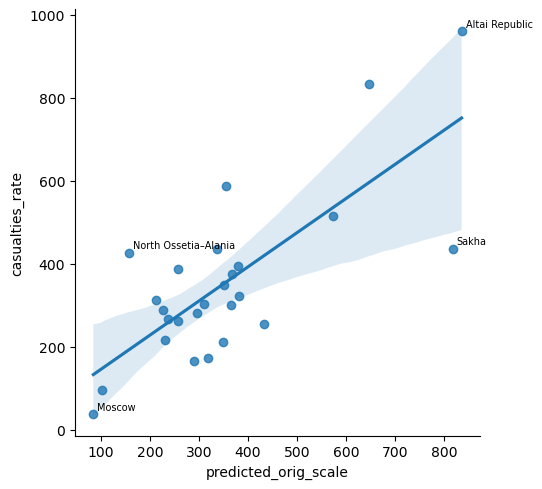

In [117]:
h = sns.lmplot(data = true_and_predicted, x = "predicted_orig_scale", y = "casualties_rate")

influential_regions = ["Altai Republic", "Sakha", "North Ossetia–Alania", "Moscow"]

for i, row in true_and_predicted.iterrows():
    if i in influential_regions:
        h.ax.annotate(str(i), xy = (row["predicted_orig_scale"], row["casualties_rate"]), xytext = (3, 3), textcoords = "offset points", fontsize = 7)

plt.show()

These influential regions belong to different classes: eliminating Altai Republic decreases the quality of predictions, while elimiating three other regions increases it. Thus, North Ossetia-Alania, Moscow and Sakha look like "outliers" which our model does not capture well. In fact, according to our model, Sakha and Altai Republic are practically identical, but in reality their casualty rates are very different. If our model could better differentiate between these two cases, its performance would likely improve. Although the regression line is roughly equidistant from both Sakha and the Altai Republic, the latter is situated closely to the line connecting it to Chukotka Autonomous Okrug, whereas Sakha stands out as a true outlier.

Overall, we might say that the influence of these three cases on the model performance is significant and noticeable, but hardly dramatic: our sample is very small (less than 30 observations), but eliminating any of these regions results in a drop in the model's quality of no more than 7-9%.  

Still, It is worth considering briefly each of these cases. Moscow is an exception from the general rule established by our model because of its remarkably low (in the comparative perspective) casualty rate. This can be attributed to a wide range of factors, as Moscow is very different from other regions — except possibly for Saint Petersburg — in terms of various socio-economic characteristics.  It also might be important that Moscow has an especially important political status, and high mobilization rates could lead to grievances which Russian government obviously tries to avoid. In this sense, Moscow is a "separate world" during this war, with the political establishment making considerable efforts to minimize the perception among Moscow residents that Russia is engaged in a full-blown war [[2]](https://republic.ru/posts/106722).

North Ossetia is an exception from the general tendency observed in the Caucasian republics: in North Ossetia, casualty rate is unusually high for this region. The reasons behind this pattern are not totally clear; it could be that our model does not adequately account for the socio-economic factors involved, or there may be cultural influences at play. For instance, in contrast to most other Caucasian republics of Russia (except for Adygea), Islam is not the largest confession in North Issetia, with approximately 50% of the population identifying as Orthodox Christians [[3]](https://en.wikipedia.org/wiki/Islam_in_Russia#Islam_in_Russia_by_region). 

It is perhaps even more difficult to understand why the predictions for Sakha are significantly higher than the actual casualty rate. To investigate the factors driving these inflated predictions, we can use the SHAP method.

In [118]:
# Initializing SHAP for our model and data
def model_predict(X):
    return svr_tuned.predict(X)

explainer = shap.Explainer(model_predict, predictors_fin_test)
shap_values = explainer(predictors_fin_test)
shap.initjs()

ExactExplainer explainer: 27it [00:41,  1.59s/it]                                                                      


It is interesting to investigate which factors drive the results for all our "outliers", not only Sakha.

North Ossetia–Alania:


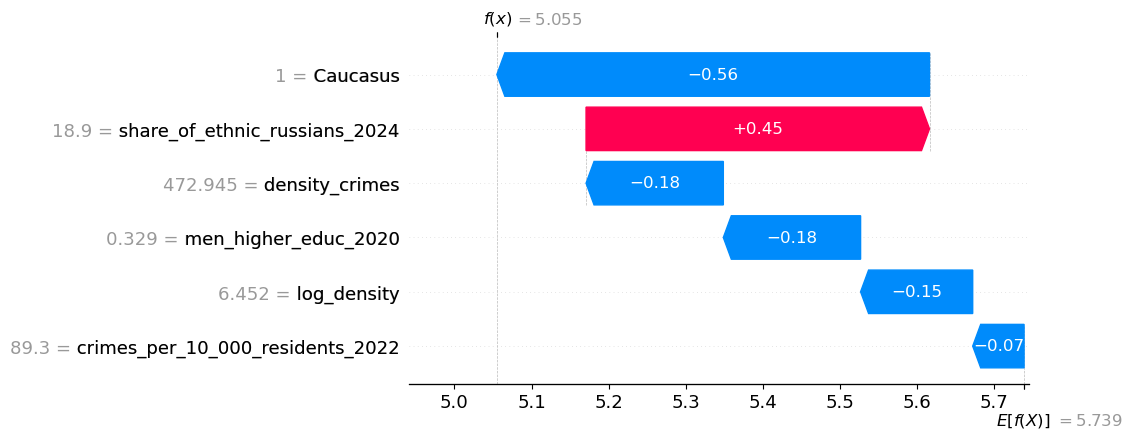

Moscow:


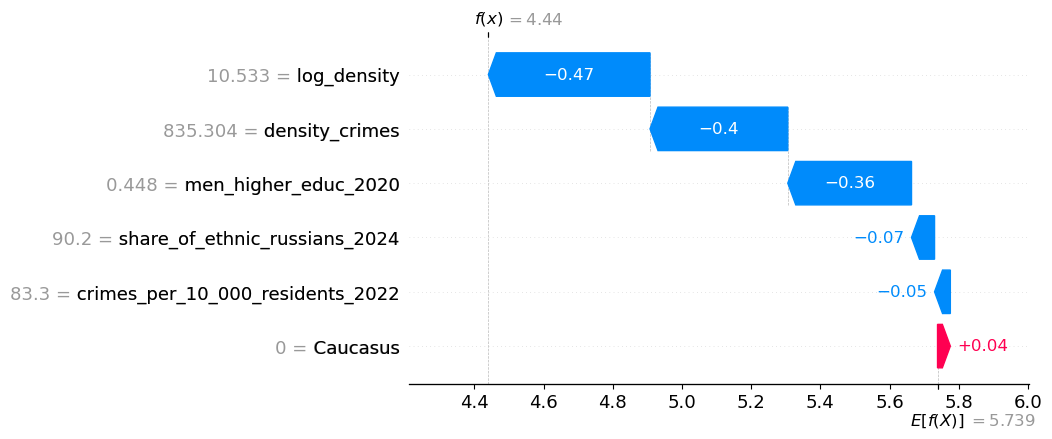

Sakha:


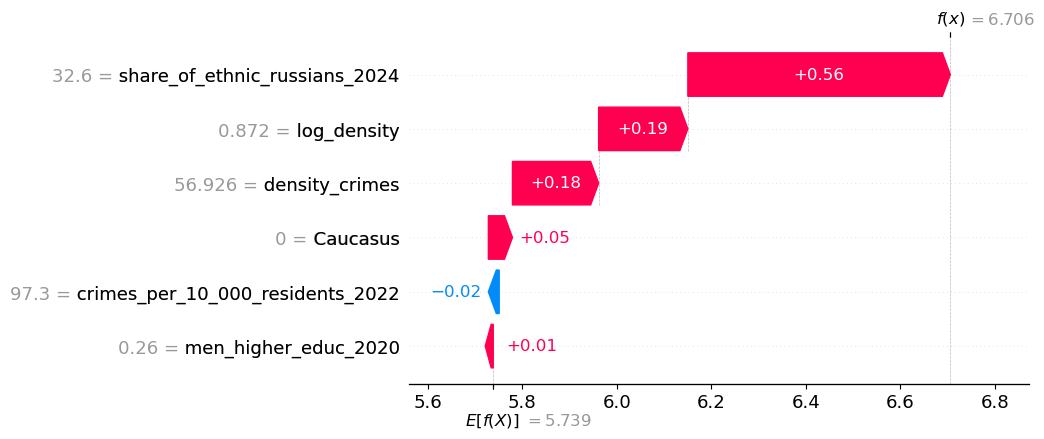

In [119]:
# Identifying indices of our "outliers"
test_indices = predictors_fin_test.reset_index().copy()
test_indices.index.name = "index"
outliers = ["North Ossetia–Alania", "Moscow", "Sakha"]
idx_outliers = [idx for region in outliers for idx in test_indices.index[test_indices["region_in_English"] == region]]

# SHAP waterfall plot for "outliers"
for i, region in zip(idx_outliers, outliers):
    print(f"{region}:")
    shap.waterfall_plot(shap_values[i])

As we may see, the model's prediction for Moscow is very low and it is pushed down by every single feature (except for small positive influence of "Caucasus" feature). In reality, the prediction should be even lower, highlighting Moscow's unique position in the "war landscape" of Russia.

For North Ossetia-Alania, the prediction is strongly affected by the "Caucasus" feature, but this influence distorts the reality in this particular case. The question of why this is the case remains, but it is not addressed in this project, although it is an intriguing topic to consider.

The case of Sakha is perhaps the least clear. The main factor contributing to the too high prediciton is the (relatively low) share of the ethnically Russian population. This in itself is a reflection of a peculiar pattern: casualty rates per 100 000 men tend to be higher, ceteris paribus, in regions with a comparatively low share of ethnically Russian population. As discussed previously, this pattern does not seem to indicate any real causal relationships; instead, it serves as a proxy for other factors. These may include elements of the imperial or quasi-imperial logic in Russian recruitment policies or the distribution of positions within the Russian army (on this topic, see the [paper](https://www.tandfonline.com/doi/full/10.1080/1060586X.2025.2484150) by Driscoll et al.). Though such factors appear to have explanatory force for many other regions, Sakha, for some reasons, does not fully conform to these patterns (provided that our data is largely accurate in the first place).

Overall, these outliers, particularly Sakha, indicate that, while our model is relatively successful in statistical sense, it is substantively limited. It would be overly presumptuous to claim that it reveals a "causal mechanism" behind casualty rates across Russian regions. As mentioned at the beginning of this analysis, several features highlighted by the final model — such as the proportion of the ethnically Russian population, the "Caucasus" feature, and the logarithm of population density — do not have self-sufficient explanatory power. They likely serve as proxies for other unobserved factors that may have a genuine causal effect. Some of these possible factors were hinted to above.

It is intriguing to explore whether the features in our model have similar effects across our sample. Since SVR does not permit direct evaluation of coefficients, we can employ the SHAP method once again. Let’s randomly select 10 observations and examine the patterns to understand how the features influence the predictions.

Orenburg Oblast:


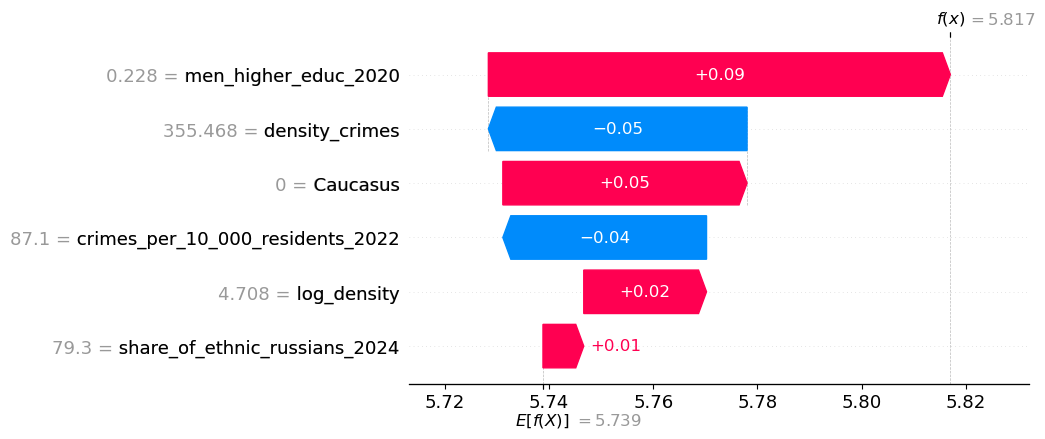

Leningrad Oblast:


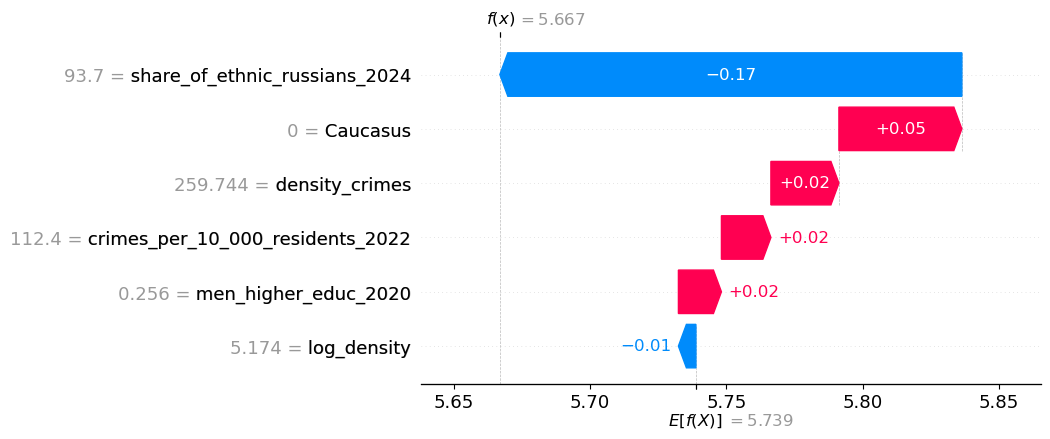

Smolensk Oblast:


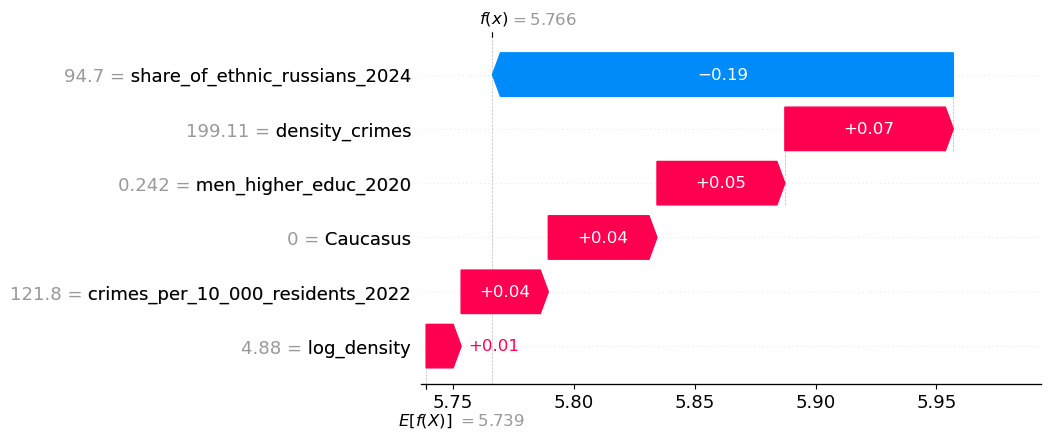

Oryol Oblast:


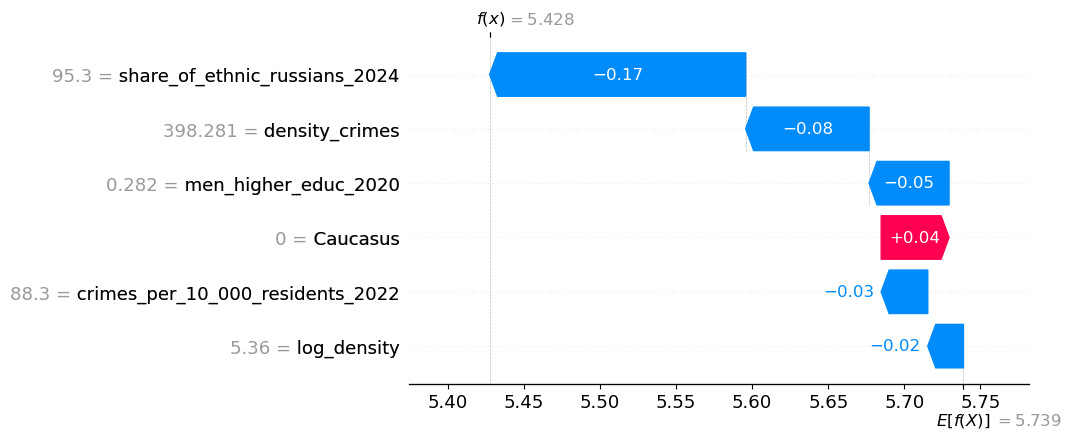

Yamalo-Nenets Autonomous Okrug:


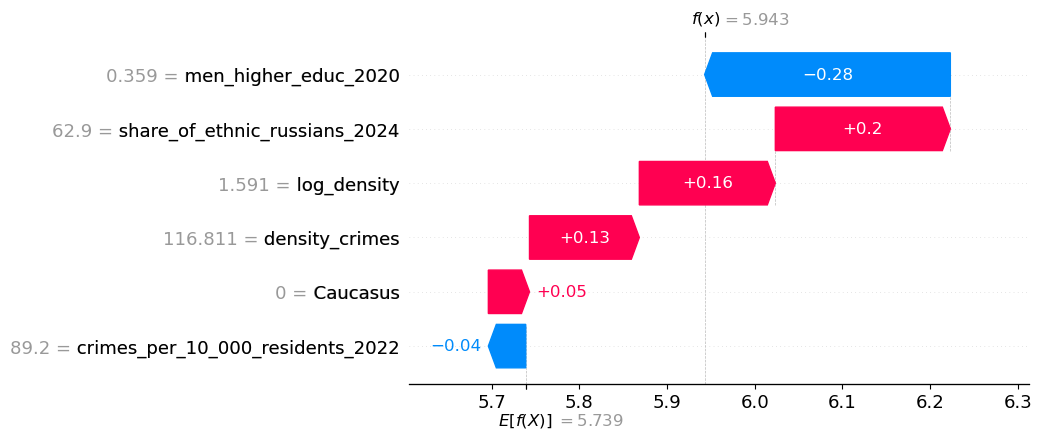

Ivanovo Oblast:


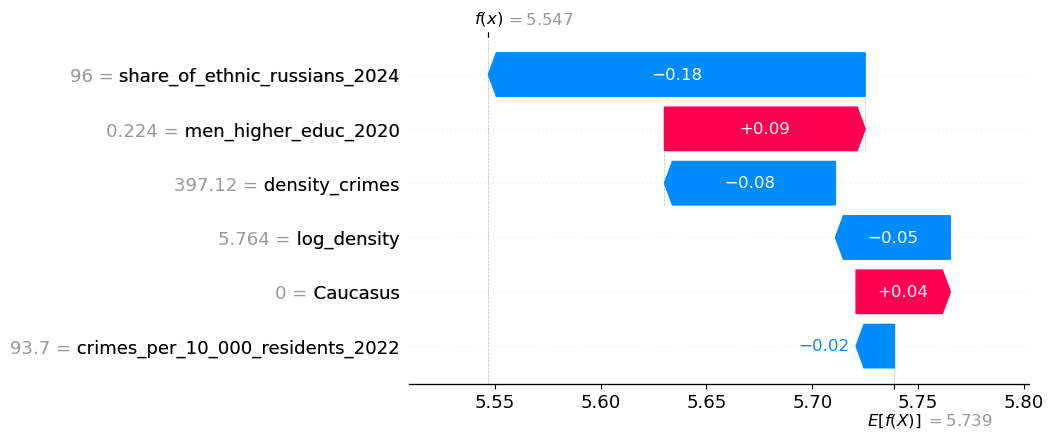

Jewish Autonomous Oblast:


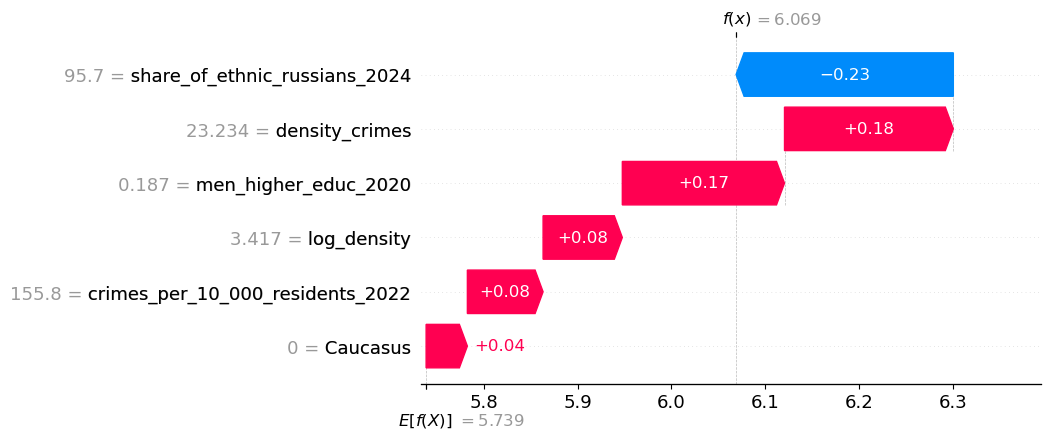

Komi Republic:


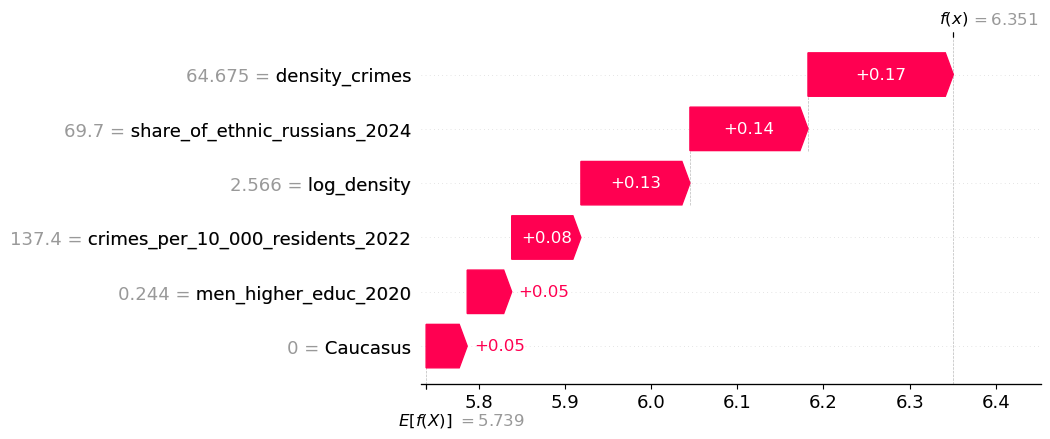

Primorsky Krai:


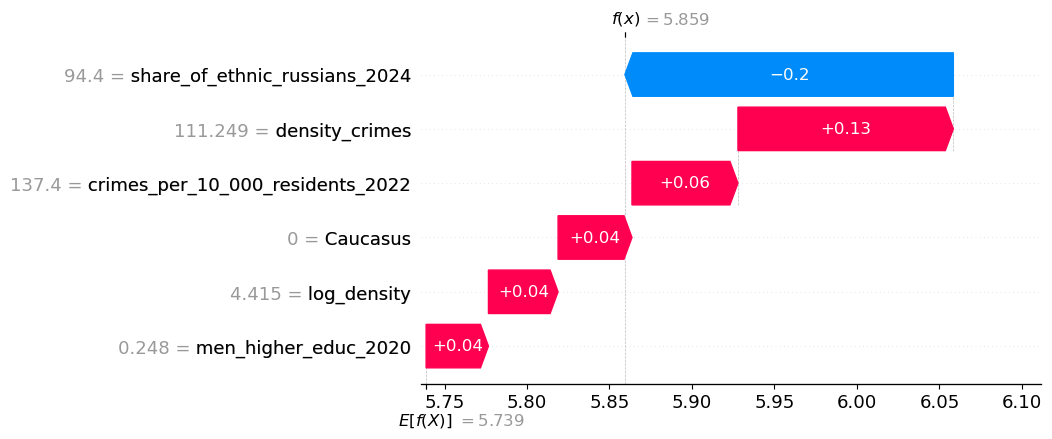

Ingushetia:


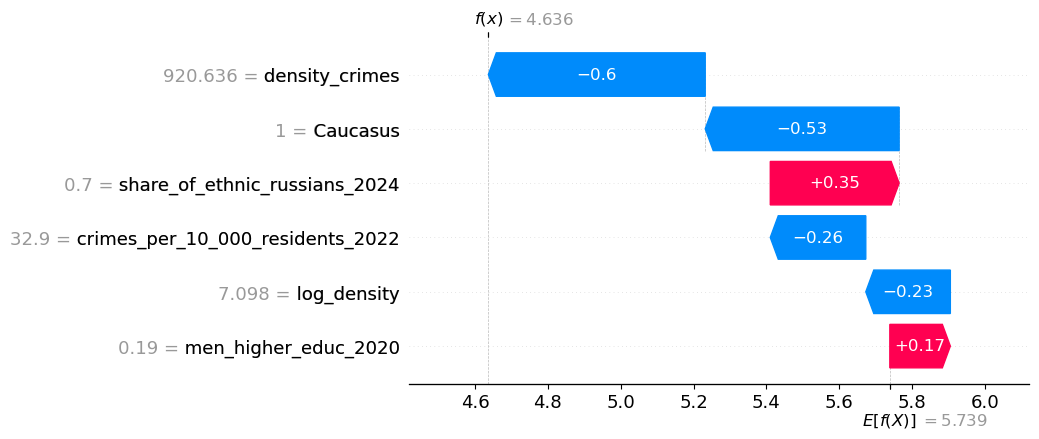

In [120]:
# SHAP waterfall plots for 10 randomly selected regions
random.seed(42)
ten_random_regions = random.sample(predictors_fin_test.index.to_list(), 10)
idx_random_regions = [idx for region in ten_random_regions for idx in test_indices.index[test_indices["region_in_English"] == region]]

# SHAP waterfall plot for "outliers"
for i, region in zip(idx_random_regions, ten_random_regions):
    print(f"{region}:")
    shap.waterfall_plot(shap_values[i])

In [121]:
# Descriptive statistics for the features
predictors_fin_test.describe().round(3)

men_higher_educ_2020  density_crimes  log_density  \
count                26.000          26.000       26.000   
mean                  0.263         280.046        4.588   
std                   0.056         228.248        2.146   
min                   0.187         -23.427       -0.712   
25%                   0.226         123.793        3.627   
50%                   0.253         240.558        4.818   
75%                   0.283         392.797        5.529   
max                   0.448         920.636       10.533   

       crimes_per_10_000_residents_2022  Caucasus  \
count                            26.000    26.000   
mean                            107.215     0.077   
std                              27.281     0.272   
min                              32.900     0.000   
25%                              89.500     0.000   
50%                              99.600     0.000   
75%                             128.575     0.000   
max                             161.600     1.000   

       share_of_ethnic_russians_2024  
count                         26.000  
mean                          77.250  
std                           26.207  
min                            0.700  
25%                           67.750  
50%                           91.900  
75%                           94.625  
max                           96.000

Comparing the data from SHAP waterfall plots with the descriptive statistics above, we may notice that, indeed, the model exhibits some consistent patterns:
* A relatively high rate of higher education among men tends to be negatively associated with the casualty rate.
* Interpreting the effects of the "density_crimes" interaction term is challenging without explicitly provided coefficients. However, we observe in the plots above that the logic of its association with the target variable is the same as that of the "original" variables from which it is derived. As previously discussed, population density serves as a proxy for potential causal factors such as the level of political significance for the federal government, the administrative capabilities of local authorities to carry out coercive mobilization, and the capacity of civil society to organize resistance against mobilization efforts. Crime rates, on the other hand, purport to be a proxy for the general well-being in the region. The interaction term "density_crimes" is thus a variable aiming at capturing the intersection between these factors (associated with coercive mobilization and volunteer consription, in terms of our previous discussion). In sum, as "density_crimes" and population density increase, casualty rates tend to decrease; conversely, higher crime rates are associated with increased casualty rates. 
* Both the "Caucasus" feature and the higher percentage of ethnically Russian population tend to be associated with the lower casualty rates.

Is it possible to extract some general lessons from our model, given its limitations noted above?

I believe the answer is more positive than negative. Below, I sumarize the key takeaways of the preceding analysis.

### Lesson 1. The intertwinement of the political and socio-economic logics within Russian recruitment policies

Perhaps the most general takeaway from the above analysis is that the patterns of casualties across Russian regions are indeed complex; they likely result from intricate intersections and interactions of various factors. 

Our analysis bolsters the hypothesis that both political and socio-economic logics are involved. To simplify the conceptual structure of  discussion, I associated political factors with coercive mobilization component of the Russian recruitment policy, whereas socio-economic factors might be especially pronounced for the other recruitment channel - volunteer conscription with substantive material incentives. The population density and the share of ethnically Russian population variables purport to reflect some elements of the political logic, whereas crime rates and the share of men with higher education aim to caprure relevant socio-economic characteristics. Crime rates, howerver, might be relevant for some peculiar practices of coercive mobilization as well, namely "direct" mobilization from prisons. There is some evidence that prisoners from ethnic minorities are particularly vulnerable to this form of coercive mobilization. ([[4]](https://www.rferl.org/a/russia-war-ukraine-inmates-concsripts-ethnic-minorities-coersion-rights-romanova/33492747.html)).

### Lesson 2. The intertwinement of general and local, contextual factors

The apparent significance of the "Caucasus" feature supports the conjecture that purely contextual factors might be important. Perhaps certain traits of Caucasian societies, such as their tight-knit social networks, could make Caucasian men less responsive to the individual incentives to participate in war; perhaps recent political history makes Russian government oversensitive to public sentiment in the Caucasus region, and this affects the political logic of rectuitment efforts in this region; perhaps Caucasian society (once again, thanks to tight social networks) is especially capable of resistance against mobilization efforts (protests in Dagestan were perhaps the most significant in the active phase of coercive mobilization). The precise reasons remain unclear, but our model indicates that Caucasian republics do not fully align with general patterns observed elsewhere.     

### Lesson 3. Economic conditions as such do not explain recruitment rates patterns

Interestingly, the most obvious economic variables, such as poverty level or (adjusted) average salary, have not exhibited sufficient explanatory power to be included in our final model. This is noteworthy because it is natural to regard these factors as the primary drivers within the socio-economic logic of recruitment. Indeed, there has been some debates as to whether such factors are able to account for observed patterns ([[5]](https://ore.exeter.ac.uk/repository/handle/10871/133317), [[6]](https://russiapost.info/society/targeting_ethnic_minorities)). Our model suggests a potential resolution to this issue: what may be particularly relevant in terms of socio-economic characteristics are not the economic conditions themselves but their intersection with social parameters (perhaps the presence of sufficiently developed networks of social support) and susceptibility to the state propaganda. The probable importance of social parameters is hinted at by our "Caucasus" feature (an economically disadvantaged region, albeit with relatively strong elements of traditional society) and crime rates, whereas the significance of the share of men with higher education supports the second proposition. 

### Lesson 4. Regions with a substantial share of ethnic minorities appear to be disproportionally affected

One of the most concerning and politically sensitive findings from the analysis is linked to the ethnic composition of regional populations. Our model indicates that regions with a higher percentage of ethnic minorities tend to experience higher casualty rates. 

A very important caveat is that the preceding analysis did not take into account the actual ethnicity of soldiers but was conducted on the regional level. This distinction may be significant, because there is research suggesting that ethnicity as such is not an explanatory factor of casualty rates in this war ([[7]](https://ore.exeter.ac.uk/repository/handle/10871/133317)). However, there is also plenty of evidence to the contrary ([[8]](https://brill.com/view/journals/inas/25/1/article-p126_11.xml#FN000009), [[9]](https://www.themoscowtimes.com/2022/09/27/ethnic-minorities-hit-hardest-by-russias-mobilization-activists-say-a78879)). 

In any case, it would be more reasonable to adopt a cautious interpretation of our findings, framing them in terms of regions with a substantial share of ethnic minorities rather than in terms of ethnic groups as such. Still, even this formulation raises questions about the underlying reasons for the observed patterns (assuming our model is reliable in this respect). As discussed earlier, these patterns may reflect some form of "imperial" logic influencing Russian recruitment policy. 

Another suggested explanation points to the presence of large military bases in near-border regions with high levels of ethnic minorities ([[10]](https://brill.com/view/journals/inas/25/1/article-p126_11.xml#FN000009)). However, if consider the sheer number of military bases across regions [[11]](https://en.wikipedia.org/wiki/List_of_Russian_military_bases), there does not appear to be a strong correlation with casualty rates. For instance, there are many bases in Moscow Oblast and Leningrad Oblast, both of which have low casualty rates; there are bases in other regions with low casualty rates, such as Chechnya, Amur Oblast, Nizhny Novgorod Oblast, etc. At the very least, the presence of military bases has to be combined with some other factors to serve as a reasonable explanatory variable; but, once again, the share of ethnic minorities in the regional population is the best candidate for such a factor.

***

Overall, when considering both political and socio-economic factors, it appears that the Russia-Ukraine war disproportionately affects the more vulnerable social strata — groups with fewer resources and types of capital (economic, social, symbolic). These groups ultimately become another victim of the war. If this observation is accurate, it highlights an  easily overlooked aspect of the tragic nature of this war.